In [1]:
# Import packages
%load_ext autoreload
import sys
sys.path.append('../')

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

import os
import numpy as np
from scipy.interpolate import interp1d, interp2d, UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.misc import derivative
from tqdm import tqdm_notebook as tqdm
import pickle
from numba import jit, njit

import config
import main
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
from H2 import *

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/H2_output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/H2_figs/'

The quantities we need to solve for are the ionization fraction, H$_2$ fraction, and matter temperature (for the density, we use a fitting function for top-hat profile evolution). For each halo, we need to fix the virialization redshift $z_\text{vir}$ and the total mass $M_\text{halo}$.

The units we use are energy and temperature in eV, density in cm$^{-3}$, and halo mass in $M_\odot$.

## Cross-checks

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


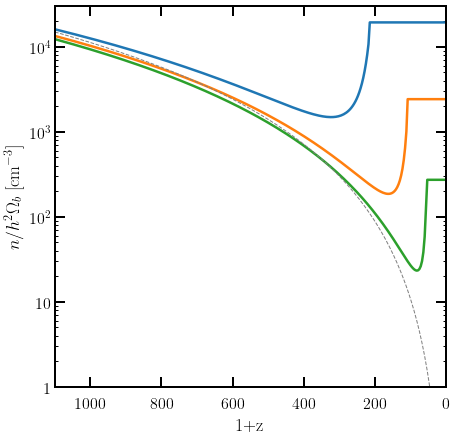

In [2]:
# Reproduce Fig. 2 of astro-ph/9603007
rs_list = np.linspace(1100,0,num=300)
y_fac = 1 / phys.omega_baryon / phys.h**2

n_list = {}
n_list[200] = n_TH(rs_list, 200)
n_list[100] = n_TH(rs_list, 100)
n_list[50] = n_TH(rs_list, 50)

for key in n_list.keys():
    vir_ind = np.where(rho_TH(rs_list, key) > rho_vir(rs_list))[0]
    if len(vir_ind) != 0:
        vir_ind = vir_ind[0]
        n_list[key][vir_ind:] = rho_vir(rs_list[vir_ind]) * phys.nB / (phys.rho_DM + phys.rho_baryon)

plt.figure(figsize=(7,7))
plt.yscale('log')
plt.plot(rs_list, n_list[200] * y_fac)
plt.plot(rs_list, n_list[100] * y_fac)
plt.plot(rs_list, n_list[50] * y_fac)
plt.plot(rs_list, phys.nB*rs_list**3 * y_fac, linewidth=1, color='gray', linestyle='--')

plt.axis([1100,0,1,3e4])
plt.xlabel('1+z')
plt.ylabel(r'$n / h^2 \Omega_b$ [cm$^{-3}$]')

plt.show()

In [3]:
%autoreload
start_rs = 2000.
end_rs = 4.

rs_vir = 22.24044855 #17.6495827 #19.81248687084208 #100.
M_halo = M_given_T(rs_vir, 2e3 * phys.kB)#phys.TCMB(rs_vir))
init_H2 = [1e-10]

print(f"Using rs_vir = {rs_vir} and M_halo = {M_halo} solar masses.")
print(f"T_vir = {T_vir(rs_vir, M_halo)/phys.kB:.0f} K.")

print(f"n_vir / 1e3 cm^3  = {rho_vir(rs_vir) * phys.nH / (phys.rho_DM + phys.rho_baryon) / 1e3:.6f}.")
#print(f"n_pres / 1e3 cm^3 = {rho_pres(rs_vir, M_halo) * phys.nH / (phys.rho_DM + phys.rho_baryon) / 1e3:.6f}.")

test_result, rs_vir_actual = halo_integrate(rs_vir, M_halo, init_H2, start_rs=2000., end_rs=5.,
                                           H2_form_rate='old', H2_cool_rate='old')
print(rs_vir_actual)

Using rs_vir = 22.24044855 and M_halo = 1709948.1868690273 solar masses.
T_vir = 2000 K.
n_vir / 1e3 cm^3  = 0.000371.
23.497951098792807


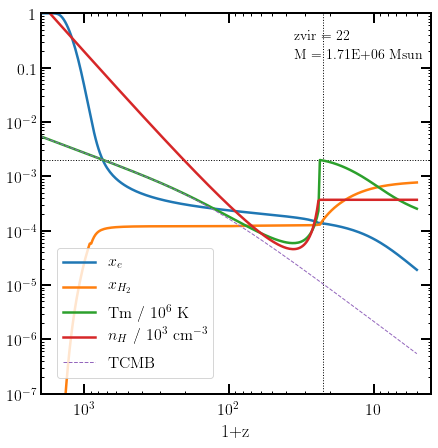

In [4]:
# change h = 0.5, Ω = 1 and Ωb = 0.06.

plt.figure(figsize=(7,7))
ax = plt.gca()
plt.loglog()

plt.plot(test_result['t'], test_result['y'][0], label=r'$x_e$')
plt.plot(test_result['t'], test_result['y'][1], label=r'$x_{H_2}$')
plt.plot(test_result['t'], test_result['y'][2] / phys.kB / 1e6, label='Tm / 10$^6$ K')
plt.plot(test_result['t'], test_result['y'][3] / 1e3, label=r'$n_H$ / 10$^3$ cm$^{-3}$')

plt.plot(test_result['t'], phys.Tm_std(test_result['t']) / phys.kB / 1e6, label='TCMB',
        linewidth=1, linestyle='--')
plt.vlines(rs_vir, 1e-7, 1, linewidth=1, linestyle=':')
plt.hlines(T_vir(rs_vir, M_halo) / phys.kB / 1e6,2000,4, linewidth=1, linestyle=':')
plt.axis([2000,4,1e-7,1])

plt.legend(loc='lower left')
plt.xlabel('1+z')
plt.text(0.65, 0.93, fr"zvir = {rs_vir:.0f}", fontsize=14, transform = ax.transAxes)
plt.text(0.65, 0.88, fr"M = {M_halo:.2E} Msun", fontsize=14, transform = ax.transAxes)

# plt.savefig(fig_dir+f'halo_evol_zvir{rs_vir:.0f}_M{M_halo:.2E}.pdf')
plt.show()

In [5]:
%autoreload
print(collapse_criterion(test_result['t'], test_result['y'][2], rs_vir_actual))

using collapse factor 0.75
False


# Adding spectral distortions

In [13]:
# LCDM data
no_DM = pickle.load(open('/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_hyrec_comparison_runs/phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p', 'rb'))

# Package distortions together
LCDM_specs = no_DM['data'][-1]['distortions'].copy()
for ii, rs in enumerate(no_DM['data'][-1]['rs']):
    temp_dist = no_DM['data'][-1]['distortions'].copy()
    temp_dist.redshift(rs)
    weights = np.zeros_like(no_DM['data'][-1]['rs'])
    weights[:ii] = 1
    LCDM_specs[ii] = temp_dist.sum_specs(weight=weights)

../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectra.py:244: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(type(key), int):


In [14]:
# Load spectral distortion from LCDM
start_rs = 2000.
end_rs = 4.
rs_list = 10**np.arange(np.log10(start_rs), np.log10(end_rs), -0.01)

rs_vir = 19.81248687084208 #17.6495827 #19.81248687084208 #22.24044855 #100.
M_halo = M_given_T(rs_vir, 2e3 * phys.kB)#phys.TCMB(rs_vir))
init_H2 = [1e-10]

In [15]:
%autoreload
(f"Using rs_vir = {rs_vir} and M_halo = {M_halo} solar masses.")
print(f"T_vir = {T_vir(rs_vir, M_halo)/phys.kB:.0f} K.")

print(f"n_vir / 1e3 cm^3  = {rho_vir(rs_vir) * phys.nH / (phys.rho_DM + phys.rho_baryon) / 1e3:.6f}.")
#print(f"n_pres / 1e3 cm^3 = {rho_pres(rs_vir, M_halo) * phys.nH / (phys.rho_DM + phys.rho_baryon) / 1e3:.6f}.")

test_result_dist, rs_vir_actual_dist = halo_integrate(rs_vir, M_halo, init_H2, 
                                                      start_rs=2000., end_rs=5., dists=LCDM_specs,
                                                      H2_cool_rate='old')
print(rs_vir_actual_dist)

T_vir = 2000 K.
n_vir / 1e3 cm^3  = 0.000262.
20.942570961020017


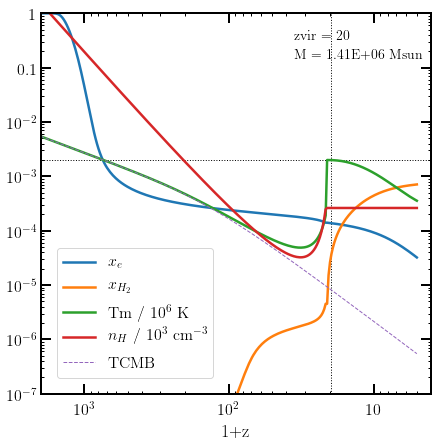

In [16]:
# change h = 0.5, Ω = 1 and Ωb = 0.06.

plt.figure(figsize=(7,7))
ax = plt.gca()
plt.loglog()

plt.plot(test_result_dist['t'], test_result_dist['y'][0], label=r'$x_e$')
plt.plot(test_result_dist['t'], test_result_dist['y'][1], label=r'$x_{H_2}$')
plt.plot(test_result_dist['t'], test_result_dist['y'][2] / phys.kB / 1e6, label='Tm / 10$^6$ K')
plt.plot(test_result_dist['t'], test_result_dist['y'][3] / 1e3, label=r'$n_H$ / 10$^3$ cm$^{-3}$')

plt.plot(test_result_dist['t'], phys.Tm_std(test_result_dist['t']) / phys.kB / 1e6, label='TCMB',
        linewidth=1, linestyle='--')
plt.vlines(rs_vir, 1e-7, 1, linewidth=1, linestyle=':')
plt.hlines(T_vir(rs_vir, M_halo) / phys.kB / 1e6,2000,4, linewidth=1, linestyle=':')
plt.axis([2000,4,1e-7,1])

plt.legend(loc='lower left')
plt.xlabel('1+z')
plt.text(0.65, 0.93, fr"zvir = {rs_vir:.0f}", fontsize=14, transform = ax.transAxes)
plt.text(0.65, 0.88, fr"M = {M_halo:.2E} Msun", fontsize=14, transform = ax.transAxes)

# plt.savefig(fig_dir+f'halo_evol_zvir{rs_vir:.0f}_M{M_halo:.2E}.pdf')
plt.show()

# Adding DM

In [17]:
# Load spectral distortions data
DM_ind = 0
DM_data = []
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_nmax_200_runs/'

directory = os.fsencode(dir_str)
skip = 4

for file in tqdm(sorted(os.listdir(directory))[::skip]): 
    filename = os.fsdecode(file)
    DM_data.append(pickle.load(open(dir_str+filename, 'rb')))

# Make new Spectra object that gives TOTAL distortion at each redshift
DM_specs = DM_data[DM_ind]['data'][-1]['distortions'].copy()
for ii, rs in enumerate(tqdm(DM_data[DM_ind]['data'][-1]['rs'])):
    temp_dist = DM_data[DM_ind]['data'][-1]['distortions'].copy()
    temp_dist.redshift(rs)
    weights = np.zeros_like(DM_data[DM_ind]['data'][-1]['rs'])
    weights[:ii] = 1
    DM_specs[ii] = temp_dist.sum_specs(weight=weights)
    
# Make f's into interpolating functions
f_func_list = {}
for key in DM_data[DM_ind]['data'][-1]['f']:
    f_func_list[key] = interp1d(DM_data[DM_ind]['data'][-1]['rs'], DM_data[DM_ind]['data'][-1]['f'][key])
    
# Package DM information together
test_DM = (
    DM_data[DM_ind]['DM_params']['mDM'], # mDM in [eV]
    DM_data[DM_ind]['DM_params']['inj_param'], # lifetime in [s]
    DM_data[DM_ind]['DM_params']['DM_process'], # injection type
    DM_data[DM_ind]['DM_params']['pri'], # injected particle
    f_func_list, # energy deposition f's
)

../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectra.py:244: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(type(key), int):


In [18]:
%autoreload
print(f"Using rs_vir = {rs_vir} and M_halo = {M_halo} solar masses.")
print(f"T_vir = {T_vir(rs_vir, M_halo)/phys.kB:.0f} K.")

print(f"n_vir / 1e3 cm^3  = {rho_vir(rs_vir) * phys.nH / (phys.rho_DM + phys.rho_baryon) / 1e3:.6f}.")
#print(f"n_pres / 1e3 cm^3 = {rho_pres(rs_vir, M_halo) * phys.nH / (phys.rho_DM + phys.rho_baryon) / 1e3:.6f}.")

test_result_DM, rs_vir_actual_DM = halo_integrate(
    rs_vir, M_halo, init_H2, start_rs=2000., end_rs=4., 
    H2_cool_rate='old',
    #dists=DM_data[0]['data'][-1]['distortions'], H2_cool_rate='old',
    DM_switch=True, DM_args=test_DM
)
print(rs_vir_actual_DM)

Using rs_vir = 19.81248687084208 and M_halo = 1409684.1588812212 solar masses.
T_vir = 2000 K.
n_vir / 1e3 cm^3  = 0.000262.
21.43038610475419


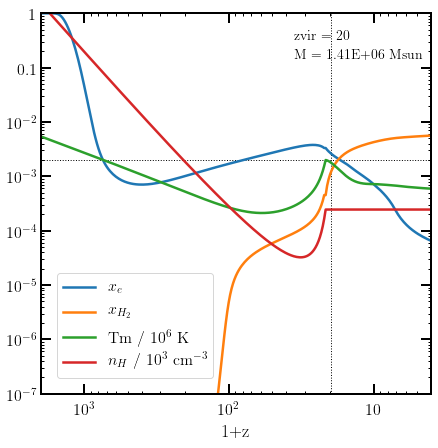

In [23]:
# change h = 0.5, Ω = 1 and Ωb = 0.06.

plt.figure(figsize=(7,7))
ax = plt.gca()
plt.loglog()

plt.plot(test_result_DM['t'], test_result_DM['y'][0], label=r'$x_e$')
plt.plot(test_result_DM['t'], test_result_DM['y'][1], label=r'$x_{H_2}$')
plt.plot(test_result_DM['t'], test_result_DM['y'][2] / phys.kB / 1e6, label='Tm / 10$^6$ K')
plt.plot(test_result_DM['t'], test_result_DM['y'][3] / 1e3, label=r'$n_H$ / 10$^3$ cm$^{-3}$')

# plt.plot(test_result_DM['t'], phys.Tm_std(test_result_DM['t']) / phys.kB / 1e6, label='TCMB',
#         linewidth=1, linestyle='--')
# plt.plot(test_result_DM['t'], phys.nH * test_result_DM['t']**3 / 1e3, label='IGM density',
#         linewidth=1, linestyle='--')
plt.vlines(rs_vir, 1e-7, 1, linewidth=1, linestyle=':')
plt.hlines(T_vir(rs_vir, M_halo) / phys.kB / 1e6,2000,4, linewidth=1, linestyle=':')
plt.axis([2000,4,1e-7,1])

plt.legend(loc='lower left')
plt.xlabel('1+z')
plt.text(0.65, 0.93, fr"zvir = {rs_vir:.0f}", fontsize=14, transform = ax.transAxes)
plt.text(0.65, 0.88, fr"M = {M_halo:.2E} Msun", fontsize=14, transform = ax.transAxes)

# plt.savefig(fig_dir+f'halo_evol_zvir{rs_vir:.0f}_M{M_halo:.2E}.pdf')
plt.show()

In [26]:
%autoreload
print(collapse_criterion(test_result_DM['t'], test_result_DM['y'][2], rs_vir_actual_DM))

using collapse factor 0.75
True


# "Shooting scheme"

In [8]:
# Load spectral distortions data
DM_data = []
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_nmax_200_runs/'

directory = os.fsencode(dir_str)
skip = 4

for file in tqdm(sorted(os.listdir(directory))[::skip]): 
    filename = os.fsdecode(file)
    DM_data.append(pickle.load(open(dir_str+filename, 'rb')))

DM_ind = 0

# Make new Spectra object that gives TOTAL distortion at each redshift
DM_specs = DM_data[DM_ind]['data'][-1]['distortions'].copy()
for ii, rs in enumerate(tqdm(DM_data[DM_ind]['data'][-1]['rs'])):
    temp_dist = DM_data[DM_ind]['data'][-1]['distortions'].copy()
    temp_dist.redshift(rs)
    weights = np.zeros_like(DM_data[DM_ind]['data'][-1]['rs'])
    weights[:ii] = 1
    DM_specs[ii] = temp_dist.sum_specs(weight=weights)

# Make interpolation functions for f's
f_func_list = {}
for key in DM_data[DM_ind]['data'][-1]['f']:
    f_func_list[key] = interp1d(
        DM_data[DM_ind]['data'][-1]['rs'], DM_data[DM_ind]['data'][-1]['f'][key],
        bounds_error=False, fill_value=0
    )

# Package DM information together
test_DM = (
    DM_data[DM_ind]['DM_params']['mDM'], # mDM in [eV]
    DM_data[DM_ind]['DM_params']['inj_param'], # lifetime in [s]
    DM_data[DM_ind]['DM_params']['DM_process'], # injection type
    DM_data[DM_ind]['DM_params']['pri'], # injected particle
    f_func_list, # energy deposition f's
)

/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/darkhistory/spec/spectra.py:244: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(type(key), int):



(1031997.8939289186, 2.69747957975171e+24, 'decay', 'elec', {'H ion': <scipy.interpolate.interpolate.interp1d object at 0x7fcfff45a410>, 'He ion': <scipy.interpolate.interpolate.interp1d object at 0x7fcffdff1350>, 'Lya': <scipy.interpolate.interpolate.interp1d object at 0x7fcffdff1170>, 'heat': <scipy.interpolate.interpolate.interp1d object at 0x7fcfff469350>, 'cont': <scipy.interpolate.interpolate.interp1d object at 0x7fcfff469dd0>, 'err': <scipy.interpolate.interpolate.interp1d object at 0x7fcfff469890>})


In [9]:
%autoreload
rs_vir_list = np.logspace(np.log10(200.), np.log10(7.), num=30)

res = shooting_scheme(rs_vir_list, dists=DM_specs, 
                      H2_cool_rate='new', DM_switch=True, DM_args=test_DM)
# pickle.dump(res, open(output_dir+'critical_collapse_'
#                       +DM_data[DM_ind]['DM_params']['pri']+'_'
#                       +DM_data[DM_ind]['DM_params']['DM_process']+'_'
#                       +f"log10mDM_{np.log10(DM_data[DM_ind]['DM_params']['mDM']):2.4f}_"
#                       +f"log10param_{np.log10(DM_data[DM_ind]['DM_params']['inj_param']):2.4f}"
#                       +'.p','wb'))

# res = shooting_scheme(rs_vir_list,
#                       H2_cool_rate='new', DM_switch=False, DM_args=None)
# pickle.dump(res, open(output_dir+f'critical_collapse_LCDM_nodist.p','wb'))

# res = shooting_scheme(rs_vir_list, dists=atom_specs, 
#                       H2_cool_rate='new', DM_switch=False, DM_args=None)
# pickle.dump(res, open(output_dir+f'critical_collapse_LCDM_dist.p','wb'))

# res = shooting_scheme(rs_vir_list, dists=DM_specs, 
#                       H2_cool_rate='new', DM_switch=False)
# pickle.dump(res, open(output_dir+f'critical_collapse_test_DM+dist.p','wb'))

# res = shooting_scheme(rs_vir_list, 
#                       H2_cool_rate='new', DM_switch=True, DM_args=test_DM)
# pickle.dump(res, open(output_dir+f'critical_collapse_test_DM+ion.p','wb'))

[ 2.35538328e-04 -5.66400552e-16  3.45586757e-06]
[ 1.83592473e-04 -4.92202640e-16  8.57897112e-03]
[ 2.35513547e-04 -5.66366153e-16  8.38801559e-06]
[ 2.35501177e-04 -5.66348926e-16  1.07362798e-05]
[ 2.35439344e-04 -5.66262772e-16  2.23885588e-05]
[ 2.35428357e-04 -5.66247451e-16  2.44370304e-05]
[ 2.35414637e-04 -5.66228279e-16  2.69106573e-05]
[ 2.35414645e-04 -5.66228262e-16  2.68484416e-05]
[ 2.35338381e-04 -5.66121661e-16  4.05371337e-05]
[ 2.35300429e-04 -5.66068133e-16  4.63723315e-05]
[ 2.35110699e-04 -5.65800524e-16  7.55806611e-05]
[ 2.35076890e-04 -5.65753156e-16  8.14695916e-05]
[ 2.35034902e-04 -5.65693459e-16  8.69760812e-05]
[ 2.35035158e-04 -5.65692980e-16  8.51785541e-05]
[ 2.34959231e-04 -5.65584997e-16  9.50746244e-05]
[ 2.34921410e-04 -5.65530854e-16  9.92905162e-05]
[ 2.34732329e-04 -5.65260161e-16  1.20396470e-04]
[ 2.34698662e-04 -5.65212195e-16  1.24657436e-04]
[ 2.34656780e-04 -5.65151886e-16  1.28633655e-04]
[ 2.34656967e-04 -5.65151536e-16  1.27324319e-04]


[ 1.60381335e-04 -4.46979048e-16  2.35612580e-04]
[ 1.60381498e-04 -4.46979255e-16  2.35581250e-04]
[ 1.59977274e-04 -4.46287016e-16  2.35583015e-04]
[ 1.59776798e-04 -4.45943074e-16  2.35582649e-04]
[ 1.58775310e-04 -4.44224011e-16  2.35592805e-04]
[ 1.58597995e-04 -4.43919302e-16  2.35612163e-04]
[ 1.58376861e-04 -4.43539064e-16  2.35617454e-04]
[ 1.58377023e-04 -4.43539271e-16  2.35586198e-04]
[ 1.57976660e-04 -4.42850654e-16  2.35587974e-04]
[ 1.57778105e-04 -4.42508520e-16  2.35587610e-04]
[ 1.56786203e-04 -4.40798487e-16  2.35597786e-04]
[ 1.56610585e-04 -4.40495380e-16  2.35617123e-04]
[ 1.56391571e-04 -4.40117146e-16  2.35622383e-04]
[ 1.56391732e-04 -4.40117353e-16  2.35591199e-04]
[ 1.55995201e-04 -4.39432354e-16  2.35592987e-04]
[ 1.55798549e-04 -4.39092026e-16  2.35592624e-04]
[ 1.54816156e-04 -4.37391016e-16  2.35602822e-04]
[ 1.54642222e-04 -4.37089511e-16  2.35622137e-04]
[ 1.54425310e-04 -4.36713277e-16  2.35627365e-04]
[ 1.54425471e-04 -4.36713485e-16  2.35596254e-04]


[ 9.26432264e-05 -3.21091776e-16  2.35838899e-04]
[ 9.25241673e-05 -3.20850117e-16  2.35857544e-04]
[ 9.23757416e-05 -3.20548676e-16  2.35861710e-04]
[ 9.23758842e-05 -3.20548904e-16  2.35833090e-04]
[ 9.21069505e-05 -3.20002576e-16  2.35835455e-04]
[ 9.19737173e-05 -3.19731473e-16  2.35835164e-04]
[ 9.13080539e-05 -3.18376345e-16  2.35846470e-04]
[ 9.11902270e-05 -3.18136239e-16  2.35865100e-04]
[ 9.10433392e-05 -3.17836739e-16  2.35869241e-04]
[ 9.10434813e-05 -3.17836967e-16  2.35840682e-04]
[ 9.07773277e-05 -3.17294143e-16  2.35843065e-04]
[ 9.06454759e-05 -3.17024788e-16  2.35842777e-04]
[ 8.99867140e-05 -3.15678401e-16  2.35854117e-04]
[ 8.98701099e-05 -3.15439846e-16  2.35872731e-04]
[ 8.97247482e-05 -3.15142286e-16  2.35876848e-04]
[ 8.97248898e-05 -3.15142515e-16  2.35848351e-04]
[ 8.94614950e-05 -3.14603191e-16  2.35850752e-04]
[ 8.93310139e-05 -3.14335585e-16  2.35850466e-04]
[ 8.86791007e-05 -3.12997934e-16  2.35861841e-04]
[ 8.85637100e-05 -3.12760929e-16  2.35880440e-04]


[ 4.95892545e-05 -2.27254876e-16  2.36190384e-04]
[ 4.95030001e-05 -2.27051596e-16  2.36190186e-04]
[ 4.90721514e-05 -2.26035337e-16  2.36202830e-04]
[ 4.89959365e-05 -2.25855394e-16  2.36220696e-04]
[ 4.89009808e-05 -2.25631100e-16  2.36223978e-04]
[ 4.89011015e-05 -2.25631356e-16  2.36197948e-04]
[ 4.87288523e-05 -2.25224299e-16  2.36201109e-04]
[ 4.86436418e-05 -2.25022763e-16  2.36200914e-04]
[ 4.82180136e-05 -2.24015214e-16  2.36213587e-04]
[ 4.81427241e-05 -2.23836818e-16  2.36231426e-04]
[ 4.80489231e-05 -2.23614457e-16  2.36234688e-04]
[ 4.80490432e-05 -2.23614714e-16  2.36208729e-04]
[ 4.78788830e-05 -2.23211149e-16  2.36211911e-04]
[ 4.77947095e-05 -2.23011357e-16  2.36211717e-04]
[ 4.73742674e-05 -2.22012524e-16  2.36224419e-04]
[ 4.72998972e-05 -2.21835675e-16  2.36242230e-04]
[ 4.72072433e-05 -2.21615249e-16  2.36245472e-04]
[ 4.72073627e-05 -2.21615507e-16  2.36219586e-04]
[ 4.70392778e-05 -2.21215434e-16  2.36222787e-04]
[ 4.69561345e-05 -2.21017388e-16  2.36222596e-04]


[ 2.37768041e-05 -1.62730603e-16  2.36654026e-04]
[ 2.37768963e-05 -1.62730889e-16  2.36631202e-04]
[ 2.36734665e-05 -1.62455754e-16  2.36634823e-04]
[ 2.36223920e-05 -1.62320141e-16  2.36634598e-04]
[ 2.33675260e-05 -1.61641948e-16  2.36647432e-04]
[ 2.33225034e-05 -1.61522034e-16  2.36663677e-04]
[ 2.32664612e-05 -1.61372785e-16  2.36666152e-04]
[ 2.32665524e-05 -1.61373072e-16  2.36643433e-04]
[ 2.31647502e-05 -1.61101646e-16  2.36647055e-04]
[ 2.31144821e-05 -1.60967888e-16  2.36646825e-04]
[ 2.28636503e-05 -1.60298957e-16  2.36659628e-04]
[ 2.28193425e-05 -1.60180689e-16  2.36675810e-04]
[ 2.27641917e-05 -1.60033496e-16  2.36678261e-04]
[ 2.27642820e-05 -1.60033784e-16  2.36655648e-04]
[ 2.26640947e-05 -1.59766079e-16  2.36659269e-04]
[ 2.26146266e-05 -1.59634181e-16  2.36659034e-04]
[ 2.23677973e-05 -1.58974543e-16  2.36671804e-04]
[ 2.23241986e-05 -1.58857925e-16  2.36687921e-04]
[ 2.22699321e-05 -1.58712795e-16  2.36690348e-04]
[ 2.22700214e-05 -1.58713084e-16  2.36667841e-04]


[ 9.44389709e-06 -1.24906230e-16  2.37030868e-04]
[ 9.41867907e-06 -1.24850096e-16  2.37030110e-04]
[ 9.29307351e-06 -1.24569316e-16  2.37039004e-04]
[ 9.27093335e-06 -1.24520051e-16  2.37051711e-04]
[ 9.24340892e-06 -1.24459163e-16  2.37052892e-04]
[ 9.24346522e-06 -1.24459491e-16  2.37035094e-04]
[ 9.19337452e-06 -1.24348453e-16  2.37037618e-04]
[ 9.16869755e-06 -1.24294941e-16  2.37036835e-04]
[ 9.04579289e-06 -1.24027286e-16  2.37045527e-04]
[ 9.02413006e-06 -1.23980359e-16  2.37058100e-04]
[ 8.99720001e-06 -1.23922397e-16  2.37059231e-04]
[ 8.99725544e-06 -1.23922727e-16  2.37041595e-04]
[ 8.94823411e-06 -1.23817001e-16  2.37044049e-04]
[ 8.92408560e-06 -1.23766152e-16  2.37043237e-04]
[ 8.80381887e-06 -1.23511835e-16  2.37051713e-04]
[ 8.78262224e-06 -1.23467285e-16  2.37064150e-04]
[ 8.75627272e-06 -1.23412297e-16  2.37065229e-04]
[ 8.75632733e-06 -1.23412629e-16  2.37047754e-04]
[ 8.70835481e-06 -1.23312316e-16  2.37050132e-04]
[ 8.68472460e-06 -1.23264181e-16  2.37049290e-04]


[ 2.73929402e-06 -1.36434061e-16  2.36631082e-04]
[ 2.71690317e-06 -1.36871991e-16  2.36620552e-04]
[ 2.70594146e-06 -1.37096345e-16  2.36614402e-04]
[ 2.65139873e-06 -1.38233676e-16  2.36588297e-04]
[ 2.64180515e-06 -1.38439733e-16  2.36588193e-04]
[ 2.62992011e-06 -1.38700169e-16  2.36581834e-04]
[ 2.62997089e-06 -1.38701124e-16  2.36574446e-04]
[ 2.60768458e-06 -1.39194455e-16  2.36562500e-04]
[ 2.59678124e-06 -1.39447089e-16  2.36555757e-04]
[ 2.54253293e-06 -1.40728754e-16  2.36525544e-04]
[ 2.53299203e-06 -1.40961055e-16  2.36524096e-04]
[ 2.52117689e-06 -1.41254689e-16  2.36516900e-04]
[ 2.52123083e-06 -1.41255756e-16  2.36510461e-04]
[ 2.49882618e-06 -1.41818487e-16  2.36496639e-04]
[ 2.48787514e-06 -1.42106639e-16  2.36489113e-04]
[ 2.43338528e-06 -1.43569951e-16  2.36454326e-04]
[ 2.42380304e-06 -1.43835351e-16  2.36451468e-04]
[ 2.41194376e-06 -1.44170925e-16  2.36443243e-04]
[ 2.41200319e-06 -1.44172165e-16  2.36437706e-04]
[ 2.38913945e-06 -1.44826414e-16  2.36421557e-04]


[ 5.01834931e-07 -6.21779210e-16  2.27988276e-04]
[ 4.98991599e-07 -6.25786448e-16  2.27919179e-04]
[ 4.95459200e-07 -6.30850737e-16  2.27854849e-04]
[ 4.95471136e-07 -6.30853946e-16  2.27879224e-04]
[ 4.89108247e-07 -6.40113705e-16  2.27755997e-04]
[ 4.86034821e-07 -6.44822991e-16  2.27701497e-04]
[ 4.70702496e-07 -6.69099303e-16  2.27388414e-04]
[ 4.67984011e-07 -6.73547064e-16  2.27315453e-04]
[ 4.64617910e-07 -6.79170735e-16  2.27246940e-04]
[ 4.64641431e-07 -6.79175905e-16  2.27272010e-04]
[ 4.58578702e-07 -6.89462317e-16  2.27140831e-04]
[ 4.55603673e-07 -6.94694999e-16  2.27082699e-04]
[ 4.40709873e-07 -7.21690707e-16  2.26749349e-04]
[ 4.38125031e-07 -7.26641389e-16  2.26672166e-04]
[ 4.34932376e-07 -7.32900747e-16  2.26599138e-04]
[ 4.34942411e-07 -7.32904410e-16  2.26625039e-04]
[ 4.29191426e-07 -7.44357732e-16  2.26485288e-04]
[ 4.26370336e-07 -7.50185515e-16  2.26423239e-04]
[ 4.12253186e-07 -7.80274421e-16  2.26068101e-04]
[ 4.09759594e-07 -7.85796245e-16  2.25986410e-04]


[ 5.04649217e-07 -6.38891269e-14  1.06694833e-04]
[ 5.37644535e-07 -7.15192640e-14  9.95698754e-05]
[ 5.44138933e-07 -7.29875777e-14  9.81913902e-05]
[ 5.52029095e-07 -7.48740317e-14  9.65291690e-05]
[ 5.51680168e-07 -7.48739753e-14  9.66167102e-05]
[ 5.66388600e-07 -7.84187945e-14  9.34957369e-05]
[ 5.73534346e-07 -8.02660950e-14  9.19777143e-05]
[ 6.11891911e-07 -9.03228899e-14  8.37379100e-05]
[ 6.19246049e-07 -9.22649741e-14  8.21472281e-05]
[ 6.28418024e-07 -9.47630050e-14  8.02189098e-05]
[ 6.28000430e-07 -9.47627938e-14  8.03104444e-05]
[ 6.45105382e-07 -9.94659724e-14  7.66903515e-05]
[ 6.53388703e-07 -1.01921434e-13  7.49234541e-05]
[ 6.97849389e-07 -1.15341498e-13  6.53347521e-05]
[ 7.06353357e-07 -1.17943025e-13  6.34878156e-05]
[ 7.16610286e-07 -1.21293349e-13  6.12361725e-05]
[ 7.16098212e-07 -1.21292742e-13  6.13312610e-05]
[ 7.35793704e-07 -1.27613896e-13  5.71049517e-05]
[ 7.45325235e-07 -1.30920732e-13  5.50348107e-05]
[ 7.96502867e-07 -1.49070790e-13  4.38012878e-05]


[ 5.14188121e-06 -3.96419260e-10 -5.32394604e-03]
[ 5.15707080e-06 -4.10693949e-10 -5.40426919e-03]
[ 5.24627588e-06 -4.91327231e-10 -5.82589177e-03]
[ 5.26471701e-06 -5.07554824e-10 -5.90529867e-03]
[ 5.28409884e-06 -5.28597320e-10 -6.00637908e-03]
[ 5.28018965e-06 -5.28485922e-10 -6.00625494e-03]
[ 5.13675054e-06 -3.92806783e-10 -5.30362126e-03]
[ 5.15023104e-06 -4.05053745e-10 -5.37295357e-03]
[ 5.22747121e-06 -4.73102047e-10 -5.73450995e-03]
[ 5.24287129e-06 -4.86567046e-10 -5.80207767e-03]
[ 5.25974550e-06 -5.03949697e-10 -5.88788667e-03]
[ 5.25723090e-06 -5.03880169e-10 -5.88780276e-03]
[ 5.29025969e-06 -5.37429906e-10 -6.04791769e-03]
[ 5.30374866e-06 -5.55220572e-10 -6.13123068e-03]
[ 5.38251969e-06 -6.54691695e-10 -6.56650694e-03]
[ 5.39852721e-06 -6.74504218e-10 -6.64811778e-03]
[ 5.41566384e-06 -7.00121583e-10 -6.75179001e-03]
[ 5.41261872e-06 -7.00003508e-10 -6.75162161e-03]
[ 5.44596694e-06 -7.48902993e-10 -6.94256113e-03]
[ 5.45922159e-06 -7.74905039e-10 -7.04216487e-03]


[ 1.72392048e-04 -4.67285343e-16  2.35554348e-04]
[ 1.72179718e-04 -4.66930526e-16  2.35553974e-04]
[ 1.71119042e-04 -4.65157122e-16  2.35564013e-04]
[ 1.70931243e-04 -4.64842768e-16  2.35583508e-04]
[ 1.70697025e-04 -4.64450477e-16  2.35588993e-04]
[ 1.70697190e-04 -4.64450682e-16  2.35557286e-04]
[ 1.70273176e-04 -4.63740290e-16  2.35558999e-04]
[ 1.70062862e-04 -4.63387290e-16  2.35558627e-04]
[ 1.69012253e-04 -4.61622961e-16  2.35568684e-04]
[ 1.68826237e-04 -4.61310218e-16  2.35588155e-04]
[ 1.68594244e-04 -4.60919940e-16  2.35593607e-04]
[ 1.68594409e-04 -4.60920146e-16  2.35561977e-04]
[ 1.68174417e-04 -4.60213390e-16  2.35563700e-04]
[ 1.67966103e-04 -4.59862204e-16  2.35563329e-04]
[ 1.66925479e-04 -4.58106944e-16  2.35573405e-04]
[ 1.66741232e-04 -4.57795810e-16  2.35592853e-04]
[ 1.66511446e-04 -4.57407543e-16  2.35598273e-04]
[ 1.66511610e-04 -4.57407749e-16  2.35566718e-04]
[ 1.66095609e-04 -4.56704627e-16  2.35568452e-04]
[ 1.65889279e-04 -4.56355255e-16  2.35568082e-04]


[ 1.03259729e-04 -3.42313105e-16  2.35777373e-04]
[ 1.03114942e-04 -3.42027760e-16  2.35777057e-04]
[ 1.02391555e-04 -3.40601476e-16  2.35787912e-04]
[ 1.02263502e-04 -3.40348738e-16  2.35806377e-04]
[ 1.02103852e-04 -3.40033451e-16  2.35810657e-04]
[ 1.02103998e-04 -3.40033675e-16  2.35782059e-04]
[ 1.01813909e-04 -3.39460642e-16  2.35784297e-04]
[ 1.01670170e-04 -3.39176218e-16  2.35783983e-04]
[ 1.00952023e-04 -3.37754533e-16  2.35795121e-04]
[ 1.00824900e-04 -3.37502614e-16  2.35814036e-04]
[ 1.00666412e-04 -3.37188357e-16  2.35818411e-04]
[ 1.00666560e-04 -3.37188583e-16  2.35789121e-04]
[ 1.00380452e-04 -3.36621127e-16  2.35791378e-04]
[ 1.00238686e-04 -3.36339473e-16  2.35791074e-04]
[ 9.95303913e-05 -3.34931634e-16  2.35802179e-04]
[ 9.94050115e-05 -3.34682170e-16  2.35820908e-04]
[ 9.92486974e-05 -3.34370974e-16  2.35825201e-04]
[ 9.92488425e-05 -3.34371199e-16  2.35796263e-04]
[ 9.89656824e-05 -3.33807327e-16  2.35798538e-04]
[ 9.88253801e-05 -3.33527463e-16  2.35798236e-04]


[ 5.43372970e-05 -2.38332625e-16  2.36157931e-04]
[ 5.42352327e-05 -2.38096712e-16  2.36161335e-04]
[ 5.42353572e-05 -2.38096964e-16  2.36134880e-04]
[ 5.40502672e-05 -2.37668970e-16  2.36137919e-04]
[ 5.39586819e-05 -2.37456973e-16  2.36137711e-04]
[ 5.35011752e-05 -2.36397162e-16  2.36150202e-04]
[ 5.34202354e-05 -2.36209487e-16  2.36168196e-04]
[ 5.33193834e-05 -2.35975526e-16  2.36171579e-04]
[ 5.33195072e-05 -2.35975778e-16  2.36145194e-04]
[ 5.31366007e-05 -2.35551287e-16  2.36148255e-04]
[ 5.30460994e-05 -2.35341041e-16  2.36148049e-04]
[ 5.25940132e-05 -2.34289973e-16  2.36160571e-04]
[ 5.25140340e-05 -2.34103849e-16  2.36178539e-04]
[ 5.24143809e-05 -2.33871829e-16  2.36181901e-04]
[ 5.24145041e-05 -2.33872082e-16  2.36155588e-04]
[ 5.22337586e-05 -2.33451077e-16  2.36158669e-04]
[ 5.21443301e-05 -2.33242572e-16  2.36158466e-04]
[ 5.16976088e-05 -2.32200205e-16  2.36171019e-04]
[ 5.16185805e-05 -2.32015627e-16  2.36188962e-04]
[ 5.15201140e-05 -2.31785538e-16  2.36192305e-04]


[ 2.59005661e-05 -1.68347109e-16  2.36605600e-04]
[ 2.59006626e-05 -1.68347395e-16  2.36582227e-04]
[ 2.57905379e-05 -1.68057374e-16  2.36585829e-04]
[ 2.57361460e-05 -1.67914324e-16  2.36585617e-04]
[ 2.54646850e-05 -1.67198972e-16  2.36598544e-04]
[ 2.54167220e-05 -1.67072460e-16  2.36615037e-04]
[ 2.53570131e-05 -1.66914962e-16  2.36617607e-04]
[ 2.53571080e-05 -1.66915247e-16  2.36594459e-04]
[ 2.52487021e-05 -1.66629001e-16  2.36598071e-04]
[ 2.51951618e-05 -1.66487837e-16  2.36597857e-04]
[ 2.49279605e-05 -1.65781904e-16  2.36610769e-04]
[ 2.48807521e-05 -1.65657064e-16  2.36627198e-04]
[ 2.48219843e-05 -1.65501657e-16  2.36629745e-04]
[ 2.48220782e-05 -1.65501942e-16  2.36606709e-04]
[ 2.47153518e-05 -1.65219411e-16  2.36610325e-04]
[ 2.46626436e-05 -1.65080103e-16  2.36610109e-04]
[ 2.43996054e-05 -1.64383443e-16  2.36622997e-04]
[ 2.43531347e-05 -1.64260249e-16  2.36639364e-04]
[ 2.42952867e-05 -1.64106900e-16  2.36641887e-04]
[ 2.42953797e-05 -1.64107186e-16  2.36618959e-04]


[ 1.02828830e-05 -1.26863279e-16  2.37025051e-04]
[ 1.02829426e-05 -1.26863600e-16  2.37006646e-04]
[ 1.02284296e-05 -1.26732363e-16  2.37009435e-04]
[ 1.02015666e-05 -1.26668727e-16  2.37008762e-04]
[ 1.00677803e-05 -1.26350382e-16  2.37017920e-04]
[ 1.00441956e-05 -1.26294429e-16  2.37030831e-04]
[ 1.00148715e-05 -1.26225165e-16  2.37032118e-04]
[ 1.00149297e-05 -1.26225485e-16  2.37014038e-04]
[ 9.96153872e-06 -1.26099114e-16  2.37016669e-04]
[ 9.93523057e-06 -1.26037917e-16  2.37015943e-04]
[ 9.80418186e-06 -1.25731782e-16  2.37025076e-04]
[ 9.78107946e-06 -1.25678001e-16  2.37037938e-04]
[ 9.75235659e-06 -1.25611461e-16  2.37039195e-04]
[ 9.75241453e-06 -1.25611785e-16  2.37021214e-04]
[ 9.70007107e-06 -1.25490271e-16  2.37023847e-04]
[ 9.67428129e-06 -1.25431513e-16  2.37023108e-04]
[ 9.54582189e-06 -1.25137590e-16  2.37032186e-04]
[ 9.52317750e-06 -1.25085985e-16  2.37045042e-04]
[ 9.49502541e-06 -1.25022170e-16  2.37046272e-04]
[ 9.49508273e-06 -1.25022498e-16  2.37028282e-04]


[ 1.22753210e-06 -2.32711833e-16  2.34361757e-04]
[ 1.21700836e-06 -2.34610817e-16  2.34319090e-04]
[ 1.21184334e-06 -2.35574461e-16  2.34300512e-04]
[ 1.18593127e-06 -2.40492579e-16  2.34190953e-04]
[ 1.18121779e-06 -2.41385851e-16  2.34162066e-04]
[ 1.17536644e-06 -2.42512281e-16  2.34138374e-04]
[ 1.17539135e-06 -2.42513705e-16  2.34152444e-04]
[ 1.16486749e-06 -2.44563519e-16  2.34107071e-04]
[ 1.15970092e-06 -2.45603825e-16  2.34087295e-04]
[ 1.13387986e-06 -2.50915641e-16  2.33970812e-04]
[ 1.12931908e-06 -2.51880895e-16  2.33940369e-04]
[ 1.12365695e-06 -2.53098169e-16  2.33915207e-04]
[ 1.12367777e-06 -2.53099475e-16  2.33929812e-04]
[ 1.11348893e-06 -2.55314872e-16  2.33881634e-04]
[ 1.10848625e-06 -2.56439182e-16  2.33860661e-04]
[ 1.08351190e-06 -2.62182448e-16  2.33737118e-04]
[ 1.07911030e-06 -2.63226493e-16  2.33704952e-04]
[ 1.07364468e-06 -2.64543168e-16  2.33678267e-04]
[ 1.07366384e-06 -2.64544474e-16  2.33693551e-04]
[ 1.06382748e-06 -2.66941317e-16  2.33642430e-04]


[ 1.36613492e-07 -3.40183713e-15  2.07789609e-04]
[ 1.36052058e-07 -3.43654117e-15  2.07594499e-04]
[ 1.35357976e-07 -3.48056964e-15  2.07380523e-04]
[ 1.35348789e-07 -3.48058555e-15  2.07413962e-04]
[ 1.34142022e-07 -3.56164215e-15  2.07010082e-04]
[ 1.33637915e-07 -3.60308013e-15  2.06822612e-04]
[ 1.31607822e-07 -3.81959568e-15  2.05790786e-04]
[ 1.31284300e-07 -3.85977264e-15  2.05579873e-04]
[ 1.30899006e-07 -3.91077148e-15  2.05347501e-04]
[ 1.30903222e-07 -3.91079954e-15  2.05382605e-04]
[ 1.30261387e-07 -4.00474805e-15  2.04944221e-04]
[ 1.29963341e-07 -4.05280150e-15  2.04740243e-04]
[ 1.28855270e-07 -4.30420204e-15  2.03618940e-04]
[ 1.28816961e-07 -4.35091689e-15  2.03390861e-04]
[ 1.28771344e-07 -4.41022698e-15  2.03138034e-04]
[ 1.28750475e-07 -4.41024346e-15  2.03174313e-04]
[ 1.28722967e-07 -4.51956926e-15  2.02697443e-04]
[ 1.28727543e-07 -4.57551834e-15  2.02475053e-04]
[ 1.29044588e-07 -4.86860157e-15  2.01253809e-04]
[ 1.29160454e-07 -4.92312638e-15  2.01006248e-04]


[ 1.75201914e-04 -4.71962353e-16  2.35574364e-04]
[ 1.74963190e-04 -4.71566032e-16  2.35579914e-04]
[ 1.74963356e-04 -4.71566236e-16  2.35548053e-04]
[ 1.74531197e-04 -4.70848562e-16  2.35549746e-04]
[ 1.74316835e-04 -4.70491927e-16  2.35549371e-04]
[ 1.73246010e-04 -4.68709441e-16  2.35559392e-04]
[ 1.73056414e-04 -4.68393475e-16  2.35578911e-04]
[ 1.72819952e-04 -4.67999170e-16  2.35584429e-04]
[ 1.72820118e-04 -4.67999375e-16  2.35552645e-04]
[ 1.72392048e-04 -4.67285343e-16  2.35554348e-04]
[ 1.72179718e-04 -4.66930526e-16  2.35553974e-04]
[ 1.71119042e-04 -4.65157122e-16  2.35564013e-04]
[ 1.70931243e-04 -4.64842768e-16  2.35583508e-04]
[ 1.70697025e-04 -4.64450477e-16  2.35588993e-04]
[ 1.70697190e-04 -4.64450682e-16  2.35557286e-04]
[ 1.70273176e-04 -4.63740290e-16  2.35558999e-04]
[ 1.70062862e-04 -4.63387290e-16  2.35558627e-04]
[ 1.69012253e-04 -4.61622961e-16  2.35568684e-04]
[ 1.68826237e-04 -4.61310218e-16  2.35588155e-04]
[ 1.68594244e-04 -4.60919940e-16  2.35593607e-04]


[ 1.12084158e-04 -3.59478714e-16  2.35736658e-04]
[ 1.11316007e-04 -3.58000700e-16  2.35747510e-04]
[ 1.11180023e-04 -3.57738778e-16  2.35766364e-04]
[ 1.11010474e-04 -3.57412012e-16  2.35770866e-04]
[ 1.11010623e-04 -3.57412233e-16  2.35741435e-04]
[ 1.10703507e-04 -3.56820184e-16  2.35743578e-04]
[ 1.10551299e-04 -3.56526252e-16  2.35743259e-04]
[ 1.09790851e-04 -3.55057063e-16  2.35754142e-04]
[ 1.09656231e-04 -3.54796708e-16  2.35772980e-04]
[ 1.09488386e-04 -3.54471901e-16  2.35777455e-04]
[ 1.09488534e-04 -3.54472121e-16  2.35748087e-04]
[ 1.09184496e-04 -3.53883608e-16  2.35750246e-04]
[ 1.09033819e-04 -3.53591441e-16  2.35749929e-04]
[ 1.08281012e-04 -3.52131071e-16  2.35760843e-04]
[ 1.08147747e-04 -3.51872282e-16  2.35779665e-04]
[ 1.07981590e-04 -3.51549431e-16  2.35784114e-04]
[ 1.07981738e-04 -3.51549652e-16  2.35754808e-04]
[ 1.07680754e-04 -3.50964671e-16  2.35756983e-04]
[ 1.07531595e-04 -3.50674268e-16  2.35756669e-04]
[ 1.06786370e-04 -3.49222710e-16  2.35767614e-04]


[ 6.36926135e-05 -2.59568069e-16  2.36039268e-04]
[ 6.31791019e-05 -2.58421632e-16  2.36051427e-04]
[ 6.30882361e-05 -2.58218576e-16  2.36069642e-04]
[ 6.29749967e-05 -2.57965389e-16  2.36073234e-04]
[ 6.29751263e-05 -2.57965633e-16  2.36046178e-04]
[ 6.27698080e-05 -2.57506411e-16  2.36049035e-04]
[ 6.26681774e-05 -2.57278812e-16  2.36048807e-04]
[ 6.21604481e-05 -2.56141052e-16  2.36061001e-04]
[ 6.20706069e-05 -2.55939537e-16  2.36079196e-04]
[ 6.19586464e-05 -2.55688275e-16  2.36082768e-04]
[ 6.19587755e-05 -2.55688520e-16  2.36055776e-04]
[ 6.17557698e-05 -2.55232774e-16  2.36058654e-04]
[ 6.16552878e-05 -2.55006912e-16  2.36058428e-04]
[ 6.11533003e-05 -2.53877828e-16  2.36070658e-04]
[ 6.10644767e-05 -2.53677853e-16  2.36088832e-04]
[ 6.09537862e-05 -2.53428517e-16  2.36092383e-04]
[ 6.09539147e-05 -2.53428763e-16  2.36065457e-04]
[ 6.07532056e-05 -2.52976494e-16  2.36068356e-04]
[ 6.06538642e-05 -2.52752369e-16  2.36068132e-04]
[ 6.01575785e-05 -2.51631962e-16  2.36080397e-04]


[ 3.12447763e-05 -1.82226873e-16  2.36494332e-04]
[ 3.11755478e-05 -1.82049423e-16  2.36497124e-04]
[ 3.11756511e-05 -1.82049699e-16  2.36473031e-04]
[ 3.10499693e-05 -1.81727282e-16  2.36476576e-04]
[ 3.09878644e-05 -1.81568041e-16  2.36476391e-04]
[ 3.06778145e-05 -1.80771794e-16  2.36489431e-04]
[ 3.06230120e-05 -1.80630917e-16  2.36506389e-04]
[ 3.05547722e-05 -1.80455460e-16  2.36509160e-04]
[ 3.05548747e-05 -1.80455737e-16  2.36485159e-04]
[ 3.04309794e-05 -1.80136912e-16  2.36488716e-04]
[ 3.03697604e-05 -1.79979466e-16  2.36488529e-04]
[ 3.00641426e-05 -1.79192188e-16  2.36501567e-04]
[ 3.00101256e-05 -1.79052903e-16  2.36518478e-04]
[ 2.99428657e-05 -1.78879437e-16  2.36521228e-04]
[ 2.99429673e-05 -1.78879714e-16  2.36497319e-04]
[ 2.98208455e-05 -1.78564487e-16  2.36500886e-04]
[ 2.97605058e-05 -1.78408838e-16  2.36500698e-04]
[ 2.94592873e-05 -1.77630539e-16  2.36513732e-04]
[ 2.94060501e-05 -1.77492848e-16  2.36530595e-04]
[ 2.93397627e-05 -1.77321375e-16  2.36533323e-04]


[ 1.20138596e-05 -1.31191983e-16  2.36974435e-04]
[ 1.20139245e-05 -1.31192296e-16  2.36955199e-04]
[ 1.19523143e-05 -1.31033052e-16  2.36958150e-04]
[ 1.1921942e-05 -1.3095539e-16  2.3695757e-04]
[ 1.17705929e-05 -1.30566860e-16  2.36967784e-04]
[ 1.17439002e-05 -1.30498417e-16  2.36981388e-04]
[ 1.17107051e-05 -1.30413527e-16  2.36982936e-04]
[ 1.17107691e-05 -1.30413841e-16  2.36964032e-04]
[ 1.16502210e-05 -1.30258693e-16  2.36967038e-04]
[ 1.16203754e-05 -1.30183092e-16  2.36966456e-04]
[ 1.14716596e-05 -1.29804873e-16  2.36976750e-04]
[ 1.14454334e-05 -1.29738266e-16  2.36990465e-04]
[ 1.14128202e-05 -1.29655679e-16  2.36992010e-04]
[ 1.14128838e-05 -1.29655997e-16  2.36972942e-04]
[ 1.13536553e-05 -1.29505709e-16  2.36975926e-04]
[ 1.13244612e-05 -1.29432535e-16  2.36975336e-04]
[ 1.11789990e-05 -1.29066456e-16  2.36985497e-04]
[ 1.11533478e-05 -1.29002007e-16  2.36999063e-04]
[ 1.11214504e-05 -1.28922117e-16  2.37000566e-04]
[ 1.11215128e-05 -1.28922434e-16  2.36981707e-04]
[ 1

[ 4.02755489e-06 -1.22818364e-16  2.36977140e-04]
[ 4.01435316e-06 -1.22886360e-16  2.36974315e-04]
[ 3.94866349e-06 -1.23229915e-16  2.36969180e-04]
[ 3.93710187e-06 -1.23292430e-16  2.36975793e-04]
[ 3.92275029e-06 -1.23371820e-16  2.36973906e-04]
[ 3.92279127e-06 -1.23372319e-16  2.36961907e-04]
[ 3.89650691e-06 -1.23519060e-16  2.36958876e-04]
[ 3.88359980e-06 -1.23595434e-16  2.36955839e-04]
[ 3.81937662e-06 -1.23981323e-16  2.36949404e-04]
[ 3.80807312e-06 -1.24051449e-16  2.36955604e-04]
[ 3.79404397e-06 -1.24140421e-16  2.36953456e-04]
[ 3.79408566e-06 -1.24140947e-16  2.36941754e-04]
[ 3.76834990e-06 -1.24305529e-16  2.36938317e-04]
[ 3.75571094e-06 -1.24390934e-16  2.36935126e-04]
[ 3.69282247e-06 -1.24822486e-16  2.36927610e-04]
[ 3.68175481e-06 -1.24900841e-16  2.36933369e-04]
[ 3.66801900e-06 -1.25000160e-16  2.36930983e-04]
[ 3.66805999e-06 -1.25000694e-16  2.36919664e-04]
[ 3.64279607e-06 -1.25184906e-16  2.36915762e-04]
[ 3.63039168e-06 -1.25280262e-16  2.36912371e-04]


[ 7.99501400e-07 -3.60608161e-16  2.31879372e-04]
[ 7.95582145e-07 -3.62609506e-16  2.31847973e-04]
[ 7.75968796e-07 -3.72868104e-16  2.31664446e-04]
[ 7.72534384e-07 -3.74738324e-16  2.31618733e-04]
[ 7.68288073e-07 -3.77098601e-16  2.31578980e-04]
[ 7.68302651e-07 -3.77100376e-16  2.31598390e-04]
[ 7.60655527e-07 -3.81404583e-16  2.31522087e-04]
[ 7.56899886e-07 -3.83589784e-16  2.31488799e-04]
[ 7.38105022e-07 -3.94796936e-16  2.31294538e-04]
[ 7.34782030e-07 -3.96841054e-16  2.31246492e-04]
[ 7.30654330e-07 -3.99421082e-16  2.31204399e-04]
[ 7.30668664e-07 -3.99422983e-16  2.31224404e-04]
[ 7.23235952e-07 -4.04129415e-16  2.31143591e-04]
[ 7.19585675e-07 -4.06519184e-16  2.31108282e-04]
[ 7.01460699e-07 -4.18782522e-16  2.30902572e-04]
[ 6.98286396e-07 -4.21020604e-16  2.30852052e-04]
[ 6.94340319e-07 -4.23845544e-16  2.30807431e-04]
[ 6.94350543e-07 -4.23847242e-16  2.30828039e-04]
[ 6.87245144e-07 -4.29001968e-16  2.30742388e-04]
[ 6.83755996e-07 -4.31619691e-16  2.30704919e-04]


[ 2.94150007e-07 -2.67027274e-14  1.51167790e-04]
[ 2.94010996e-07 -2.67028098e-14  1.51232581e-04]
[ 3.02710280e-07 -2.77107168e-14  1.49637551e-04]
[ 3.06979498e-07 -2.82317876e-14  1.48872190e-04]
[ 3.29666841e-07 -3.10220653e-14  1.44713189e-04]
[ 3.33944747e-07 -3.15522945e-14  1.43901731e-04]
[ 3.39193649e-07 -3.22306099e-14  1.42940962e-04]
[ 3.39028513e-07 -3.22306931e-14  1.43009121e-04]
[ 3.48171030e-07 -3.34965987e-14  1.41205281e-04]
[ 3.52071040e-07 -3.41519177e-14  1.40337732e-04]
[ 3.73207450e-07 -3.76711259e-14  1.35630678e-04]
[ 3.77449206e-07 -3.83424687e-14  1.34719606e-04]
[ 3.82355272e-07 -3.92009736e-14  1.33630082e-04]
[ 3.81855205e-07 -3.91998159e-14  1.33695020e-04]
[ 3.91148437e-07 -4.08244415e-14  1.31624204e-04]
[ 3.95701139e-07 -4.16670766e-14  1.30626535e-04]
[ 4.19940262e-07 -4.62084104e-14  1.25205866e-04]
[ 4.24561803e-07 -4.70767802e-14  1.24151457e-04]
[ 4.30216132e-07 -4.81902273e-14  1.22893900e-04]
[ 4.30003699e-07 -4.81904497e-14  1.22974011e-04]


[ 4.72796697e-06 -1.78152433e-10 -3.78853233e-03]
[ 4.74727028e-06 -1.83843840e-10 -3.83994782e-03]
[ 4.76811156e-06 -1.91221002e-10 -3.90551780e-03]
[ 4.76461539e-06 -1.91187132e-10 -3.90557632e-03]
[ 4.80477891e-06 -2.05325002e-10 -4.02670357e-03]
[ 4.82149060e-06 -2.12869084e-10 -4.08984401e-03]
[ 4.91839535e-06 -2.55621902e-10 -4.42221337e-03]
[ 4.93835282e-06 -2.64251129e-10 -4.48484944e-03]
[ 4.95950631e-06 -2.75454485e-10 -4.56474349e-03]
[ 4.95544614e-06 -2.75396497e-10 -4.56475659e-03]
[ 4.79962872e-06 -2.03538143e-10 -4.01171937e-03]
[ 4.81454798e-06 -2.10076507e-10 -4.06676693e-03]
[ 4.89924410e-06 -2.46546751e-10 -4.35466815e-03]
[ 4.91612336e-06 -2.53789444e-10 -4.40853237e-03]
[ 4.93469437e-06 -2.63151906e-10 -4.47706082e-03]
[ 4.93200269e-06 -2.63114619e-10 -4.47706739e-03]
[ 4.96820573e-06 -2.81225909e-10 -4.60515122e-03]
[ 4.98328346e-06 -2.90848545e-10 -4.67178610e-03]
[ 5.07065765e-06 -3.44891628e-10 -5.02101144e-03]
[ 5.08858706e-06 -3.55701729e-10 -5.08657798e-03]


/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/darkhistory/physics.py:652: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/darkhistory/physics.py:653: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2.py:143: RuntimeWarning: overflow encountered in exp
  * np.exp(-phys.lya_eng/phys.TCMB(rs))
/Users/viviesque/Library/CloudStorage/OneDrive-Massachuse

[ 2.35538328e-04 -5.66400552e-16  3.45586757e-06]
[ 1.83592473e-04 -4.92202640e-16  8.57897112e-03]
[ 2.35513547e-04 -5.66366153e-16  8.38801559e-06]
[ 2.35501177e-04 -5.66348926e-16  1.07362798e-05]
[ 2.35439344e-04 -5.66262772e-16  2.23885588e-05]
[ 2.35428357e-04 -5.66247451e-16  2.44370304e-05]
[ 2.35414637e-04 -5.66228279e-16  2.69106573e-05]
[ 2.35414645e-04 -5.66228262e-16  2.68484416e-05]
[ 2.35338381e-04 -5.66121661e-16  4.05371337e-05]
[ 2.35300429e-04 -5.66068133e-16  4.63723315e-05]
[ 2.35110699e-04 -5.65800524e-16  7.55806611e-05]
[ 2.35076890e-04 -5.65753156e-16  8.14695916e-05]
[ 2.35034902e-04 -5.65693459e-16  8.69760812e-05]
[ 2.35035158e-04 -5.65692980e-16  8.51785541e-05]
[ 2.34959231e-04 -5.65584997e-16  9.50746244e-05]
[ 2.34921410e-04 -5.65530854e-16  9.92905162e-05]
[ 2.34732329e-04 -5.65260161e-16  1.20396470e-04]
[ 2.34698662e-04 -5.65212195e-16  1.24657436e-04]
[ 2.34656780e-04 -5.65151886e-16  1.28633655e-04]
[ 2.34656967e-04 -5.65151536e-16  1.27324319e-04]


[ 1.70273176e-04 -4.63740290e-16  2.35558999e-04]
[ 1.70062862e-04 -4.63387290e-16  2.35558627e-04]
[ 1.69012253e-04 -4.61622961e-16  2.35568684e-04]
[ 1.68826237e-04 -4.61310218e-16  2.35588155e-04]
[ 1.68594244e-04 -4.60919940e-16  2.35593607e-04]
[ 1.68594409e-04 -4.60920146e-16  2.35561977e-04]
[ 1.68174417e-04 -4.60213390e-16  2.35563700e-04]
[ 1.67966103e-04 -4.59862204e-16  2.35563329e-04]
[ 1.66925479e-04 -4.58106944e-16  2.35573405e-04]
[ 1.66741232e-04 -4.57795810e-16  2.35592853e-04]
[ 1.66511446e-04 -4.57407543e-16  2.35598273e-04]
[ 1.66511610e-04 -4.57407749e-16  2.35566718e-04]
[ 1.66095609e-04 -4.56704627e-16  2.35568452e-04]
[ 1.65889279e-04 -4.56355255e-16  2.35568082e-04]
[ 1.64858559e-04 -4.54609055e-16  2.35578177e-04]
[ 1.64676065e-04 -4.54299529e-16  2.35597602e-04]
[ 1.64448469e-04 -4.53913272e-16  2.35602989e-04]
[ 1.64448633e-04 -4.53913479e-16  2.35571510e-04]
[ 1.64036589e-04 -4.53213987e-16  2.35573254e-04]
[ 1.63832226e-04 -4.52866427e-16  2.35572886e-04]


[ 1.00666412e-04 -3.37188357e-16  2.35818411e-04]
[ 1.00666560e-04 -3.37188583e-16  2.35789121e-04]
[ 1.00380452e-04 -3.36621127e-16  2.35791378e-04]
[ 1.00238686e-04 -3.36339473e-16  2.35791074e-04]
[ 9.95303913e-05 -3.34931634e-16  2.35802179e-04]
[ 9.94050115e-05 -3.34682170e-16  2.35820908e-04]
[ 9.92486974e-05 -3.34370974e-16  2.35825201e-04]
[ 9.92488425e-05 -3.34371199e-16  2.35796263e-04]
[ 9.89656824e-05 -3.33807327e-16  2.35798538e-04]
[ 9.88253801e-05 -3.33527463e-16  2.35798236e-04]
[ 9.81244005e-05 -3.32128563e-16  2.35809372e-04]
[ 9.80003167e-05 -3.31880686e-16  2.35828079e-04]
[ 9.78456198e-05 -3.31571474e-16  2.35832345e-04]
[ 9.78457643e-05 -3.31571699e-16  2.35803480e-04]
[ 9.75654928e-05 -3.31011338e-16  2.35805772e-04]
[ 9.74266258e-05 -3.30733227e-16  2.35805472e-04]
[ 9.67328167e-05 -3.29343087e-16  2.35816641e-04]
[ 9.66100032e-05 -3.29096765e-16  2.35835333e-04]
[ 9.64568918e-05 -3.28789496e-16  2.35839574e-04]
[ 9.64570359e-05 -3.28789722e-16  2.35810770e-04]


[ 5.49748784e-05 -2.39804227e-16  2.36127667e-04]
[ 5.48821968e-05 -2.39590470e-16  2.36127456e-04]
[ 5.44192084e-05 -2.38521862e-16  2.36139913e-04]
[ 5.43372970e-05 -2.38332625e-16  2.36157931e-04]
[ 5.42352327e-05 -2.38096712e-16  2.36161335e-04]
[ 5.42353572e-05 -2.38096964e-16  2.36134880e-04]
[ 5.40502672e-05 -2.37668970e-16  2.36137919e-04]
[ 5.39586819e-05 -2.37456973e-16  2.36137711e-04]
[ 5.35011752e-05 -2.36397162e-16  2.36150202e-04]
[ 5.34202354e-05 -2.36209487e-16  2.36168196e-04]
[ 5.33193834e-05 -2.35975526e-16  2.36171579e-04]
[ 5.33195072e-05 -2.35975778e-16  2.36145194e-04]
[ 5.31366007e-05 -2.35551287e-16  2.36148255e-04]
[ 5.30460994e-05 -2.35341041e-16  2.36148049e-04]
[ 5.25940132e-05 -2.34289973e-16  2.36160571e-04]
[ 5.25140340e-05 -2.34103849e-16  2.36178539e-04]
[ 5.24143809e-05 -2.33871829e-16  2.36181901e-04]
[ 5.24145041e-05 -2.33872082e-16  2.36155588e-04]
[ 5.22337586e-05 -2.33451077e-16  2.36158669e-04]
[ 5.21443301e-05 -2.33242572e-16  2.36158466e-04]


[ 2.47153518e-05 -1.65219411e-16  2.36610325e-04]
[ 2.46626436e-05 -1.65080103e-16  2.36610109e-04]
[ 2.43996054e-05 -1.64383443e-16  2.36622997e-04]
[ 2.43531347e-05 -1.64260249e-16  2.36639364e-04]
[ 2.42952867e-05 -1.64106900e-16  2.36641887e-04]
[ 2.42953797e-05 -1.64107186e-16  2.36618959e-04]
[ 2.41903092e-05 -1.63828351e-16  2.36622578e-04]
[ 2.41384216e-05 -1.63690889e-16  2.36622358e-04]
[ 2.38794883e-05 -1.63003458e-16  2.36635220e-04]
[ 2.38337451e-05 -1.62881903e-16  2.36651527e-04]
[ 2.37768041e-05 -1.62730603e-16  2.36654026e-04]
[ 2.37768963e-05 -1.62730889e-16  2.36631202e-04]
[ 2.36734665e-05 -1.62455754e-16  2.36634823e-04]
[ 2.36223920e-05 -1.62320141e-16  2.36634598e-04]
[ 2.33675260e-05 -1.61641948e-16  2.36647432e-04]
[ 2.33225034e-05 -1.61522034e-16  2.36663677e-04]
[ 2.32664612e-05 -1.61372785e-16  2.36666152e-04]
[ 2.32665524e-05 -1.61373072e-16  2.36643433e-04]
[ 2.31647502e-05 -1.61101646e-16  2.36647055e-04]
[ 2.31144821e-05 -1.60967888e-16  2.36646825e-04]


[ 9.67428129e-06 -1.25431513e-16  2.37023108e-04]
[ 9.54582189e-06 -1.25137590e-16  2.37032186e-04]
[ 9.52317750e-06 -1.25085985e-16  2.37045042e-04]
[ 9.49502541e-06 -1.25022170e-16  2.37046272e-04]
[ 9.49508273e-06 -1.25022498e-16  2.37028282e-04]
[ 9.44389709e-06 -1.24906230e-16  2.37030868e-04]
[ 9.41867907e-06 -1.24850096e-16  2.37030110e-04]
[ 9.29307351e-06 -1.24569316e-16  2.37039004e-04]
[ 9.27093335e-06 -1.24520051e-16  2.37051711e-04]
[ 9.24340892e-06 -1.24459163e-16  2.37052892e-04]
[ 9.24346522e-06 -1.24459491e-16  2.37035094e-04]
[ 9.19337452e-06 -1.24348453e-16  2.37037618e-04]
[ 9.16869755e-06 -1.24294941e-16  2.37036835e-04]
[ 9.04579289e-06 -1.24027286e-16  2.37045527e-04]
[ 9.02413006e-06 -1.23980359e-16  2.37058100e-04]
[ 8.99720001e-06 -1.23922397e-16  2.37059231e-04]
[ 8.99725544e-06 -1.23922727e-16  2.37041595e-04]
[ 8.94823411e-06 -1.23817001e-16  2.37044049e-04]
[ 8.92408560e-06 -1.23766152e-16  2.37043237e-04]
[ 8.80381887e-06 -1.23511835e-16  2.37051713e-04]


[ 3.38720698e-06 -1.27373365e-16  2.36859023e-04]
[ 3.32806343e-06 -1.27966931e-16  2.36847210e-04]
[ 3.31765615e-06 -1.28074497e-16  2.36851506e-04]
[ 3.30474449e-06 -1.28210597e-16  2.36848209e-04]
[ 3.30478622e-06 -1.28211204e-16  2.36837978e-04]
[ 3.28090690e-06 -1.28465099e-16  2.36832272e-04]
[ 3.26919123e-06 -1.28595794e-16  2.36828134e-04]
[ 3.21089727e-06 -1.29256749e-16  2.36814652e-04]
[ 3.20064021e-06 -1.29376492e-16  2.36818503e-04]
[ 3.18791730e-06 -1.29527949e-16  2.36814840e-04]
[ 3.18796010e-06 -1.29528596e-16  2.36804827e-04]
[ 3.16450416e-06 -1.29810293e-16  2.36798409e-04]
[ 3.15301315e-06 -1.29955098e-16  2.36793932e-04]
[ 3.09586429e-06 -1.30687615e-16  2.36778407e-04]
[ 3.08580757e-06 -1.30820261e-16  2.36781799e-04]
[ 3.07333741e-06 -1.30988016e-16  2.36777722e-04]
[ 3.07338340e-06 -1.30988740e-16  2.36767859e-04]
[ 3.05051127e-06 -1.31299196e-16  2.36760622e-04]
[ 3.03929500e-06 -1.31458563e-16  2.36755884e-04]
[ 2.98348339e-06 -1.32265008e-16  2.36738373e-04]


[ 8.56245256e-07 -3.34372444e-16  2.32343354e-04]
[ 8.52528323e-07 -3.35945100e-16  2.32301944e-04]
[ 8.47911715e-07 -3.37929342e-16  2.32266502e-04]
[ 8.47928041e-07 -3.37930987e-16  2.32284762e-04]
[ 8.39681801e-07 -3.41547564e-16  2.32216706e-04]
[ 8.35648316e-07 -3.43383301e-16  2.32187070e-04]
[ 8.15464273e-07 -3.52787767e-16  2.32013620e-04]
[ 8.11893117e-07 -3.54501249e-16  2.31970156e-04]
[ 8.07461366e-07 -3.56663697e-16  2.31932637e-04]
[ 8.07481201e-07 -3.56665731e-16  2.31951410e-04]
[ 7.99501400e-07 -3.60608161e-16  2.31879372e-04]
[ 7.95582145e-07 -3.62609506e-16  2.31847973e-04]
[ 7.75968796e-07 -3.72868104e-16  2.31664446e-04]
[ 7.72534384e-07 -3.74738324e-16  2.31618733e-04]
[ 7.68288073e-07 -3.77098601e-16  2.31578980e-04]
[ 7.68302651e-07 -3.77100376e-16  2.31598390e-04]
[ 7.60655527e-07 -3.81404583e-16  2.31522087e-04]
[ 7.56899886e-07 -3.83589784e-16  2.31488799e-04]
[ 7.38105022e-07 -3.94796936e-16  2.31294538e-04]
[ 7.34782030e-07 -3.96841054e-16  2.31246492e-04]


[ 6.97849389e-07 -1.15341498e-13  6.53347521e-05]
[ 7.06353357e-07 -1.17943025e-13  6.34878156e-05]
[ 7.16610286e-07 -1.21293349e-13  6.12361725e-05]
[ 7.16098212e-07 -1.21292742e-13  6.13312610e-05]
[ 7.35793704e-07 -1.27613896e-13  5.71049517e-05]
[ 7.45325235e-07 -1.30920732e-13  5.50348107e-05]
[ 7.96502867e-07 -1.49070790e-13  4.38012878e-05]
[ 8.06295758e-07 -1.52603822e-13  4.16416518e-05]
[ 8.18074056e-07 -1.57159995e-13  3.89946651e-05]
[ 8.17456657e-07 -1.57158813e-13  3.90932271e-05]
[ 8.39664136e-07 -1.65774673e-13  3.41243631e-05]
[ 8.50566773e-07 -1.70292062e-13  3.16818394e-05]
[ 9.09089386e-07 -1.95200504e-13  1.84248211e-05]
[ 9.20217190e-07 -2.00069725e-13  1.58778607e-05]
[ 9.33668016e-07 -2.06360291e-13  1.27429443e-05]
[ 9.33049089e-07 -2.06360196e-13  1.28483968e-05]
[ 9.58189718e-07 -2.18285492e-13  6.96280279e-06]
[ 9.70442709e-07 -2.24553409e-13  4.05845483e-06]
[ 1.03710485e-06 -2.59290586e-13 -1.17066565e-05]
[ 1.04987021e-06 -2.66116255e-13 -1.47291351e-05]


[ 2.35538328e-04 -5.66400552e-16  3.45586757e-06]
[ 1.83592473e-04 -4.92202640e-16  8.57897112e-03]
[ 2.35513547e-04 -5.66366153e-16  8.38801559e-06]
[ 2.35501177e-04 -5.66348926e-16  1.07362798e-05]
[ 2.35439344e-04 -5.66262772e-16  2.23885588e-05]
[ 2.35428357e-04 -5.66247451e-16  2.44370304e-05]
[ 2.35414637e-04 -5.66228279e-16  2.69106573e-05]
[ 2.35414645e-04 -5.66228262e-16  2.68484416e-05]
[ 2.35338381e-04 -5.66121661e-16  4.05371337e-05]
[ 2.35300429e-04 -5.66068133e-16  4.63723315e-05]
[ 2.35110699e-04 -5.65800524e-16  7.55806611e-05]
[ 2.35076890e-04 -5.65753156e-16  8.14695916e-05]
[ 2.35034902e-04 -5.65693459e-16  8.69760812e-05]
[ 2.35035158e-04 -5.65692980e-16  8.51785541e-05]
[ 2.34959231e-04 -5.65584997e-16  9.50746244e-05]
[ 2.34921410e-04 -5.65530854e-16  9.92905162e-05]
[ 2.34732329e-04 -5.65260161e-16  1.20396470e-04]
[ 2.34698662e-04 -5.65212195e-16  1.24657436e-04]
[ 2.34656780e-04 -5.65151886e-16  1.28633655e-04]
[ 2.34656967e-04 -5.65151536e-16  1.27324319e-04]


[ 1.77126905e-04 -4.75151078e-16  2.35575449e-04]
[ 1.77127072e-04 -4.75151282e-16  2.35543510e-04]
[ 1.76690791e-04 -4.74429962e-16  2.35545193e-04]
[ 1.76474379e-04 -4.74071509e-16  2.35544817e-04]
[ 1.75393323e-04 -4.72279933e-16  2.35554820e-04]
[ 1.75201914e-04 -4.71962353e-16  2.35574364e-04]
[ 1.74963190e-04 -4.71566032e-16  2.35579914e-04]
[ 1.74963356e-04 -4.71566236e-16  2.35548053e-04]
[ 1.74531197e-04 -4.70848562e-16  2.35549746e-04]
[ 1.74316835e-04 -4.70491927e-16  2.35549371e-04]
[ 1.73246010e-04 -4.68709441e-16  2.35559392e-04]
[ 1.73056414e-04 -4.68393475e-16  2.35578911e-04]
[ 1.72819952e-04 -4.67999170e-16  2.35584429e-04]
[ 1.72820118e-04 -4.67999375e-16  2.35552645e-04]
[ 1.72392048e-04 -4.67285343e-16  2.35554348e-04]
[ 1.72179718e-04 -4.66930526e-16  2.35553974e-04]
[ 1.71119042e-04 -4.65157122e-16  2.35564013e-04]
[ 1.70931243e-04 -4.64842768e-16  2.35583508e-04]
[ 1.70697025e-04 -4.64450477e-16  2.35588993e-04]
[ 1.70697190e-04 -4.64450682e-16  2.35557286e-04]


[ 1.23420168e-04 -3.80949460e-16  2.35692681e-04]
[ 1.23255270e-04 -3.80641357e-16  2.35692346e-04]
[ 1.22431436e-04 -3.79101366e-16  2.35702991e-04]
[ 1.22285588e-04 -3.78828443e-16  2.35721960e-04]
[ 1.22103729e-04 -3.78487927e-16  2.35726654e-04]
[ 1.22103881e-04 -3.78488144e-16  2.35696776e-04]
[ 1.21774511e-04 -3.77871268e-16  2.35698811e-04]
[ 1.21611244e-04 -3.77564942e-16  2.35698478e-04]
[ 1.20795558e-04 -3.76033827e-16  2.35709151e-04]
[ 1.20651154e-04 -3.75762479e-16  2.35728104e-04]
[ 1.20471096e-04 -3.75423933e-16  2.35732770e-04]
[ 1.20471247e-04 -3.75424150e-16  2.35702956e-04]
[ 1.20145134e-04 -3.74810830e-16  2.35705006e-04]
[ 1.19983485e-04 -3.74506279e-16  2.35704675e-04]
[ 1.19175882e-04 -3.72984031e-16  2.35715377e-04]
[ 1.19032909e-04 -3.72714258e-16  2.35734313e-04]
[ 1.18854637e-04 -3.72377679e-16  2.35738951e-04]
[ 1.18854789e-04 -3.72377896e-16  2.35709202e-04]
[ 1.18531905e-04 -3.71768129e-16  2.35711267e-04]
[ 1.18371862e-04 -3.71465351e-16  2.35710938e-04]


[ 7.69216270e-05 -2.88403048e-16  2.35931687e-04]
[ 7.63354323e-05 -2.87152518e-16  2.35943164e-04]
[ 7.62316879e-05 -2.86930981e-16  2.35961404e-04]
[ 7.61023756e-05 -2.86654691e-16  2.35965206e-04]
[ 7.61025114e-05 -2.86654927e-16  2.35937618e-04]
[ 7.58678957e-05 -2.86153499e-16  2.35940161e-04]
[ 7.57517143e-05 -2.85904822e-16  2.35939892e-04]
[ 7.51712555e-05 -2.84661745e-16  2.35951504e-04]
[ 7.50685262e-05 -2.84441533e-16  2.35969721e-04]
[ 7.49404817e-05 -2.84166900e-16  2.35973518e-04]
[ 7.49406176e-05 -2.84167138e-16  2.35946065e-04]
[ 7.47080823e-05 -2.83668243e-16  2.35948692e-04]
[ 7.45929372e-05 -2.83420839e-16  2.35948429e-04]
[ 7.40176587e-05 -2.82184122e-16  2.35960273e-04]
[ 7.39158483e-05 -2.81965041e-16  2.35978796e-04]
[ 7.37889518e-05 -2.81691825e-16  2.35982642e-04]
[ 7.37890880e-05 -2.81692064e-16  2.35954745e-04]
[ 7.35596747e-05 -2.81197975e-16  2.35957395e-04]
[ 7.34460765e-05 -2.80952961e-16  2.35957141e-04]
[ 7.28785276e-05 -2.79728186e-16  2.35968975e-04]


[ 4.14433734e-05 -2.07726272e-16  2.36300258e-04]
[ 4.13672461e-05 -2.07540442e-16  2.36300074e-04]
[ 4.09870479e-05 -2.06611363e-16  2.36312962e-04]
[ 4.09198113e-05 -2.06446899e-16  2.36330527e-04]
[ 4.08360588e-05 -2.06241957e-16  2.36333608e-04]
[ 4.08361728e-05 -2.06242222e-16  2.36308327e-04]
[ 4.06842088e-05 -2.05870149e-16  2.36311672e-04]
[ 4.06090665e-05 -2.05686094e-16  2.36311490e-04]
[ 4.02337948e-05 -2.04765880e-16  2.36324398e-04]
[ 4.01674314e-05 -2.04602991e-16  2.36341926e-04]
[ 4.00847684e-05 -2.04400017e-16  2.36344986e-04]
[ 4.00848816e-05 -2.04400282e-16  2.36319789e-04]
[ 3.99348777e-05 -2.04031735e-16  2.36323151e-04]
[ 3.98607078e-05 -2.03849442e-16  2.36322970e-04]
[ 3.94903009e-05 -2.02938030e-16  2.36335897e-04]
[ 3.94247998e-05 -2.02776704e-16  2.36353390e-04]
[ 3.93432127e-05 -2.02575683e-16  2.36356430e-04]
[ 3.93433252e-05 -2.02575949e-16  2.36331313e-04]
[ 3.91952663e-05 -2.02210926e-16  2.36334693e-04]
[ 3.91220615e-05 -2.02030394e-16  2.36334512e-04]


[ 2.21227622e-05 -1.58319081e-16  2.36671221e-04]
[ 2.18799037e-05 -1.57668769e-16  2.36683954e-04]
[ 2.18370086e-05 -1.57553807e-16  2.36700005e-04]
[ 2.17836197e-05 -1.57410747e-16  2.36702393e-04]
[ 2.17837081e-05 -1.57411037e-16  2.36679996e-04]
[ 2.16866499e-05 -1.57150633e-16  2.36683419e-04]
[ 2.16387325e-05 -1.57022385e-16  2.36683124e-04]
[ 2.13996607e-05 -1.56380990e-16  2.36695442e-04]
[ 2.13574368e-05 -1.56267612e-16  2.36711141e-04]
[ 2.13048846e-05 -1.56126534e-16  2.36713462e-04]
[ 2.13049722e-05 -1.56126826e-16  2.36691550e-04]
[ 2.12091726e-05 -1.55869326e-16  2.36695116e-04]
[ 2.11618812e-05 -1.55742543e-16  2.36694839e-04]
[ 2.09259445e-05 -1.55108464e-16  2.36707462e-04]
[ 2.08842771e-05 -1.54996388e-16  2.36723473e-04]
[ 2.08324202e-05 -1.54856944e-16  2.36725834e-04]
[ 2.08325079e-05 -1.54857240e-16  2.36703492e-04]
[ 2.07385757e-05 -1.54604331e-16  2.36707079e-04]
[ 2.06922069e-05 -1.54479831e-16  2.36706812e-04]
[ 2.04608820e-05 -1.53857160e-16  2.36719387e-04]


[ 9.67428129e-06 -1.25431513e-16  2.37023108e-04]
[ 9.54582189e-06 -1.25137590e-16  2.37032186e-04]
[ 9.52317750e-06 -1.25085985e-16  2.37045042e-04]
[ 9.49502541e-06 -1.25022170e-16  2.37046272e-04]
[ 9.49508273e-06 -1.25022498e-16  2.37028282e-04]
[ 9.44389709e-06 -1.24906230e-16  2.37030868e-04]
[ 9.41867907e-06 -1.24850096e-16  2.37030110e-04]
[ 9.29307351e-06 -1.24569316e-16  2.37039004e-04]
[ 9.27093335e-06 -1.24520051e-16  2.37051711e-04]
[ 9.24340892e-06 -1.24459163e-16  2.37052892e-04]
[ 9.24346522e-06 -1.24459491e-16  2.37035094e-04]
[ 9.19337452e-06 -1.24348453e-16  2.37037618e-04]
[ 9.16869755e-06 -1.24294941e-16  2.37036835e-04]
[ 9.04579289e-06 -1.24027286e-16  2.37045527e-04]
[ 9.02413006e-06 -1.23980359e-16  2.37058100e-04]
[ 8.99720001e-06 -1.23922397e-16  2.37059231e-04]
[ 8.99725544e-06 -1.23922727e-16  2.37041595e-04]
[ 8.94823411e-06 -1.23817001e-16  2.37044049e-04]
[ 8.92408560e-06 -1.23766152e-16  2.37043237e-04]
[ 8.80381887e-06 -1.23511835e-16  2.37051713e-04]


[ 2.93870881e-06 -1.32945394e-16  2.36719247e-04]
[ 2.92752459e-06 -1.33124467e-16  2.36714074e-04]
[ 2.87187437e-06 -1.34031158e-16  2.36694089e-04]
[ 2.86208425e-06 -1.34195365e-16  2.36695895e-04]
[ 2.84996676e-06 -1.34402917e-16  2.36690792e-04]
[ 2.85001286e-06 -1.34403706e-16  2.36682152e-04]
[ 2.82734561e-06 -1.34795865e-16  2.36672738e-04]
[ 2.81624334e-06 -1.34996911e-16  2.36667054e-04]
[ 2.76100289e-06 -1.36015474e-16  2.36643973e-04]
[ 2.75128615e-06 -1.36199978e-16  2.36644861e-04]
[ 2.73924514e-06 -1.36433185e-16  2.36639159e-04]
[ 2.73929402e-06 -1.36434061e-16  2.36631082e-04]
[ 2.71690317e-06 -1.36871991e-16  2.36620552e-04]
[ 2.70594146e-06 -1.37096345e-16  2.36614402e-04]
[ 2.65139873e-06 -1.38233676e-16  2.36588297e-04]
[ 2.64180515e-06 -1.38439733e-16  2.36588193e-04]
[ 2.62992011e-06 -1.38700169e-16  2.36581834e-04]
[ 2.62997089e-06 -1.38701124e-16  2.36574446e-04]
[ 2.60768458e-06 -1.39194455e-16  2.36562500e-04]
[ 2.59678124e-06 -1.39447089e-16  2.36555757e-04]


[ 4.95459200e-07 -6.30850737e-16  2.27854849e-04]
[ 4.95471136e-07 -6.30853946e-16  2.27879224e-04]
[ 4.89108247e-07 -6.40113705e-16  2.27755997e-04]
[ 4.86034821e-07 -6.44822991e-16  2.27701497e-04]
[ 4.70702496e-07 -6.69099303e-16  2.27388414e-04]
[ 4.67984011e-07 -6.73547064e-16  2.27315453e-04]
[ 4.64617910e-07 -6.79170735e-16  2.27246940e-04]
[ 4.64641431e-07 -6.79175905e-16  2.27272010e-04]
[ 4.58578702e-07 -6.89462317e-16  2.27140831e-04]
[ 4.55603673e-07 -6.94694999e-16  2.27082699e-04]
[ 4.40709873e-07 -7.21690707e-16  2.26749349e-04]
[ 4.38125031e-07 -7.26641389e-16  2.26672166e-04]
[ 4.34932376e-07 -7.32900747e-16  2.26599138e-04]
[ 4.34942411e-07 -7.32904410e-16  2.26625039e-04]
[ 4.29191426e-07 -7.44357732e-16  2.26485288e-04]
[ 4.26370336e-07 -7.50185515e-16  2.26423239e-04]
[ 4.12253186e-07 -7.80274421e-16  2.26068101e-04]
[ 4.09759594e-07 -7.85796245e-16  2.25986410e-04]
[ 4.06662329e-07 -7.92779142e-16  2.25908492e-04]
[ 4.06672209e-07 -7.92783212e-16  2.25935203e-04]


[ 5.52029095e-07 -7.48740317e-14  9.65291690e-05]
[ 5.51680168e-07 -7.48739753e-14  9.66167102e-05]
[ 5.66388600e-07 -7.84187945e-14  9.34957369e-05]
[ 5.73534346e-07 -8.02660950e-14  9.19777143e-05]
[ 6.11891911e-07 -9.03228899e-14  8.37379100e-05]
[ 6.19246049e-07 -9.22649741e-14  8.21472281e-05]
[ 6.28418024e-07 -9.47630050e-14  8.02189098e-05]
[ 6.28000430e-07 -9.47627938e-14  8.03104444e-05]
[ 6.45105382e-07 -9.94659724e-14  7.66903515e-05]
[ 6.53388703e-07 -1.01921434e-13  7.49234541e-05]
[ 6.97849389e-07 -1.15341498e-13  6.53347521e-05]
[ 7.06353357e-07 -1.17943025e-13  6.34878156e-05]
[ 7.16610286e-07 -1.21293349e-13  6.12361725e-05]
[ 7.16098212e-07 -1.21292742e-13  6.13312610e-05]
[ 7.35793704e-07 -1.27613896e-13  5.71049517e-05]
[ 7.45325235e-07 -1.30920732e-13  5.50348107e-05]
[ 7.96502867e-07 -1.49070790e-13  4.38012878e-05]
[ 8.06295758e-07 -1.52603822e-13  4.16416518e-05]
[ 8.18074056e-07 -1.57159995e-13  3.89946651e-05]
[ 8.17456657e-07 -1.57158813e-13  3.90932271e-05]


[ 5.28409884e-06 -5.28597320e-10 -6.00637908e-03]
[ 5.28018965e-06 -5.28485922e-10 -6.00625494e-03]
[ 5.13675054e-06 -3.92806783e-10 -5.30362126e-03]
[ 5.15023104e-06 -4.05053745e-10 -5.37295357e-03]
[ 5.22747121e-06 -4.73102047e-10 -5.73450995e-03]
[ 5.24287129e-06 -4.86567046e-10 -5.80207767e-03]
[ 5.25974550e-06 -5.03949697e-10 -5.88788667e-03]
[ 5.25723090e-06 -5.03880169e-10 -5.88780276e-03]
[ 5.29025969e-06 -5.37429906e-10 -6.04791769e-03]
[ 5.30374866e-06 -5.55220572e-10 -6.13123068e-03]
[ 5.38251969e-06 -6.54691695e-10 -6.56650694e-03]
[ 5.39852721e-06 -6.74504218e-10 -6.64811778e-03]
[ 5.41566384e-06 -7.00121583e-10 -6.75179001e-03]
[ 5.41261872e-06 -7.00003508e-10 -6.75162161e-03]
[ 5.44596694e-06 -7.48902993e-10 -6.94256113e-03]
[ 5.45922159e-06 -7.74905039e-10 -7.04216487e-03]
[ 5.53927778e-06 -9.21039869e-10 -7.56326001e-03]
[ 5.55591996e-06 -9.50308039e-10 -7.66123204e-03]
[ 5.57326776e-06 -9.88194537e-10 -7.78569133e-03]
[ 5.56961996e-06 -9.87995032e-10 -7.78540077e-03]


[ 1.98022670e-04 -5.08987610e-16  2.35511691e-04]
[ 1.97812346e-04 -5.08653893e-16  2.35531485e-04]
[ 1.97550015e-04 -5.08237406e-16  2.35537369e-04]
[ 1.97550187e-04 -5.08237607e-16  2.35504725e-04]
[ 1.97075224e-04 -5.07483293e-16  2.35506329e-04]
[ 1.96839580e-04 -5.07108376e-16  2.35505942e-04]
[ 1.95662511e-04 -5.05234538e-16  2.35515805e-04]
[ 1.95454096e-04 -5.04902357e-16  2.35535591e-04]
[ 1.95194149e-04 -5.04487791e-16  2.35541448e-04]
[ 1.95194320e-04 -5.04487992e-16  2.35508853e-04]
[ 1.94723821e-04 -5.03737395e-16  2.35510465e-04]
[ 1.94490396e-04 -5.03364332e-16  2.35510080e-04]
[ 1.93324405e-04 -5.01499759e-16  2.35519957e-04]
[ 1.93117953e-04 -5.01169223e-16  2.35539713e-04]
[ 1.92860455e-04 -5.00756711e-16  2.35545535e-04]
[ 1.92860625e-04 -5.00756913e-16  2.35513026e-04]
[ 1.92394535e-04 -5.00009999e-16  2.35514646e-04]
[ 1.92163302e-04 -4.99638775e-16  2.35514262e-04]
[ 1.91008255e-04 -4.97783387e-16  2.35524153e-04]
[ 1.90803741e-04 -4.97454481e-16  2.35543880e-04]


[ 1.35230125e-04 -4.02674561e-16  2.35651195e-04]
[ 1.34347371e-04 -4.01072221e-16  2.35661650e-04]
[ 1.34191086e-04 -4.00788231e-16  2.35680743e-04]
[ 1.33996200e-04 -4.00433884e-16  2.35685638e-04]
[ 1.33996356e-04 -4.00434097e-16  2.35655298e-04]
[ 1.33643442e-04 -3.99792248e-16  2.35657233e-04]
[ 1.33468473e-04 -3.99473456e-16  2.35656888e-04]
[ 1.32594346e-04 -3.97880053e-16  2.35667369e-04]
[ 1.32439589e-04 -3.97597648e-16  2.35686444e-04]
[ 1.32246611e-04 -3.97245285e-16  2.35691309e-04]
[ 1.32246766e-04 -3.97245498e-16  2.35661036e-04]
[ 1.31897298e-04 -3.96607226e-16  2.35662985e-04]
[ 1.31724042e-04 -3.96290219e-16  2.35662642e-04]
[ 1.30858468e-04 -3.94705738e-16  2.35673149e-04]
[ 1.30705226e-04 -3.94424917e-16  2.35692206e-04]
[ 1.30514138e-04 -3.94074532e-16  2.35697043e-04]
[ 1.30514293e-04 -3.94074746e-16  2.35666836e-04]
[ 1.30168243e-04 -3.93440048e-16  2.35668799e-04]
[ 1.29996685e-04 -3.93124825e-16  2.35668458e-04]
[ 1.29139595e-04 -3.91549256e-16  2.35678991e-04]


[ 7.70389590e-05 -2.88653217e-16  2.35931948e-04]
[ 7.69216270e-05 -2.88403048e-16  2.35931687e-04]
[ 7.63354323e-05 -2.87152518e-16  2.35943164e-04]
[ 7.62316879e-05 -2.86930981e-16  2.35961404e-04]
[ 7.61023756e-05 -2.86654691e-16  2.35965206e-04]
[ 7.61025114e-05 -2.86654927e-16  2.35937618e-04]
[ 7.58678957e-05 -2.86153499e-16  2.35940161e-04]
[ 7.57517143e-05 -2.85904822e-16  2.35939892e-04]
[ 7.51712555e-05 -2.84661745e-16  2.35951504e-04]
[ 7.50685262e-05 -2.84441533e-16  2.35969721e-04]
[ 7.49404817e-05 -2.84166900e-16  2.35973518e-04]
[ 7.49406176e-05 -2.84167138e-16  2.35946065e-04]
[ 7.47080823e-05 -2.83668243e-16  2.35948692e-04]
[ 7.45929372e-05 -2.83420839e-16  2.35948429e-04]
[ 7.40176587e-05 -2.82184122e-16  2.35960273e-04]
[ 7.39158483e-05 -2.81965041e-16  2.35978796e-04]
[ 7.37889518e-05 -2.81691825e-16  2.35982642e-04]
[ 7.37890880e-05 -2.81692064e-16  2.35954745e-04]
[ 7.35596747e-05 -2.81197975e-16  2.35957395e-04]
[ 7.34460765e-05 -2.80952961e-16  2.35957141e-04]


[ 3.93433252e-05 -2.02575949e-16  2.36331313e-04]
[ 3.91952663e-05 -2.02210926e-16  2.36334693e-04]
[ 3.91220615e-05 -2.02030394e-16  2.36334512e-04]
[ 3.87564823e-05 -2.01127779e-16  2.36347458e-04]
[ 3.86918369e-05 -2.00968015e-16  2.36364915e-04]
[ 3.86113175e-05 -2.00768946e-16  2.36367935e-04]
[ 3.86114293e-05 -2.00769213e-16  2.36342899e-04]
[ 3.84653023e-05 -2.00407717e-16  2.36346295e-04]
[ 3.83930561e-05 -2.00228947e-16  2.36346115e-04]
[ 3.80322718e-05 -1.99335136e-16  2.36359077e-04]
[ 3.79684764e-05 -1.99176935e-16  2.36376499e-04]
[ 3.78890174e-05 -1.98979821e-16  2.36379498e-04]
[ 3.78891285e-05 -1.98980088e-16  2.36354543e-04]
[ 3.77449207e-05 -1.98622122e-16  2.36357956e-04]
[ 3.76736268e-05 -1.98445116e-16  2.36357776e-04]
[ 3.73176059e-05 -1.97560118e-16  2.36370754e-04]
[ 3.72546548e-05 -1.97403482e-16  2.36388139e-04]
[ 3.71762493e-05 -1.97208324e-16  2.36391118e-04]
[ 3.71763597e-05 -1.97208592e-16  2.36366245e-04]
[ 3.70340588e-05 -1.96854160e-16  2.36369673e-04]


[ 1.85939040e-05 -1.48817184e-16  2.36784666e-04]
[ 1.85939859e-05 -1.48817480e-16  2.36763063e-04]
[ 1.85077600e-05 -1.48583924e-16  2.36766624e-04]
[ 1.84652069e-05 -1.48469095e-16  2.36766324e-04]
[ 1.82529655e-05 -1.47894751e-16  2.36778638e-04]
[ 1.82154940e-05 -1.47793282e-16  2.36794107e-04]
[ 1.81688666e-05 -1.47667092e-16  2.36796295e-04]
[ 1.81689475e-05 -1.47667389e-16  2.36774810e-04]
[ 1.80842074e-05 -1.47437718e-16  2.36778358e-04]
[ 1.80423899e-05 -1.47324831e-16  2.36778050e-04]
[ 1.78338273e-05 -1.46760193e-16  2.36790299e-04]
[ 1.77970074e-05 -1.46660448e-16  2.36805689e-04]
[ 1.77511921e-05 -1.46536414e-16  2.36807850e-04]
[ 1.77512721e-05 -1.46536711e-16  2.36786483e-04]
[ 1.76680065e-05 -1.46310947e-16  2.36789985e-04]
[ 1.76269247e-05 -1.46200013e-16  2.36789579e-04]
[ 1.74220405e-05 -1.45645131e-16  2.36801604e-04]
[ 1.73858714e-05 -1.45547117e-16  2.36817283e-04]
[ 1.73408682e-05 -1.45425250e-16  2.36819414e-04]
[ 1.73409482e-05 -1.45425551e-16  2.36797546e-04]


[ 7.04661955e-06 -1.20414659e-16  2.37084592e-04]
[ 7.02884489e-06 -1.20391201e-16  2.37095830e-04]
[ 7.00675684e-06 -1.20362638e-16  2.37096396e-04]
[ 7.00680582e-06 -1.20362993e-16  2.37080235e-04]
[ 6.96660334e-06 -1.20310968e-16  2.37081803e-04]
[ 6.94681286e-06 -1.20287079e-16  2.37080634e-04]
[ 6.84829216e-06 -1.20167931e-16  2.37086559e-04]
[ 6.83093738e-06 -1.20147492e-16  2.37097620e-04]
[ 6.80937181e-06 -1.20122711e-16  2.37098116e-04]
[ 6.80941994e-06 -1.20123068e-16  2.37082159e-04]
[ 6.77013151e-06 -1.20077912e-16  2.37083615e-04]
[ 6.75079243e-06 -1.20057473e-16  2.37082403e-04]
[ 6.65452270e-06 -1.19955643e-16  2.37087996e-04]
[ 6.63756530e-06 -1.19938297e-16  2.37098880e-04]
[ 6.61649437e-06 -1.19917391e-16  2.37099302e-04]
[ 6.61654179e-06 -1.19917751e-16  2.37083533e-04]
[ 6.57813740e-06 -1.19879669e-16  2.37084864e-04]
[ 6.55923501e-06 -1.19862786e-16  2.37083601e-04]
[ 6.46514278e-06 -1.19778807e-16  2.37088834e-04]
[ 6.44856981e-06 -1.19764649e-16  2.37099539e-04]


[ 1.84657019e-06 -1.67629790e-16  2.35846468e-04]
[ 1.84664377e-06 -1.67631967e-16  2.35856114e-04]
[ 1.82701624e-06 -1.68810257e-16  2.35826360e-04]
[ 1.81744758e-06 -1.69412293e-16  2.35812981e-04]
[ 1.76991468e-06 -1.72487497e-16  2.35734343e-04]
[ 1.76155880e-06 -1.73047458e-16  2.35712057e-04]
[ 1.75123052e-06 -1.73755713e-16  2.35694695e-04]
[ 1.75129480e-06 -1.73757769e-16  2.35707438e-04]
[ 1.82943116e-06 -1.68664531e-16  2.35830151e-04]
[ 1.82101343e-06 -1.69190709e-16  2.35818304e-04]
[ 1.77916471e-06 -1.71871419e-16  2.35750551e-04]
[ 1.77180648e-06 -1.72358242e-16  2.35733031e-04]
[ 1.76269295e-06 -1.72972918e-16  2.35718088e-04]
[ 1.76273627e-06 -1.72974290e-16  2.35726361e-04]
[ 1.74622282e-06 -1.74101240e-16  2.35698142e-04]
[ 1.73814653e-06 -1.74675278e-16  2.35685462e-04]
[ 1.69788492e-06 -1.77601387e-16  2.35611942e-04]
[ 1.69079258e-06 -1.78132892e-16  2.35592215e-04]
[ 1.68201026e-06 -1.78804039e-16  2.35576092e-04]
[ 1.68205451e-06 -1.78805533e-16  2.35586212e-04]


[ 2.31950127e-07 -1.61759515e-15  2.18437624e-04]
[ 2.29675755e-07 -1.63607470e-15  2.18300424e-04]
[ 2.29680256e-07 -1.63608454e-15  2.18335445e-04]
[ 2.25556954e-07 -1.67004410e-15  2.18074119e-04]
[ 2.23544109e-07 -1.68738456e-15  2.17955793e-04]
[ 2.13546338e-07 -1.77766900e-15  2.17289468e-04]
[ 2.11797485e-07 -1.79436983e-15  2.17144556e-04]
[ 2.09628255e-07 -1.81554619e-15  2.16996349e-04]
[ 2.09631314e-07 -1.81555729e-15  2.17032788e-04]
[ 2.05742971e-07 -1.85449455e-15  2.16750649e-04]
[ 2.03846867e-07 -1.87438659e-15  2.16622604e-04]
[ 1.94905281e-07 -1.97807415e-15  2.15902990e-04]
[ 1.93360866e-07 -1.99727786e-15  2.15747427e-04]
[ 1.91431226e-07 -2.02163102e-15  2.15587071e-04]
[ 1.91419440e-07 -2.02163883e-15  2.15624862e-04]
[ 1.87971855e-07 -2.06644557e-15  2.15319785e-04]
[ 1.86293626e-07 -2.08934717e-15  2.15180991e-04]
[ 1.78080734e-07 -2.20886291e-15  2.14402035e-04]
[ 1.76739042e-07 -2.23102002e-15  2.14234575e-04]
[ 1.75076516e-07 -2.25913503e-15  2.14060784e-04]


[ 1.58667377e-06 -8.19271899e-13 -1.79107569e-04]
[ 1.38337243e-06 -5.43991410e-13 -1.10125982e-04]
[ 1.39929285e-06 -5.63501576e-13 -1.15495627e-04]
[ 1.48850546e-06 -6.74382102e-13 -1.44812220e-04]
[ 1.50652701e-06 -6.96725944e-13 -1.50433473e-04]
[ 1.52710557e-06 -7.25852072e-13 -1.57513680e-04]
[ 1.52479629e-06 -7.25805625e-13 -1.57413044e-04]
[ 1.56719514e-06 -7.86829154e-13 -1.71901938e-04]
[ 1.58681480e-06 -8.19619318e-13 -1.79183907e-04]
[ 1.69858861e-06 -1.00984972e-12 -2.19289985e-04]
[ 1.72180525e-06 -1.04897267e-12 -2.27028448e-04]
[ 1.74745395e-06 -1.10029127e-12 -2.36849541e-04]
[ 1.74354730e-06 -1.10016121e-12 -2.36753310e-04]
[ 1.55842175e-06 -7.74151354e-13 -1.68923189e-04]
[ 1.57423747e-06 -7.99755521e-13 -1.74700428e-04]
[ 1.66171697e-06 -9.43771705e-13 -2.05897228e-04]
[ 1.67910093e-06 -9.72508095e-13 -2.11811798e-04]
[ 1.69919995e-06 -1.00983513e-12 -2.19300976e-04]
[ 1.69727778e-06 -1.00977641e-12 -2.19248411e-04]
[ 1.73587413e-06 -1.08262716e-12 -2.33536310e-04]


[ 5.83568332e-06 -1.83621457e-09 -1.00348688e-02]
[ 5.84584229e-06 -1.89176333e-09 -1.01583616e-02]
[ 5.90703654e-06 -2.19901077e-09 -1.07993274e-02]
[ 5.91960786e-06 -2.25955922e-09 -1.09189439e-02]
[ 5.93302180e-06 -2.33758365e-09 -1.10703569e-02]
[ 5.93059597e-06 -2.33725212e-09 -1.10698871e-02]
[ 5.95693924e-06 -2.48532531e-09 -1.13477836e-02]
[ 5.96697720e-06 -2.56360510e-09 -1.14923804e-02]
[ 6.02836678e-06 -2.99827091e-09 -1.22433641e-02]
[ 6.04104581e-06 -3.08428102e-09 -1.23837475e-02]
[ 6.05428165e-06 -3.19522010e-09 -1.25613992e-02]
[ 6.05152868e-06 -3.19470414e-09 -1.25607348e-02]
[ 5.95367519e-06 -2.46763008e-09 -1.13152406e-02]
[ 5.96277177e-06 -2.53611085e-09 -1.14423181e-02]
[ 6.01688594e-06 -2.91162675e-09 -1.20993161e-02]
[ 6.02770187e-06 -2.98497576e-09 -1.22213776e-02]
[ 6.03943768e-06 -3.07926953e-09 -1.23756723e-02]
[ 6.03757069e-06 -3.07892663e-09 -1.23752125e-02]
[ 6.06072481e-06 -3.25819166e-09 -1.26595685e-02]
[ 6.06959658e-06 -3.35253805e-09 -1.28070525e-02]


[ 8.96904000e-06 -1.94177593e-07 -3.53297872e-03]
[ 8.99042507e-06 -1.95558058e-07 -3.09618631e-03]
[ 9.01735445e-06 -1.97299087e-07 -2.54293038e-03]
[ 9.01727911e-06 -1.97301047e-07 -2.54095105e-03]
[ 9.06616173e-06 -2.00476753e-07 -1.53417746e-03]
[ 9.09151112e-06 -2.02077421e-07 -1.01788522e-03]
[ 9.22028002e-06 -2.10287932e-07  1.61406523e-03]
[ 9.24388098e-06 -2.11779482e-07  2.09253796e-03]
[ 9.27362321e-06 -2.13660489e-07  2.69799385e-03]
[ 9.27356844e-06 -2.13662751e-07  2.70037546e-03]
[ 9.06089730e-06 -2.00132823e-07 -1.64289532e-03]
[ 9.08342918e-06 -2.01558912e-07 -1.18357972e-03]
[ 9.19768762e-06 -2.08854042e-07  1.15345112e-03]
[ 9.21855860e-06 -2.10176398e-07  1.57754026e-03]
[ 9.24484218e-06 -2.11842279e-07  2.11333286e-03]
[ 9.24480385e-06 -2.11843871e-07  2.11500099e-03]
[ 9.29261523e-06 -2.14888047e-07  3.09078868e-03]
[ 9.31730430e-06 -2.16420411e-07  3.58861312e-03]
[ 9.44244247e-06 -2.24258551e-07  6.11500680e-03]
[ 9.46527614e-06 -2.25678857e-07  6.57191438e-03]


[ 1.79085886e-05 -8.83074268e-07  6.21832752e-02]
[ 1.79093956e-05 -8.85327066e-07  6.20299433e-02]
[ 1.79115103e-05 -8.96617024e-07  6.12316116e-02]
[ 1.79117125e-05 -8.98629323e-07  6.10853487e-02]
[ 1.79110274e-05 -9.01156110e-07  6.09078862e-02]
[ 1.79103333e-05 -9.01163391e-07  6.09136097e-02]
[ 1.79086781e-05 -9.05716579e-07  6.05878535e-02]
[ 1.79070971e-05 -9.08008873e-07  6.04325195e-02]
[ 1.78971573e-05 -9.19495446e-07  5.96257165e-02]
[ 1.78952175e-05 -9.21542924e-07  5.94781934e-02]
[ 1.78918593e-05 -9.24114830e-07  5.92993102e-02]
[ 1.78911676e-05 -9.24122941e-07  5.93050771e-02]
[ 1.78846778e-05 -9.28757201e-07  5.89770805e-02]
[ 1.78807238e-05 -9.31092011e-07  5.88207603e-02]
[ 1.78588141e-05 -9.42790557e-07  5.80104935e-02]
[ 1.78547483e-05 -9.44875991e-07  5.78625854e-02]
[ 1.78487444e-05 -9.47496568e-07  5.76833358e-02]
[ 1.78480606e-05 -9.47505558e-07  5.76891193e-02]
[ 1.78367874e-05 -9.52227340e-07  5.73607632e-02]
[ 1.78304930e-05 -9.54607985e-07  5.72043508e-02]


[ 1.68826237e-04 -4.61310218e-16  2.35588155e-04]
[ 1.68594244e-04 -4.60919940e-16  2.35593607e-04]
[ 1.68594409e-04 -4.60920146e-16  2.35561977e-04]
[ 1.68174417e-04 -4.60213390e-16  2.35563700e-04]
[ 1.67966103e-04 -4.59862204e-16  2.35563329e-04]
[ 1.66925479e-04 -4.58106944e-16  2.35573405e-04]
[ 1.66741232e-04 -4.57795810e-16  2.35592853e-04]
[ 1.66511446e-04 -4.57407543e-16  2.35598273e-04]
[ 1.66511610e-04 -4.57407749e-16  2.35566718e-04]
[ 1.66095609e-04 -4.56704627e-16  2.35568452e-04]
[ 1.65889279e-04 -4.56355255e-16  2.35568082e-04]
[ 1.64858559e-04 -4.54609055e-16  2.35578177e-04]
[ 1.64676065e-04 -4.54299529e-16  2.35597602e-04]
[ 1.64448469e-04 -4.53913272e-16  2.35602989e-04]
[ 1.64448633e-04 -4.53913479e-16  2.35571510e-04]
[ 1.64036589e-04 -4.53213987e-16  2.35573254e-04]
[ 1.63832226e-04 -4.52866427e-16  2.35572886e-04]
[ 1.62811330e-04 -4.51129280e-16  2.35583001e-04]
[ 1.62630577e-04 -4.50821361e-16  2.35602403e-04]
[ 1.62405152e-04 -4.50437112e-16  2.35607758e-04]


[ 1.06044507e-04 -3.47774719e-16  2.35763479e-04]
[ 1.05306803e-04 -3.46331966e-16  2.35774457e-04]
[ 1.05176213e-04 -3.46076304e-16  2.35793247e-04]
[ 1.05013396e-04 -3.45757361e-16  2.35797643e-04]
[ 1.05013543e-04 -3.45757584e-16  2.35768462e-04]
[ 1.04718595e-04 -3.45179661e-16  2.35770671e-04]
[ 1.04572435e-04 -3.44892781e-16  2.35770360e-04]
[ 1.03842199e-04 -3.43458827e-16  2.35781277e-04]
[ 1.03712935e-04 -3.43204727e-16  2.35799939e-04]
[ 1.03551772e-04 -3.42887737e-16  2.35804226e-04]
[ 1.03551918e-04 -3.42887959e-16  2.35775222e-04]
[ 1.03259729e-04 -3.42313105e-16  2.35777373e-04]
[ 1.03114942e-04 -3.42027760e-16  2.35777057e-04]
[ 1.02391555e-04 -3.40601476e-16  2.35787912e-04]
[ 1.02263502e-04 -3.40348738e-16  2.35806377e-04]
[ 1.02103852e-04 -3.40033451e-16  2.35810657e-04]
[ 1.02103998e-04 -3.40033675e-16  2.35782059e-04]
[ 1.01813909e-04 -3.39460642e-16  2.35784297e-04]
[ 1.01670170e-04 -3.39176218e-16  2.35783983e-04]
[ 1.00952023e-04 -3.37754533e-16  2.35795121e-04]


[ 6.30882361e-05 -2.58218576e-16  2.36069642e-04]
[ 6.29749967e-05 -2.57965389e-16  2.36073234e-04]
[ 6.29751263e-05 -2.57965633e-16  2.36046178e-04]
[ 6.27698080e-05 -2.57506411e-16  2.36049035e-04]
[ 6.26681774e-05 -2.57278812e-16  2.36048807e-04]
[ 6.21604481e-05 -2.56141052e-16  2.36061001e-04]
[ 6.20706069e-05 -2.55939537e-16  2.36079196e-04]
[ 6.19586464e-05 -2.55688275e-16  2.36082768e-04]
[ 6.19587755e-05 -2.55688520e-16  2.36055776e-04]
[ 6.17557698e-05 -2.55232774e-16  2.36058654e-04]
[ 6.16552878e-05 -2.55006912e-16  2.36058428e-04]
[ 6.11533003e-05 -2.53877828e-16  2.36070658e-04]
[ 6.10644767e-05 -2.53677853e-16  2.36088832e-04]
[ 6.09537862e-05 -2.53428517e-16  2.36092383e-04]
[ 6.09539147e-05 -2.53428763e-16  2.36065457e-04]
[ 6.07532056e-05 -2.52976494e-16  2.36068356e-04]
[ 6.06538642e-05 -2.52752369e-16  2.36068132e-04]
[ 6.01575785e-05 -2.51631962e-16  2.36080397e-04]
[ 6.00697655e-05 -2.51433528e-16  2.36098551e-04]
[ 5.99603361e-05 -2.51186118e-16  2.36102080e-04]


[ 1.82529655e-05 -1.47894751e-16  2.36778638e-04]
[ 1.82154940e-05 -1.47793282e-16  2.36794107e-04]
[ 1.81688666e-05 -1.47667092e-16  2.36796295e-04]
[ 1.81689475e-05 -1.47667389e-16  2.36774810e-04]
[ 1.80842074e-05 -1.47437718e-16  2.36778358e-04]
[ 1.80423899e-05 -1.47324831e-16  2.36778050e-04]
[ 1.78338273e-05 -1.46760193e-16  2.36790299e-04]
[ 1.77970074e-05 -1.46660448e-16  2.36805689e-04]
[ 1.77511921e-05 -1.46536414e-16  2.36807850e-04]
[ 1.77512721e-05 -1.46536711e-16  2.36786483e-04]
[ 1.76680065e-05 -1.46310947e-16  2.36789985e-04]
[ 1.76269247e-05 -1.46200013e-16  2.36789579e-04]
[ 1.74220405e-05 -1.45645131e-16  2.36801604e-04]
[ 1.73858714e-05 -1.45547117e-16  2.36817283e-04]
[ 1.73408682e-05 -1.45425250e-16  2.36819414e-04]
[ 1.73409482e-05 -1.45425551e-16  2.36797546e-04]
[ 1.72596881e-05 -1.45205169e-16  2.36800956e-04]
[ 1.72195890e-05 -1.45096900e-16  2.36800622e-04]
[ 1.70196132e-05 -1.44555345e-16  2.36812404e-04]
[ 1.69843119e-05 -1.44459694e-16  2.36827206e-04]


[ 7.62735140e-06 -1.21280829e-16  2.37088342e-04]
[ 7.62740222e-06 -1.21281173e-16  2.37071692e-04]
[ 7.58442341e-06 -1.21209835e-16  2.37073616e-04]
[ 7.56326088e-06 -1.21176242e-16  2.37072590e-04]
[ 7.45789541e-06 -1.21008411e-16  2.37079505e-04]
[ 7.43933161e-06 -1.20979280e-16  2.37091059e-04]
[ 7.41626878e-06 -1.20943607e-16  2.37091710e-04]
[ 7.41631883e-06 -1.20943953e-16  2.37075241e-04]
[ 7.37409052e-06 -1.20878535e-16  2.37076922e-04]
[ 7.35330082e-06 -1.20847935e-16  2.37075796e-04]
[ 7.24979863e-06 -1.20695122e-16  2.37082206e-04]
[ 7.23156488e-06 -1.20668678e-16  2.37093619e-04]
[ 7.20890585e-06 -1.20636380e-16  2.37094241e-04]
[ 7.20895596e-06 -1.20636735e-16  2.37077861e-04]
[ 7.16778677e-06 -1.20577988e-16  2.37079514e-04]
[ 7.14751917e-06 -1.20550726e-16  2.37078379e-04]
[ 7.04661955e-06 -1.20414659e-16  2.37084592e-04]
[ 7.02884489e-06 -1.20391201e-16  2.37095830e-04]
[ 7.00675684e-06 -1.20362638e-16  2.37096396e-04]
[ 7.00680582e-06 -1.20362993e-16  2.37080235e-04]


[ 2.19568403e-06 -1.51171077e-16  2.36264903e-04]
[ 2.18301577e-06 -1.51642400e-16  2.36253241e-04]
[ 2.18310148e-06 -1.51644424e-16  2.36251004e-04]
[ 2.15562532e-06 -1.52680891e-16  2.36224771e-04]
[ 2.14234313e-06 -1.53214393e-16  2.36211880e-04]
[ 2.07626924e-06 -1.55944430e-16  2.36143278e-04]
[ 2.06464900e-06 -1.56442638e-16  2.36129629e-04]
[ 2.05036824e-06 -1.57075884e-16  2.36113901e-04]
[ 2.05052211e-06 -1.57079812e-16  2.36115683e-04]
[ 2.01855704e-06 -1.58521186e-16  2.36078737e-04]
[ 2.00317228e-06 -1.59266892e-16  2.36061871e-04]
[ 1.92680689e-06 -1.63107580e-16  2.35960698e-04]
[ 1.91340455e-06 -1.63812739e-16  2.35928430e-04]
[ 1.89701786e-06 -1.64712494e-16  2.35904737e-04]
[ 1.89725932e-06 -1.64719357e-16  2.35927383e-04]
[ 2.02932401e-06 -1.58033014e-16  2.36091524e-04]
[ 2.01898822e-06 -1.58520543e-16  2.36080106e-04]
[ 1.96753351e-06 -1.61006882e-16  2.36017010e-04]
[ 1.95850812e-06 -1.61459112e-16  2.36002005e-04]
[ 1.94735654e-06 -1.62031292e-16  2.35987732e-04]


[ 3.49137603e-07 -9.50644539e-16  2.24242125e-04]
[ 3.46737295e-07 -9.58815238e-16  2.24166167e-04]
[ 3.34748451e-07 -1.00110514e-15  2.23733829e-04]
[ 3.32636015e-07 -1.00888393e-15  2.23636314e-04]
[ 3.30013192e-07 -1.01872822e-15  2.23541039e-04]
[ 3.30020455e-07 -1.01873350e-15  2.23570413e-04]
[ 3.25303356e-07 -1.03677780e-15  2.23388440e-04]
[ 3.22993578e-07 -1.04597099e-15  2.23306960e-04]
[ 3.11776144e-07 -1.09359559e-15  2.22844128e-04]
[ 3.09835548e-07 -1.10236404e-15  2.22740409e-04]
[ 3.07418164e-07 -1.11346186e-15  2.22638261e-04]
[ 3.07416136e-07 -1.11346587e-15  2.22668614e-04]
[ 3.03073272e-07 -1.13381762e-15  2.22473614e-04]
[ 3.00948421e-07 -1.14418993e-15  2.22386107e-04]
[ 2.90358322e-07 -1.19797210e-15  2.21889840e-04]
[ 2.88497426e-07 -1.20788155e-15  2.21779309e-04]
[ 2.86220946e-07 -1.22042922e-15  2.21669610e-04]
[ 2.86225927e-07 -1.22043559e-15  2.21701023e-04]
[ 2.82283483e-07 -1.24345693e-15  2.21491755e-04]
[ 2.80356453e-07 -1.25519399e-15  2.21397627e-04]


[ 1.06427666e-06 -2.74943674e-13 -1.83673467e-05]
[ 1.09286203e-06 -2.91730054e-13 -2.53955687e-05]
[ 1.10648291e-06 -3.00576758e-13 -2.88782512e-05]
[ 1.17640698e-06 -3.49884008e-13 -4.77851916e-05]
[ 1.18982774e-06 -3.59625196e-13 -5.14062759e-05]
[ 1.20591225e-06 -3.72254898e-13 -5.59101291e-05]
[ 1.20494761e-06 -3.72251250e-13 -5.58027381e-05]
[ 1.25673624e-06 -4.13772083e-13 -7.03153675e-05]
[ 1.27955925e-06 -4.36582402e-13 -7.75178791e-05]
[ 1.41236707e-06 -5.75671860e-13 -1.18997798e-04]
[ 1.44333644e-06 -6.05688780e-13 -1.27399229e-04]
[ 1.47491802e-06 -6.45697649e-13 -1.37844784e-04]
[ 1.46586955e-06 -6.45524711e-13 -1.37446234e-04]
[ 1.23401687e-06 -3.95477649e-13 -6.39664748e-05]
[ 1.24782331e-06 -4.07733824e-13 -6.80279802e-05]
[ 1.32020019e-06 -4.76193073e-13 -9.00248125e-05]
[ 1.33411899e-06 -4.89750421e-13 -9.42199524e-05]
[ 1.35063158e-06 -5.07336160e-13 -9.94698452e-05]
[ 1.34947514e-06 -5.07326318e-13 -9.93759887e-05]
[ 1.39490383e-06 -5.56529468e-13 -1.13754196e-04]


[ 2.35538328e-04 -5.66400552e-16  3.45586757e-06]
[ 1.83592473e-04 -4.92202640e-16  8.57897112e-03]
[ 2.35513547e-04 -5.66366153e-16  8.38801559e-06]
[ 2.35501177e-04 -5.66348926e-16  1.07362798e-05]
[ 2.35439344e-04 -5.66262772e-16  2.23885588e-05]
[ 2.35428357e-04 -5.66247451e-16  2.44370304e-05]
[ 2.35414637e-04 -5.66228279e-16  2.69106573e-05]
[ 2.35414645e-04 -5.66228262e-16  2.68484416e-05]
[ 2.35338381e-04 -5.66121661e-16  4.05371337e-05]
[ 2.35300429e-04 -5.66068133e-16  4.63723315e-05]
[ 2.35110699e-04 -5.65800524e-16  7.55806611e-05]
[ 2.35076890e-04 -5.65753156e-16  8.14695916e-05]
[ 2.35034902e-04 -5.65693459e-16  8.69760812e-05]
[ 2.35035158e-04 -5.65692980e-16  8.51785541e-05]
[ 2.34959231e-04 -5.65584997e-16  9.50746244e-05]
[ 2.34921410e-04 -5.65530854e-16  9.92905162e-05]
[ 2.34732329e-04 -5.65260161e-16  1.20396470e-04]
[ 2.34698662e-04 -5.65212195e-16  1.24657436e-04]
[ 2.34656780e-04 -5.65151886e-16  1.28633655e-04]
[ 2.34656967e-04 -5.65151536e-16  1.27324319e-04]


[ 1.66925479e-04 -4.58106944e-16  2.35573405e-04]
[ 1.66741232e-04 -4.57795810e-16  2.35592853e-04]
[ 1.66511446e-04 -4.57407543e-16  2.35598273e-04]
[ 1.66511610e-04 -4.57407749e-16  2.35566718e-04]
[ 1.66095609e-04 -4.56704627e-16  2.35568452e-04]
[ 1.65889279e-04 -4.56355255e-16  2.35568082e-04]
[ 1.64858559e-04 -4.54609055e-16  2.35578177e-04]
[ 1.64676065e-04 -4.54299529e-16  2.35597602e-04]
[ 1.64448469e-04 -4.53913272e-16  2.35602989e-04]
[ 1.64448633e-04 -4.53913479e-16  2.35571510e-04]
[ 1.64036589e-04 -4.53213987e-16  2.35573254e-04]
[ 1.63832226e-04 -4.52866427e-16  2.35572886e-04]
[ 1.62811330e-04 -4.51129280e-16  2.35583001e-04]
[ 1.62630577e-04 -4.50821361e-16  2.35602403e-04]
[ 1.62405152e-04 -4.50437112e-16  2.35607758e-04]
[ 1.62405315e-04 -4.50437319e-16  2.35576354e-04]
[ 1.61997197e-04 -4.49741455e-16  2.35578109e-04]
[ 1.61794786e-04 -4.49395705e-16  2.35577741e-04]
[ 1.60783634e-04 -4.47667604e-16  2.35587877e-04]
[ 1.60604606e-04 -4.47361290e-16  2.35607257e-04]


[ 1.00952023e-04 -3.37754533e-16  2.35795121e-04]
[ 1.00824900e-04 -3.37502614e-16  2.35814036e-04]
[ 1.00666412e-04 -3.37188357e-16  2.35818411e-04]
[ 1.00666560e-04 -3.37188583e-16  2.35789121e-04]
[ 1.00380452e-04 -3.36621127e-16  2.35791378e-04]
[ 1.00238686e-04 -3.36339473e-16  2.35791074e-04]
[ 9.95303913e-05 -3.34931634e-16  2.35802179e-04]
[ 9.94050115e-05 -3.34682170e-16  2.35820908e-04]
[ 9.92486974e-05 -3.34370974e-16  2.35825201e-04]
[ 9.92488425e-05 -3.34371199e-16  2.35796263e-04]
[ 9.89656824e-05 -3.33807327e-16  2.35798538e-04]
[ 9.88253801e-05 -3.33527463e-16  2.35798236e-04]
[ 9.81244005e-05 -3.32128563e-16  2.35809372e-04]
[ 9.80003167e-05 -3.31880686e-16  2.35828079e-04]
[ 9.78456198e-05 -3.31571474e-16  2.35832345e-04]
[ 9.78457643e-05 -3.31571699e-16  2.35803480e-04]
[ 9.75654928e-05 -3.31011338e-16  2.35805772e-04]
[ 9.74266258e-05 -3.30733227e-16  2.35805472e-04]
[ 9.67328167e-05 -3.29343087e-16  2.35816641e-04]
[ 9.66100032e-05 -3.29096765e-16  2.35835333e-04]


[ 5.61018816e-05 -2.42396343e-16  2.36114506e-04]
[ 5.59119842e-05 -2.41960441e-16  2.36117501e-04]
[ 5.58180146e-05 -2.41744502e-16  2.36117282e-04]
[ 5.53485882e-05 -2.40664991e-16  2.36129741e-04]
[ 5.52655367e-05 -2.40473820e-16  2.36147874e-04]
[ 5.51620508e-05 -2.40235493e-16  2.36151321e-04]
[ 5.51621767e-05 -2.40235746e-16  2.36124649e-04]
[ 5.49748784e-05 -2.39804227e-16  2.36127667e-04]
[ 5.48821968e-05 -2.39590470e-16  2.36127456e-04]
[ 5.44192084e-05 -2.38521862e-16  2.36139913e-04]
[ 5.43372970e-05 -2.38332625e-16  2.36157931e-04]
[ 5.42352327e-05 -2.38096712e-16  2.36161335e-04]
[ 5.42353572e-05 -2.38096964e-16  2.36134880e-04]
[ 5.40502672e-05 -2.37668970e-16  2.36137919e-04]
[ 5.39586819e-05 -2.37456973e-16  2.36137711e-04]
[ 5.35011752e-05 -2.36397162e-16  2.36150202e-04]
[ 5.34202354e-05 -2.36209487e-16  2.36168196e-04]
[ 5.33193834e-05 -2.35975526e-16  2.36171579e-04]
[ 5.33195072e-05 -2.35975778e-16  2.36145194e-04]
[ 5.31366007e-05 -2.35551287e-16  2.36148255e-04]


[ 2.68446874e-05 -1.70825782e-16  2.36561413e-04]
[ 2.65648557e-05 -1.70092303e-16  2.36574128e-04]
[ 2.65154091e-05 -1.69962572e-16  2.36590503e-04]
[ 2.64538500e-05 -1.69801050e-16  2.36593078e-04]
[ 2.64539466e-05 -1.69801333e-16  2.36570049e-04]
[ 2.63418563e-05 -1.69506932e-16  2.36573630e-04]
[ 2.62864923e-05 -1.69361703e-16  2.36573410e-04]
[ 2.60101706e-05 -1.68635461e-16  2.36586368e-04]
[ 2.59613470e-05 -1.68507017e-16  2.36602995e-04]
[ 2.59005661e-05 -1.68347109e-16  2.36605600e-04]
[ 2.59006626e-05 -1.68347395e-16  2.36582227e-04]
[ 2.57905379e-05 -1.68057374e-16  2.36585829e-04]
[ 2.57361460e-05 -1.67914324e-16  2.36585617e-04]
[ 2.54646850e-05 -1.67198972e-16  2.36598544e-04]
[ 2.54167220e-05 -1.67072460e-16  2.36615037e-04]
[ 2.53570131e-05 -1.66914962e-16  2.36617607e-04]
[ 2.53571080e-05 -1.66915247e-16  2.36594459e-04]
[ 2.52487021e-05 -1.66629001e-16  2.36598071e-04]
[ 2.51951618e-05 -1.66487837e-16  2.36597857e-04]
[ 2.49279605e-05 -1.65781904e-16  2.36610769e-04]


[ 1.11533478e-05 -1.29002007e-16  2.36999063e-04]
[ 1.11214504e-05 -1.28922117e-16  2.37000566e-04]
[ 1.11215128e-05 -1.28922434e-16  2.36981707e-04]
[ 1.10635016e-05 -1.28776844e-16  2.36984652e-04]
[ 1.10349093e-05 -1.28706020e-16  2.36984045e-04]
[ 1.08924525e-05 -1.28351702e-16  2.36994060e-04]
[ 1.08673328e-05 -1.28289345e-16  2.37007508e-04]
[ 1.08360973e-05 -1.28212072e-16  2.37008971e-04]
[ 1.08361587e-05 -1.28212390e-16  2.36990265e-04]
[ 1.07793346e-05 -1.28071525e-16  2.36993162e-04]
[ 1.07513290e-05 -1.28003067e-16  2.36992535e-04]
[ 1.06118031e-05 -1.27660588e-16  2.37002389e-04]
[ 1.05872017e-05 -1.27600337e-16  2.37015719e-04]
[ 1.05566117e-05 -1.27525700e-16  2.37017140e-04]
[ 1.05566722e-05 -1.27526019e-16  2.36998584e-04]
[ 1.05010127e-05 -1.27389934e-16  2.37001429e-04]
[ 1.04735829e-05 -1.27323869e-16  2.37000780e-04]
[ 1.03369326e-05 -1.26993368e-16  2.37010465e-04]
[ 1.03128397e-05 -1.26935249e-16  2.37023675e-04]
[ 1.02828830e-05 -1.26863279e-16  2.37025051e-04]


[ 3.76834990e-06 -1.24305529e-16  2.36938317e-04]
[ 3.75571094e-06 -1.24390934e-16  2.36935126e-04]
[ 3.69282247e-06 -1.24822486e-16  2.36927610e-04]
[ 3.68175481e-06 -1.24900841e-16  2.36933369e-04]
[ 3.66801900e-06 -1.25000160e-16  2.36930983e-04]
[ 3.66805999e-06 -1.25000694e-16  2.36919664e-04]
[ 3.64279607e-06 -1.25184906e-16  2.36915762e-04]
[ 3.63039168e-06 -1.25280262e-16  2.36912371e-04]
[ 3.56867080e-06 -1.25762166e-16  2.36903617e-04]
[ 3.55780918e-06 -1.25849597e-16  2.36909007e-04]
[ 3.54433076e-06 -1.25960346e-16  2.36906351e-04]
[ 3.54437215e-06 -1.25960905e-16  2.36895256e-04]
[ 3.51961528e-06 -1.26166052e-16  2.36890828e-04]
[ 3.50746603e-06 -1.26272013e-16  2.36887207e-04]
[ 3.44708156e-06 -1.26807599e-16  2.36876786e-04]
[ 3.43645597e-06 -1.26904712e-16  2.36881643e-04]
[ 3.42327122e-06 -1.27027637e-16  2.36878673e-04]
[ 3.42331229e-06 -1.27028212e-16  2.36867957e-04]
[ 3.39909331e-06 -1.27255959e-16  2.36862883e-04]
[ 3.38720698e-06 -1.27373365e-16  2.36859023e-04]


[ 7.56899886e-07 -3.83589784e-16  2.31488799e-04]
[ 7.38105022e-07 -3.94796936e-16  2.31294538e-04]
[ 7.34782030e-07 -3.96841054e-16  2.31246492e-04]
[ 7.30654330e-07 -3.99421082e-16  2.31204399e-04]
[ 7.30668664e-07 -3.99422983e-16  2.31224404e-04]
[ 7.23235952e-07 -4.04129415e-16  2.31143591e-04]
[ 7.19585675e-07 -4.06519184e-16  2.31108282e-04]
[ 7.01460699e-07 -4.18782522e-16  2.30902572e-04]
[ 6.98286396e-07 -4.21020604e-16  2.30852052e-04]
[ 6.94340319e-07 -4.23845544e-16  2.30807431e-04]
[ 6.94350543e-07 -4.23847242e-16  2.30828039e-04]
[ 6.87245144e-07 -4.29001968e-16  2.30742388e-04]
[ 6.83755996e-07 -4.31619691e-16  2.30704919e-04]
[ 6.66293585e-07 -4.45060620e-16  2.30487029e-04]
[ 6.63206369e-07 -4.47514683e-16  2.30433919e-04]
[ 6.59371450e-07 -4.50613035e-16  2.30386604e-04]
[ 6.59384589e-07 -4.50615165e-16  2.30407789e-04]
[ 6.52478929e-07 -4.56270534e-16  2.30316978e-04]
[ 6.49111215e-07 -4.59143029e-16  2.30277184e-04]
[ 6.32474897e-07 -4.73900725e-16  2.30046228e-04]


[ 2.20941156e-07 -1.83636591e-14  1.65613917e-04]
[ 2.24130700e-07 -1.87154832e-14  1.64941630e-04]
[ 2.24000936e-07 -1.87154853e-14  1.64999547e-04]
[ 2.29957770e-07 -1.93696874e-14  1.63736534e-04]
[ 2.32896236e-07 -1.97071699e-14  1.63133843e-04]
[ 2.49009793e-07 -2.15057843e-14  1.59854508e-04]
[ 2.52194398e-07 -2.18460275e-14  1.59211229e-04]
[ 2.56102472e-07 -2.22805995e-14  1.58457169e-04]
[ 2.55971434e-07 -2.22806415e-14  1.58518459e-04]
[ 2.63235969e-07 -2.30896003e-14  1.57101880e-04]
[ 2.66809850e-07 -2.35073523e-14  1.56424053e-04]
[ 2.85851445e-07 -2.57388937e-14  1.52738259e-04]
[ 2.89463209e-07 -2.61619431e-14  1.52017072e-04]
[ 2.94150007e-07 -2.67027274e-14  1.51167790e-04]
[ 2.94010996e-07 -2.67028098e-14  1.51232581e-04]
[ 3.02710280e-07 -2.77107168e-14  1.49637551e-04]
[ 3.06979498e-07 -2.82317876e-14  1.48872190e-04]
[ 3.29666841e-07 -3.10220653e-14  1.44713189e-04]
[ 3.33944747e-07 -3.15522945e-14  1.43901731e-04]
[ 3.39193649e-07 -3.22306099e-14  1.42940962e-04]


[ 4.38006660e-06 -9.40786867e-11 -2.86704320e-03]
[ 4.40140608e-06 -9.77580177e-11 -2.91607927e-03]
[ 4.39859913e-06 -9.77443618e-11 -2.91616656e-03]
[ 4.44064022e-06 -1.04997606e-10 -3.00943522e-03]
[ 4.45852154e-06 -1.08868591e-10 -3.05795886e-03]
[ 4.56090374e-06 -1.30831856e-10 -3.31397088e-03]
[ 4.58184601e-06 -1.35268229e-10 -3.36219928e-03]
[ 4.60431570e-06 -1.41032045e-10 -3.42382597e-03]
[ 4.60032577e-06 -1.41004084e-10 -3.42392669e-03]
[ 4.43576296e-06 -1.04164785e-10 -2.99894998e-03]
[ 4.45187239e-06 -1.07566569e-10 -3.04182797e-03]
[ 4.54250584e-06 -1.26588888e-10 -3.26667574e-03]
[ 4.56052751e-06 -1.30374729e-10 -3.30876157e-03]
[ 4.58048510e-06 -1.35273454e-10 -3.36239563e-03]
[ 4.57773084e-06 -1.35254713e-10 -3.36246430e-03]
[ 4.61641593e-06 -1.44730488e-10 -3.46270454e-03]
[ 4.63285074e-06 -1.49770085e-10 -3.51479474e-03]
[ 4.72796697e-06 -1.78152433e-10 -3.78853233e-03]
[ 4.74727028e-06 -1.83843840e-10 -3.83994782e-03]
[ 4.76811156e-06 -1.91221002e-10 -3.90551780e-03]


[ 1.72392048e-04 -4.67285343e-16  2.35554348e-04]
[ 1.72179718e-04 -4.66930526e-16  2.35553974e-04]
[ 1.71119042e-04 -4.65157122e-16  2.35564013e-04]
[ 1.70931243e-04 -4.64842768e-16  2.35583508e-04]
[ 1.70697025e-04 -4.64450477e-16  2.35588993e-04]
[ 1.70697190e-04 -4.64450682e-16  2.35557286e-04]
[ 1.70273176e-04 -4.63740290e-16  2.35558999e-04]
[ 1.70062862e-04 -4.63387290e-16  2.35558627e-04]
[ 1.69012253e-04 -4.61622961e-16  2.35568684e-04]
[ 1.68826237e-04 -4.61310218e-16  2.35588155e-04]
[ 1.68594244e-04 -4.60919940e-16  2.35593607e-04]
[ 1.68594409e-04 -4.60920146e-16  2.35561977e-04]
[ 1.68174417e-04 -4.60213390e-16  2.35563700e-04]
[ 1.67966103e-04 -4.59862204e-16  2.35563329e-04]
[ 1.66925479e-04 -4.58106944e-16  2.35573405e-04]
[ 1.66741232e-04 -4.57795810e-16  2.35592853e-04]
[ 1.66511446e-04 -4.57407543e-16  2.35598273e-04]
[ 1.66511610e-04 -4.57407749e-16  2.35566718e-04]
[ 1.66095609e-04 -4.56704627e-16  2.35568452e-04]
[ 1.65889279e-04 -4.56355255e-16  2.35568082e-04]


[ 9.94050115e-05 -3.34682170e-16  2.35820908e-04]
[ 9.92486974e-05 -3.34370974e-16  2.35825201e-04]
[ 9.92488425e-05 -3.34371199e-16  2.35796263e-04]
[ 9.89656824e-05 -3.33807327e-16  2.35798538e-04]
[ 9.88253801e-05 -3.33527463e-16  2.35798236e-04]
[ 9.81244005e-05 -3.32128563e-16  2.35809372e-04]
[ 9.80003167e-05 -3.31880686e-16  2.35828079e-04]
[ 9.78456198e-05 -3.31571474e-16  2.35832345e-04]
[ 9.78457643e-05 -3.31571699e-16  2.35803480e-04]
[ 9.75654928e-05 -3.31011338e-16  2.35805772e-04]
[ 9.74266258e-05 -3.30733227e-16  2.35805472e-04]
[ 9.67328167e-05 -3.29343087e-16  2.35816641e-04]
[ 9.66100032e-05 -3.29096765e-16  2.35835333e-04]
[ 9.64568918e-05 -3.28789496e-16  2.35839574e-04]
[ 9.64570359e-05 -3.28789722e-16  2.35810770e-04]
[ 9.61796318e-05 -3.28232872e-16  2.35813080e-04]
[ 9.60421897e-05 -3.27956515e-16  2.35812782e-04]
[ 9.53554990e-05 -3.26575136e-16  2.35823985e-04]
[ 9.52339467e-05 -3.26330369e-16  2.35842662e-04]
[ 9.50824093e-05 -3.26025044e-16  2.35846878e-04]


[ 5.34202354e-05 -2.36209487e-16  2.36168196e-04]
[ 5.33193834e-05 -2.35975526e-16  2.36171579e-04]
[ 5.33195072e-05 -2.35975778e-16  2.36145194e-04]
[ 5.31366007e-05 -2.35551287e-16  2.36148255e-04]
[ 5.30460994e-05 -2.35341041e-16  2.36148049e-04]
[ 5.25940132e-05 -2.34289973e-16  2.36160571e-04]
[ 5.25140340e-05 -2.34103849e-16  2.36178539e-04]
[ 5.24143809e-05 -2.33871829e-16  2.36181901e-04]
[ 5.24145041e-05 -2.33872082e-16  2.36155588e-04]
[ 5.22337586e-05 -2.33451077e-16  2.36158669e-04]
[ 5.21443301e-05 -2.33242572e-16  2.36158466e-04]
[ 5.16976088e-05 -2.32200205e-16  2.36171019e-04]
[ 5.16185805e-05 -2.32015627e-16  2.36188962e-04]
[ 5.15201140e-05 -2.31785538e-16  2.36192305e-04]
[ 5.15202366e-05 -2.31785792e-16  2.36166061e-04]
[ 5.13416366e-05 -2.31368272e-16  2.36169163e-04]
[ 5.12532733e-05 -2.31161508e-16  2.36168961e-04]
[ 5.08118787e-05 -2.30127841e-16  2.36181546e-04]
[ 5.07337945e-05 -2.29944807e-16  2.36199463e-04]
[ 5.06365062e-05 -2.29716649e-16  2.36202786e-04]


[ 2.64538500e-05 -1.69801050e-16  2.36593078e-04]
[ 2.64539466e-05 -1.69801333e-16  2.36570049e-04]
[ 2.63418563e-05 -1.69506932e-16  2.36573630e-04]
[ 2.62864923e-05 -1.69361703e-16  2.36573410e-04]
[ 2.60101706e-05 -1.68635461e-16  2.36586368e-04]
[ 2.59613470e-05 -1.68507017e-16  2.36602995e-04]
[ 2.59005661e-05 -1.68347109e-16  2.36605600e-04]
[ 2.59006626e-05 -1.68347395e-16  2.36582227e-04]
[ 2.57905379e-05 -1.68057374e-16  2.36585829e-04]
[ 2.57361460e-05 -1.67914324e-16  2.36585617e-04]
[ 2.54646850e-05 -1.67198972e-16  2.36598544e-04]
[ 2.54167220e-05 -1.67072460e-16  2.36615037e-04]
[ 2.53570131e-05 -1.66914962e-16  2.36617607e-04]
[ 2.53571080e-05 -1.66915247e-16  2.36594459e-04]
[ 2.52487021e-05 -1.66629001e-16  2.36598071e-04]
[ 2.51951618e-05 -1.66487837e-16  2.36597857e-04]
[ 2.49279605e-05 -1.65781904e-16  2.36610769e-04]
[ 2.48807521e-05 -1.65657064e-16  2.36627198e-04]
[ 2.48219843e-05 -1.65501657e-16  2.36629745e-04]
[ 2.48220782e-05 -1.65501942e-16  2.36606709e-04]


[ 1.07513290e-05 -1.28003067e-16  2.36992535e-04]
[ 1.06118031e-05 -1.27660588e-16  2.37002389e-04]
[ 1.05872017e-05 -1.27600337e-16  2.37015719e-04]
[ 1.05566117e-05 -1.27525700e-16  2.37017140e-04]
[ 1.05566722e-05 -1.27526019e-16  2.36998584e-04]
[ 1.05010127e-05 -1.27389934e-16  2.37001429e-04]
[ 1.04735829e-05 -1.27323869e-16  2.37000780e-04]
[ 1.03369326e-05 -1.26993368e-16  2.37010465e-04]
[ 1.03128397e-05 -1.26935249e-16  2.37023675e-04]
[ 1.02828830e-05 -1.26863279e-16  2.37025051e-04]
[ 1.02829426e-05 -1.26863600e-16  2.37006646e-04]
[ 1.02284296e-05 -1.26732363e-16  2.37009435e-04]
[ 1.02015666e-05 -1.26668727e-16  2.37008762e-04]
[ 1.00677803e-05 -1.26350382e-16  2.37017920e-04]
[ 1.00441956e-05 -1.26294429e-16  2.37030831e-04]
[ 1.00148715e-05 -1.26225165e-16  2.37032118e-04]
[ 1.00149297e-05 -1.26225485e-16  2.37014038e-04]
[ 9.96153872e-06 -1.26099114e-16  2.37016669e-04]
[ 9.93523057e-06 -1.26037917e-16  2.37015943e-04]
[ 9.80418186e-06 -1.25731782e-16  2.37025076e-04]


[ 3.30478622e-06 -1.28211204e-16  2.36837978e-04]
[ 3.28090690e-06 -1.28465099e-16  2.36832272e-04]
[ 3.26919123e-06 -1.28595794e-16  2.36828134e-04]
[ 3.21089727e-06 -1.29256749e-16  2.36814652e-04]
[ 3.20064021e-06 -1.29376492e-16  2.36818503e-04]
[ 3.18791730e-06 -1.29527949e-16  2.36814840e-04]
[ 3.18796010e-06 -1.29528596e-16  2.36804827e-04]
[ 3.16450416e-06 -1.29810293e-16  2.36798409e-04]
[ 3.15301315e-06 -1.29955098e-16  2.36793932e-04]
[ 3.09586429e-06 -1.30687615e-16  2.36778407e-04]
[ 3.08580757e-06 -1.30820261e-16  2.36781799e-04]
[ 3.07333741e-06 -1.30988016e-16  2.36777722e-04]
[ 3.07338340e-06 -1.30988740e-16  2.36767859e-04]
[ 3.05051127e-06 -1.31299196e-16  2.36760622e-04]
[ 3.03929500e-06 -1.31458563e-16  2.36755884e-04]
[ 2.98348339e-06 -1.32265008e-16  2.36738373e-04]
[ 2.97366357e-06 -1.32411036e-16  2.36740722e-04]
[ 2.96148615e-06 -1.32595610e-16  2.36736218e-04]
[ 2.96152948e-06 -1.32596321e-16  2.36727436e-04]
[ 2.93870881e-06 -1.32945394e-16  2.36719247e-04]


[ 6.49111215e-07 -4.59143029e-16  2.30277184e-04]
[ 6.32474897e-07 -4.73900725e-16  2.30046228e-04]
[ 6.29533686e-07 -4.76596577e-16  2.29990370e-04]
[ 6.25880078e-07 -4.80000685e-16  2.29940172e-04]
[ 6.25893631e-07 -4.80003049e-16  2.29961932e-04]
[ 6.19316399e-07 -4.86218616e-16  2.29865598e-04]
[ 6.16087356e-07 -4.89376134e-16  2.29823322e-04]
[ 5.99928035e-07 -5.05608626e-16  2.29578382e-04]
[ 5.97071882e-07 -5.08575658e-16  2.29519545e-04]
[ 5.93425158e-07 -5.12322873e-16  2.29466206e-04]
[ 5.93437705e-07 -5.12325349e-16  2.29488626e-04]
[ 5.86697778e-07 -5.19169591e-16  2.29386271e-04]
[ 5.83388450e-07 -5.22647639e-16  2.29341244e-04]
[ 5.66818736e-07 -5.40540026e-16  2.29080937e-04]
[ 5.63888664e-07 -5.43812603e-16  2.29018922e-04]
[ 5.60248607e-07 -5.47946683e-16  2.28962163e-04]
[ 5.60260979e-07 -5.47949375e-16  2.28985160e-04]
[ 5.53704819e-07 -5.55502795e-16  2.28876336e-04]
[ 5.50486097e-07 -5.59342117e-16  2.28828381e-04]
[ 5.34202516e-07 -5.79106369e-16  2.28551689e-04]


[ 3.91148437e-07 -4.08244415e-14  1.31624204e-04]
[ 3.95701139e-07 -4.16670766e-14  1.30626535e-04]
[ 4.19940262e-07 -4.62084104e-14  1.25205866e-04]
[ 4.24561803e-07 -4.70767802e-14  1.24151457e-04]
[ 4.30216132e-07 -4.81902273e-14  1.22893900e-04]
[ 4.30003699e-07 -4.81904497e-14  1.22974011e-04]
[ 4.40566949e-07 -5.02755643e-14  1.20612552e-04]
[ 4.45730069e-07 -5.13586553e-14  1.19471524e-04]
[ 4.74068626e-07 -5.72141592e-14  1.13274393e-04]
[ 4.79599404e-07 -5.83373630e-14  1.12072618e-04]
[ 4.86311492e-07 -5.97787636e-14  1.10630829e-04]
[ 4.86009713e-07 -5.97787350e-14  1.10714137e-04]
[ 4.98542006e-07 -6.24824988e-14  1.08007107e-04]
[ 5.04649217e-07 -6.38891269e-14  1.06694833e-04]
[ 5.37644535e-07 -7.15192640e-14  9.95698754e-05]
[ 5.44138933e-07 -7.29875777e-14  9.81913902e-05]
[ 5.52029095e-07 -7.48740317e-14  9.65291690e-05]
[ 5.51680168e-07 -7.48739753e-14  9.66167102e-05]
[ 5.66388600e-07 -7.84187945e-14  9.34957369e-05]
[ 5.73534346e-07 -8.02660950e-14  9.19777143e-05]


[ 5.14188121e-06 -3.96419260e-10 -5.32394604e-03]
[ 5.15707080e-06 -4.10693949e-10 -5.40426919e-03]
[ 5.24627588e-06 -4.91327231e-10 -5.82589177e-03]
[ 5.26471701e-06 -5.07554824e-10 -5.90529867e-03]
[ 5.28409884e-06 -5.28597320e-10 -6.00637908e-03]
[ 5.28018965e-06 -5.28485922e-10 -6.00625494e-03]
[ 5.13675054e-06 -3.92806783e-10 -5.30362126e-03]
[ 5.15023104e-06 -4.05053745e-10 -5.37295357e-03]
[ 5.22747121e-06 -4.73102047e-10 -5.73450995e-03]
[ 5.24287129e-06 -4.86567046e-10 -5.80207767e-03]
[ 5.25974550e-06 -5.03949697e-10 -5.88788667e-03]
[ 5.25723090e-06 -5.03880169e-10 -5.88780276e-03]
[ 5.29025969e-06 -5.37429906e-10 -6.04791769e-03]
[ 5.30374866e-06 -5.55220572e-10 -6.13123068e-03]
[ 5.38251969e-06 -6.54691695e-10 -6.56650694e-03]
[ 5.39852721e-06 -6.74504218e-10 -6.64811778e-03]
[ 5.41566384e-06 -7.00121583e-10 -6.75179001e-03]
[ 5.41261872e-06 -7.00003508e-10 -6.75162161e-03]
[ 5.44596694e-06 -7.48902993e-10 -6.94256113e-03]
[ 5.45922159e-06 -7.74905039e-10 -7.04216487e-03]


[ 1.67270307e-04 -4.25602877e-16  2.35597812e-04]
[ 1.67270445e-04 -4.25603035e-16  2.35566126e-04]
[ 1.66881718e-04 -4.24981911e-16  2.35567847e-04]
[ 1.66688818e-04 -4.24673140e-16  2.35567498e-04]
[ 1.65724994e-04 -4.23129828e-16  2.35577552e-04]
[ 1.65554287e-04 -4.22856213e-16  2.35596972e-04]
[ 1.65341345e-04 -4.22514716e-16  2.35602504e-04]
[ 1.65341482e-04 -4.22514875e-16  2.35570887e-04]
[ 1.64956068e-04 -4.21896655e-16  2.35572618e-04]
[ 1.64764815e-04 -4.21589335e-16  2.35572270e-04]
[ 1.63809218e-04 -4.20053272e-16  2.35582345e-04]
[ 1.63639968e-04 -4.19780943e-16  2.35601746e-04]
[ 1.63428847e-04 -4.19441056e-16  2.35607247e-04]
[ 1.63428984e-04 -4.19441215e-16  2.35575698e-04]
[ 1.63046858e-04 -4.18825900e-16  2.35577440e-04]
[ 1.62857242e-04 -4.18520031e-16  2.35577093e-04]
[ 1.61909816e-04 -4.16991218e-16  2.35587189e-04]
[ 1.61742014e-04 -4.16720177e-16  2.35606570e-04]
[ 1.61532700e-04 -4.16381899e-16  2.35612041e-04]
[ 1.61532837e-04 -4.16382058e-16  2.35580560e-04]


[ 9.94679427e-05 -3.08852034e-16  2.35820929e-04]
[ 9.93495491e-05 -3.08631208e-16  2.35839755e-04]
[ 9.92019149e-05 -3.08355695e-16  2.35844150e-04]
[ 9.92020403e-05 -3.08355872e-16  2.35815012e-04]
[ 9.89346915e-05 -3.07856862e-16  2.35817309e-04]
[ 9.88021601e-05 -3.07609082e-16  2.35817030e-04]
[ 9.81398894e-05 -3.06370547e-16  2.35828251e-04]
[ 9.80226220e-05 -3.06151050e-16  2.35847054e-04]
[ 9.78763936e-05 -3.05877198e-16  2.35851422e-04]
[ 9.78765187e-05 -3.05877376e-16  2.35822359e-04]
[ 9.76116562e-05 -3.05381264e-16  2.35824673e-04]
[ 9.74803611e-05 -3.05134932e-16  2.35824396e-04]
[ 9.68242684e-05 -3.03903632e-16  2.35835653e-04]
[ 9.67080960e-05 -3.03685420e-16  2.35854445e-04]
[ 9.65632346e-05 -3.03413174e-16  2.35858789e-04]
[ 9.65633593e-05 -3.03413353e-16  2.35829779e-04]
[ 9.63009730e-05 -3.02920150e-16  2.35832111e-04]
[ 9.61709090e-05 -3.02675271e-16  2.35831836e-04]
[ 9.55209683e-05 -3.01451233e-16  2.35843129e-04]
[ 9.54058864e-05 -3.01234311e-16  2.35861910e-04]


[ 5.78317704e-05 -2.26341559e-16  2.36166519e-04]
[ 5.78318821e-05 -2.26341759e-16  2.36138934e-04]
[ 5.76480970e-05 -2.25952874e-16  2.36141894e-04]
[ 5.75570952e-05 -2.25760103e-16  2.36141710e-04]
[ 5.71024241e-05 -2.24796440e-16  2.36154044e-04]
[ 5.70219571e-05 -2.24625752e-16  2.36171866e-04]
[ 5.69216644e-05 -2.24412910e-16  2.36175323e-04]
[ 5.69217736e-05 -2.24413107e-16  2.36149103e-04]
[ 5.67385367e-05 -2.24024121e-16  2.36152154e-04]
[ 5.66478166e-05 -2.23831324e-16  2.36151965e-04]
[ 5.61945603e-05 -2.22867532e-16  2.36164645e-04]
[ 5.61143475e-05 -2.22696828e-16  2.36183023e-04]
[ 5.60143765e-05 -2.22483977e-16  2.36186588e-04]
[ 5.60144879e-05 -2.22484178e-16  2.36159528e-04]
[ 5.58336538e-05 -2.22099037e-16  2.36162601e-04]
[ 5.57441246e-05 -2.21908154e-16  2.36162420e-04]
[ 5.52968230e-05 -2.20953925e-16  2.36175095e-04]
[ 5.52176650e-05 -2.20784918e-16  2.36193346e-04]
[ 5.51190094e-05 -2.20574184e-16  2.36196866e-04]
[ 5.51191195e-05 -2.20574385e-16  2.36170041e-04]


[ 2.88886211e-05 -1.61466664e-16  2.36601308e-04]
[ 2.88319304e-05 -1.61331442e-16  2.36601177e-04]
[ 2.85489216e-05 -1.60655323e-16  2.36614706e-04]
[ 2.84988953e-05 -1.60535704e-16  2.36631816e-04]
[ 2.84365941e-05 -1.60386713e-16  2.36634635e-04]
[ 2.84366818e-05 -1.60386937e-16  2.36610569e-04]
[ 2.83235998e-05 -1.60116277e-16  2.36614333e-04]
[ 2.82677044e-05 -1.59982603e-16  2.36614201e-04]
[ 2.79886745e-05 -1.59314224e-16  2.36627708e-04]
[ 2.79393507e-05 -1.59195980e-16  2.36644674e-04]
[ 2.78779257e-05 -1.59048706e-16  2.36647336e-04]
[ 2.78780128e-05 -1.59048931e-16  2.36623405e-04]
[ 2.77664807e-05 -1.58781289e-16  2.36627029e-04]
[ 2.77113542e-05 -1.58649125e-16  2.36626861e-04]
[ 2.74361731e-05 -1.57988287e-16  2.36640090e-04]
[ 2.73875347e-05 -1.57871383e-16  2.36656845e-04]
[ 2.73269648e-05 -1.57725784e-16  2.36659575e-04]
[ 2.73270512e-05 -1.57726010e-16  2.36636049e-04]
[ 2.72167643e-05 -1.57460666e-16  2.36639803e-04]
[ 2.71622579e-05 -1.57329660e-16  2.36639651e-04]


[ 1.23186189e-05 -1.20880038e-16  2.37118883e-04]
[ 1.23186770e-05 -1.20880286e-16  2.37098268e-04]
[ 1.22589969e-05 -1.20737631e-16  2.37101795e-04]
[ 1.22295511e-05 -1.20667910e-16  2.37101457e-04]
[ 1.20827980e-05 -1.20319182e-16  2.37113106e-04]
[ 1.20569068e-05 -1.20257720e-16  2.37127153e-04]
[ 1.20246954e-05 -1.20181421e-16  2.37129003e-04]
[ 1.20247503e-05 -1.20181660e-16  2.37109796e-04]
[ 1.19656439e-05 -1.20041399e-16  2.37113393e-04]
[ 1.19364865e-05 -1.19972906e-16  2.37113037e-04]
[ 1.17911817e-05 -1.19630321e-16  2.37124920e-04]
[ 1.17655489e-05 -1.19569960e-16  2.37139357e-04]
[ 1.17336620e-05 -1.19495052e-16  2.37141243e-04]
[ 1.17337176e-05 -1.19495298e-16  2.37121464e-04]
[ 1.16758504e-05 -1.19359105e-16  2.37125048e-04]
[ 1.16473051e-05 -1.19292643e-16  2.37124688e-04]
[ 1.15050571e-05 -1.18960213e-16  2.37136469e-04]
[ 1.14799647e-05 -1.18901657e-16  2.37150761e-04]
[ 1.14487506e-05 -1.18829003e-16  2.37152613e-04]
[ 1.14488051e-05 -1.18829249e-16  2.37133046e-04]


[ 4.43471082e-06 -1.10946334e-16  2.37373895e-04]
[ 4.42154476e-06 -1.10985592e-16  2.37372384e-04]
[ 4.35601414e-06 -1.11183990e-16  2.37375725e-04]
[ 4.34447298e-06 -1.11220260e-16  2.37385155e-04]
[ 4.33013366e-06 -1.11266436e-16  2.37385048e-04]
[ 4.33016661e-06 -1.11266760e-16  2.37371018e-04]
[ 4.30403351e-06 -1.11351615e-16  2.37371579e-04]
[ 4.29117300e-06 -1.11396189e-16  2.37370003e-04]
[ 4.22716290e-06 -1.11621392e-16  2.37372854e-04]
[ 4.21588967e-06 -1.11662472e-16  2.37382056e-04]
[ 4.20188370e-06 -1.11714684e-16  2.37381841e-04]
[ 4.20191622e-06 -1.11715013e-16  2.37368032e-04]
[ 4.17636154e-06 -1.11811055e-16  2.37368397e-04]
[ 4.16378677e-06 -1.11861270e-16  2.37366740e-04]
[ 4.10119863e-06 -1.12114927e-16  2.37369044e-04]
[ 4.09018562e-06 -1.12161115e-16  2.37377976e-04]
[ 4.07650636e-06 -1.12219743e-16  2.37377564e-04]
[ 4.07653848e-06 -1.12220078e-16  2.37363972e-04]
[ 4.05154830e-06 -1.12328043e-16  2.37364015e-04]
[ 4.03925269e-06 -1.12384274e-16  2.37362238e-04]


[ 1.01514268e-06 -2.49135283e-16  2.35045130e-04]
[ 1.00880101e-06 -2.50612254e-16  2.35021780e-04]
[ 1.00882584e-06 -2.50613783e-16  2.35037118e-04]
[ 9.97409981e-07 -2.53307810e-16  2.34992599e-04]
[ 9.91815021e-07 -2.54678133e-16  2.34973182e-04]
[ 9.63815484e-07 -2.61708338e-16  2.34857865e-04]
[ 9.58870507e-07 -2.62991661e-16  2.34826454e-04]
[ 9.52789289e-07 -2.64612771e-16  2.34801463e-04]
[ 9.52817998e-07 -2.64614638e-16  2.34817927e-04]
[ 9.98562249e-07 -2.53034304e-16  2.34997281e-04]
[ 9.93521789e-07 -2.54263377e-16  2.34979638e-04]
[ 9.68301218e-07 -2.60552477e-16  2.34877279e-04]
[ 9.63841361e-07 -2.61697537e-16  2.34851258e-04]
[ 9.58314196e-07 -2.63142288e-16  2.34829004e-04]
[ 9.58335284e-07 -2.63143643e-16  2.34840701e-04]
[ 9.48389596e-07 -2.65794388e-16  2.34798000e-04]
[ 9.43505491e-07 -2.67140514e-16  2.34779174e-04]
[ 9.19062304e-07 -2.74033171e-16  2.34669559e-04]
[ 9.14739277e-07 -2.75288842e-16  2.34641541e-04]
[ 9.09371105e-07 -2.76873404e-16  2.34617756e-04]


[-2.59503711e-08 -4.19492500e-15  2.13443707e-04]
[-3.29179336e-08 -4.47490443e-15  2.12593398e-04]
[-3.41663043e-08 -4.52704846e-15  2.12416233e-04]
[-3.56212884e-08 -4.59339132e-15  2.12225302e-04]
[-3.55516018e-08 -4.59346948e-15  2.12259297e-04]
[-3.81684386e-08 -4.71593402e-15  2.11897750e-04]
[-3.94354870e-08 -4.77872280e-15  2.11730761e-04]
[-4.53179438e-08 -5.10867226e-15  2.10805735e-04]
[-4.62337191e-08 -5.17025285e-15  2.10614013e-04]
[-4.73743492e-08 -5.24855683e-15  2.10405942e-04]
[-4.73916409e-08 -5.24858058e-15  2.10441295e-04]
[-4.94010860e-08 -5.39325885e-15  2.10047549e-04]
[-5.03682035e-08 -5.46748473e-15  2.09865286e-04]
[-5.49748724e-08 -5.85811733e-15  2.08856533e-04]
[-5.57390252e-08 -5.93112263e-15  2.08648197e-04]
[-5.65325388e-08 -6.02400615e-15  2.08420948e-04]
[-5.65457651e-08 -6.02404075e-15  2.08458071e-04]
[-5.78855406e-08 -6.19579250e-15  2.08028224e-04]
[-5.85223242e-08 -6.28396796e-15  2.07828794e-04]
[-6.14252962e-08 -6.74873952e-15  2.06726192e-04]


[ 2.23904587e-06 -5.52486832e-12 -3.33599493e-04]
[ 2.26023973e-06 -5.72242659e-12 -3.41704333e-04]
[ 2.37623806e-06 -6.84167081e-12 -3.85106948e-04]
[ 2.39906385e-06 -7.06661337e-12 -3.93279609e-04]
[ 2.42548712e-06 -7.35943699e-12 -4.03708850e-04]
[ 2.42292580e-06 -7.35888619e-12 -4.03717536e-04]
[ 2.47349692e-06 -7.92200164e-12 -4.23171744e-04]
[ 2.49687008e-06 -8.22250418e-12 -4.33084239e-04]
[ 2.62549613e-06 -9.93761747e-12 -4.86249931e-04]
[ 2.65104524e-06 -1.02849079e-11 -4.96278751e-04]
[ 2.68015287e-06 -1.07379591e-11 -5.09114467e-04]
[ 2.67691120e-06 -1.07368961e-11 -5.09148238e-04]
[ 2.73219996e-06 -1.16116084e-11 -5.33112260e-04]
[ 2.75787915e-06 -1.20803439e-11 -5.45375545e-04]
[ 2.89991836e-06 -1.47777304e-11 -6.11276156e-04]
[ 2.92817743e-06 -1.53283399e-11 -6.23743212e-04]
[ 2.96024739e-06 -1.60485721e-11 -6.39735135e-04]
[ 2.95655550e-06 -1.60467735e-11 -6.39791331e-04]
[ 2.72630088e-06 -1.15190584e-11 -5.30622573e-04]
[ 2.74949600e-06 -1.19352440e-11 -5.41584572e-04]


[ 2.23720379e-04 -5.11069268e-16  1.31456483e-05]
[ 1.75250061e-04 -4.44278168e-16  8.65023024e-03]
[ 2.23698326e-04 -5.11039568e-16  1.79122200e-05]
[ 2.23687318e-04 -5.11024695e-16  2.01806756e-05]
[ 2.23632294e-04 -5.10950307e-16  3.14366537e-05]
[ 2.23622516e-04 -5.10937079e-16  3.34156720e-05]
[ 2.23610307e-04 -5.10920524e-16  3.58041780e-05]
[ 2.23610315e-04 -5.10920510e-16  3.57429782e-05]
[ 2.23542461e-04 -5.10828480e-16  4.89581011e-05]
[ 2.23508698e-04 -5.10782263e-16  5.45832298e-05]
[ 2.23339900e-04 -5.10551203e-16  8.27509864e-05]
[ 2.23309815e-04 -5.10510309e-16  8.84483171e-05]
[ 2.23272461e-04 -5.10458760e-16  9.37499918e-05]
[ 2.23272700e-04 -5.10458335e-16  9.19829754e-05]
[ 2.23205152e-04 -5.10365088e-16  1.01511077e-04]
[ 2.23171507e-04 -5.10318328e-16  1.05564235e-04]
[ 2.23003294e-04 -5.10084551e-16  1.25863517e-04]
[ 2.22973338e-04 -5.10043129e-16  1.29974958e-04]
[ 2.22936078e-04 -5.09991040e-16  1.33792910e-04]
[ 2.22936252e-04 -5.09990731e-16  1.32509082e-04]


[ 1.61532837e-04 -4.16382058e-16  2.35580560e-04]
[ 1.61153978e-04 -4.15769650e-16  2.35582312e-04]
[ 1.60965986e-04 -4.15465231e-16  2.35581967e-04]
[ 1.60026676e-04 -4.13943670e-16  2.35592083e-04]
[ 1.59860312e-04 -4.13673916e-16  2.35611446e-04]
[ 1.59652793e-04 -4.13337246e-16  2.35616886e-04]
[ 1.59652930e-04 -4.13337406e-16  2.35585473e-04]
[ 1.59277316e-04 -4.12727904e-16  2.35587236e-04]
[ 1.59090938e-04 -4.12424937e-16  2.35586891e-04]
[ 1.58159688e-04 -4.10910627e-16  2.35597029e-04]
[ 1.57994752e-04 -4.10642161e-16  2.35616374e-04]
[ 1.57789016e-04 -4.10307101e-16  2.35621783e-04]
[ 1.57789153e-04 -4.10307262e-16  2.35590437e-04]
[ 1.57416760e-04 -4.09700666e-16  2.35592211e-04]
[ 1.57231986e-04 -4.09399150e-16  2.35591868e-04]
[ 1.56308741e-04 -4.07892093e-16  2.35602028e-04]
[ 1.56145224e-04 -4.07624915e-16  2.35621355e-04]
[ 1.55941259e-04 -4.07291465e-16  2.35626734e-04]
[ 1.55941395e-04 -4.07291626e-16  2.35595454e-04]
[ 1.55572203e-04 -4.06687937e-16  2.35597239e-04]


[ 9.61709090e-05 -3.02675271e-16  2.35831836e-04]
[ 9.55209683e-05 -3.01451233e-16  2.35843129e-04]
[ 9.54058864e-05 -3.01234311e-16  2.35861910e-04]
[ 9.52623863e-05 -3.00963678e-16  2.35866230e-04]
[ 9.52625107e-05 -3.00963857e-16  2.35837275e-04]
[ 9.50025847e-05 -3.00473564e-16  2.35839624e-04]
[ 9.48737441e-05 -3.00230139e-16  2.35839352e-04]
[ 9.42299165e-05 -2.99013367e-16  2.35850680e-04]
[ 9.41159182e-05 -2.98797734e-16  2.35869450e-04]
[ 9.39737707e-05 -2.98528714e-16  2.35873745e-04]
[ 9.39738948e-05 -2.98528893e-16  2.35844846e-04]
[ 9.37164133e-05 -2.98041512e-16  2.35847214e-04]
[ 9.35887880e-05 -2.97799541e-16  2.35846944e-04]
[ 9.29510342e-05 -2.96590034e-16  2.35858308e-04]
[ 9.28381124e-05 -2.96375692e-16  2.35877065e-04]
[ 9.26973089e-05 -2.96108284e-16  2.35881337e-04]
[ 9.26974326e-05 -2.96108464e-16  2.35852493e-04]
[ 9.24423799e-05 -2.95623993e-16  2.35854879e-04]
[ 9.23159622e-05 -2.95383477e-16  2.35854611e-04]
[ 9.16842431e-05 -2.94181236e-16  2.35866012e-04]


[ 5.52176650e-05 -2.20784918e-16  2.36193346e-04]
[ 5.51190094e-05 -2.20574184e-16  2.36196866e-04]
[ 5.51191195e-05 -2.20574385e-16  2.36170041e-04]
[ 5.49402665e-05 -2.20192222e-16  2.36173137e-04]
[ 5.48517214e-05 -2.20002827e-16  2.36172959e-04]
[ 5.44093417e-05 -2.19056034e-16  2.36185672e-04]
[ 5.43310564e-05 -2.18888346e-16  2.36203905e-04]
[ 5.42334901e-05 -2.18679263e-16  2.36207405e-04]
[ 5.42335997e-05 -2.18679465e-16  2.36180642e-04]
[ 5.40567128e-05 -2.18300273e-16  2.36183760e-04]
[ 5.39691444e-05 -2.18112363e-16  2.36183585e-04]
[ 5.35316494e-05 -2.17172990e-16  2.36196333e-04]
[ 5.34542303e-05 -2.17006620e-16  2.36214544e-04]
[ 5.33577450e-05 -2.16799184e-16  2.36218025e-04]
[ 5.33578541e-05 -2.16799387e-16  2.36191328e-04]
[ 5.31829147e-05 -2.16423153e-16  2.36194467e-04]
[ 5.30963138e-05 -2.16236721e-16  2.36194294e-04]
[ 5.26636578e-05 -2.15304733e-16  2.36207078e-04]
[ 5.25870967e-05 -2.15139675e-16  2.36225269e-04]
[ 5.24916824e-05 -2.14933878e-16  2.36228731e-04]


[ 2.66738931e-05 -1.56153161e-16  2.36652840e-04]
[ 2.66203159e-05 -1.56024071e-16  2.36652699e-04]
[ 2.63528868e-05 -1.55378590e-16  2.36666202e-04]
[ 2.63056227e-05 -1.55264413e-16  2.36683128e-04]
[ 2.62467673e-05 -1.55122224e-16  2.36685866e-04]
[ 2.62468523e-05 -1.55122451e-16  2.36662150e-04]
[ 2.61400528e-05 -1.54864195e-16  2.36665947e-04]
[ 2.60872731e-05 -1.54736721e-16  2.36665807e-04]
[ 2.58238342e-05 -1.54099316e-16  2.36679311e-04]
[ 2.57772773e-05 -1.53986573e-16  2.36696180e-04]
[ 2.57193039e-05 -1.53846176e-16  2.36698898e-04]
[ 2.57193880e-05 -1.53846403e-16  2.36675286e-04]
[ 2.56141591e-05 -1.53591323e-16  2.36679094e-04]
[ 2.55621579e-05 -1.53465436e-16  2.36678954e-04]
[ 2.53026147e-05 -1.52835959e-16  2.36692451e-04]
[ 2.52567482e-05 -1.52724623e-16  2.36709266e-04]
[ 2.51996360e-05 -1.52585986e-16  2.36711964e-04]
[ 2.51997192e-05 -1.52586213e-16  2.36688452e-04]
[ 2.50960390e-05 -1.52334289e-16  2.36692269e-04]
[ 2.50448056e-05 -1.52209979e-16  2.36692127e-04]


[ 1.12246410e-05 -1.18309752e-16  2.37147932e-04]
[ 1.12000441e-05 -1.18252929e-16  2.37162131e-04]
[ 1.11694472e-05 -1.18182444e-16  2.37163954e-04]
[ 1.11695010e-05 -1.18182690e-16  2.37144518e-04]
[ 1.11138839e-05 -1.18054324e-16  2.37148057e-04]
[ 1.10864515e-05 -1.17991776e-16  2.37147677e-04]
[ 1.09497620e-05 -1.17678935e-16  2.37159268e-04]
[ 1.09256527e-05 -1.17623863e-16  2.37173370e-04]
[ 1.08956633e-05 -1.17555567e-16  2.37175163e-04]
[ 1.08957162e-05 -1.17555813e-16  2.37155861e-04]
[ 1.08411974e-05 -1.17431420e-16  2.37159373e-04]
[ 1.08143080e-05 -1.17370861e-16  2.37158981e-04]
[ 1.06803311e-05 -1.17067967e-16  2.37170467e-04]
[ 1.06567015e-05 -1.17014665e-16  2.37184472e-04]
[ 1.06273097e-05 -1.16948583e-16  2.37186235e-04]
[ 1.06273618e-05 -1.16948830e-16  2.37167066e-04]
[ 1.05739286e-05 -1.16828460e-16  2.37170519e-04]
[ 1.05475828e-05 -1.16769914e-16  2.37170036e-04]
[ 1.04163199e-05 -1.16477092e-16  2.37181252e-04]
[ 1.03931695e-05 -1.16425578e-16  2.37195435e-04]


[ 3.85746301e-06 -1.13285451e-16  2.37357629e-04]
[ 3.84690787e-06 -1.13342913e-16  2.37366127e-04]
[ 3.83379614e-06 -1.13415706e-16  2.37365518e-04]
[ 3.83382800e-06 -1.13416058e-16  2.37352307e-04]
[ 3.80989930e-06 -1.13549962e-16  2.37351938e-04]
[ 3.79812840e-06 -1.13619286e-16  2.37349984e-04]
[ 3.73954054e-06 -1.13969412e-16  2.37350331e-04]
[ 3.72922304e-06 -1.14032938e-16  2.37358561e-04]
[ 3.71640706e-06 -1.14113348e-16  2.37357810e-04]
[ 3.71643863e-06 -1.14113707e-16  2.37344835e-04]
[ 3.69302357e-06 -1.14261786e-16  2.37344198e-04]
[ 3.68150655e-06 -1.14338267e-16  2.37342134e-04]
[ 3.62425216e-06 -1.14724558e-16  2.37341494e-04]
[ 3.61417178e-06 -1.14794597e-16  2.37349329e-04]
[ 3.60164969e-06 -1.14883175e-16  2.37348400e-04]
[ 3.60167985e-06 -1.14883528e-16  2.37335775e-04]
[ 3.57878116e-06 -1.15046804e-16  2.37334778e-04]
[ 3.56751957e-06 -1.15130961e-16  2.37332575e-04]
[ 3.51146554e-06 -1.15556053e-16  2.37331290e-04]
[ 3.50159459e-06 -1.15633065e-16  2.37338902e-04]


[ 8.16196861e-07 -3.08184319e-16  2.34170260e-04]
[ 8.07146371e-07 -3.11627578e-16  2.34119057e-04]
[ 8.02700835e-07 -3.13376568e-16  2.34096593e-04]
[ 7.80718250e-07 -3.22346763e-16  2.33965375e-04]
[ 7.76834839e-07 -3.23983471e-16  2.33932005e-04]
[ 7.72004352e-07 -3.26049077e-16  2.33903602e-04]
[ 7.72016505e-07 -3.26050299e-16  2.33918586e-04]
[ 7.63317426e-07 -3.29818533e-16  2.33864212e-04]
[ 7.59044478e-07 -3.31732761e-16  2.33840389e-04]
[ 7.37642072e-07 -3.41556091e-16  2.33701237e-04]
[ 7.33854288e-07 -3.43349076e-16  2.33666032e-04]
[ 7.29180806e-07 -3.45612776e-16  2.33635866e-04]
[ 7.29198447e-07 -3.45614501e-16  2.33651456e-04]
[ 7.20850625e-07 -3.49745200e-16  2.33593695e-04]
[ 7.16750292e-07 -3.51843777e-16  2.33568414e-04]
[ 6.96210521e-07 -3.62619546e-16  2.33420752e-04]
[ 6.92575253e-07 -3.64587390e-16  2.33383534e-04]
[ 6.88059687e-07 -3.67072193e-16  2.33351534e-04]
[ 6.88076724e-07 -3.67074019e-16  2.33367849e-04]
[ 6.79941279e-07 -3.71609612e-16  2.33306541e-04]


[-5.49748724e-08 -5.85811733e-15  2.08856533e-04]
[-5.57390252e-08 -5.93112263e-15  2.08648197e-04]
[-5.65325388e-08 -6.02400615e-15  2.08420948e-04]
[-5.65457651e-08 -6.02404075e-15  2.08458071e-04]
[-5.78855406e-08 -6.19579250e-15  2.08028224e-04]
[-5.85223242e-08 -6.28396796e-15  2.07828794e-04]
[-6.14252962e-08 -6.74873952e-15  2.06726192e-04]
[-6.18783916e-08 -6.83572995e-15  2.06499374e-04]
[-6.24379294e-08 -6.94646150e-15  2.06250419e-04]
[-6.24550827e-08 -6.94650229e-15  2.06289378e-04]
[-6.33555271e-08 -7.15142830e-15  2.05818677e-04]
[-6.36264345e-08 -7.25671470e-15  2.05599909e-04]
[-6.46720865e-08 -7.81255468e-15  2.04391292e-04]
[-6.48237979e-08 -7.91671130e-15  2.04143205e-04]
[-6.49566296e-08 -8.04942170e-15  2.03869847e-04]
[-6.49217176e-08 -8.04953238e-15  2.03911445e-04]
[-6.50861541e-08 -8.29534477e-15  2.03394764e-04]
[-6.51430743e-08 -8.42173384e-15  2.03153946e-04]
[-6.43313374e-08 -9.09017783e-15  2.01825744e-04]
[-6.40449490e-08 -9.21571069e-15  2.01554787e-04]


[ 1.67657256e-04 -4.26220884e-16  2.35572810e-04]
[ 1.67485081e-04 -4.25945982e-16  2.35592249e-04]
[ 1.67270307e-04 -4.25602877e-16  2.35597812e-04]
[ 1.67270445e-04 -4.25603035e-16  2.35566126e-04]
[ 1.66881718e-04 -4.24981911e-16  2.35567847e-04]
[ 1.66688818e-04 -4.24673140e-16  2.35567498e-04]
[ 1.65724994e-04 -4.23129828e-16  2.35577552e-04]
[ 1.65554287e-04 -4.22856213e-16  2.35596972e-04]
[ 1.65341345e-04 -4.22514716e-16  2.35602504e-04]
[ 1.65341482e-04 -4.22514875e-16  2.35570887e-04]
[ 1.64956068e-04 -4.21896655e-16  2.35572618e-04]
[ 1.64764815e-04 -4.21589335e-16  2.35572270e-04]
[ 1.63809218e-04 -4.20053272e-16  2.35582345e-04]
[ 1.63639968e-04 -4.19780943e-16  2.35601746e-04]
[ 1.63428847e-04 -4.19441056e-16  2.35607247e-04]
[ 1.63428984e-04 -4.19441215e-16  2.35575698e-04]
[ 1.63046858e-04 -4.18825900e-16  2.35577440e-04]
[ 1.62857242e-04 -4.18520031e-16  2.35577093e-04]
[ 1.61909816e-04 -4.16991218e-16  2.35587189e-04]
[ 1.61742014e-04 -4.16720177e-16  2.35606570e-04]


[ 1.03415896e-04 -3.16177932e-16  2.35818550e-04]
[ 1.03264094e-04 -3.15897636e-16  2.35822951e-04]
[ 1.03264220e-04 -3.15897812e-16  2.35793674e-04]
[ 1.02988861e-04 -3.15389287e-16  2.35795805e-04]
[ 1.02852349e-04 -3.15136758e-16  2.35795507e-04]
[ 1.02170189e-04 -3.13874495e-16  2.35806345e-04]
[ 1.02049397e-04 -3.13650786e-16  2.35824737e-04]
[ 1.01898770e-04 -3.13371671e-16  2.35829083e-04]
[ 1.01898897e-04 -3.13371848e-16  2.35800551e-04]
[ 1.01624873e-04 -3.12863990e-16  2.35802810e-04]
[ 1.01489032e-04 -3.12611809e-16  2.35802515e-04]
[ 1.00810225e-04 -3.11351282e-16  2.35813780e-04]
[ 1.00690030e-04 -3.11127886e-16  2.35832895e-04]
[ 1.00540150e-04 -3.10849167e-16  2.35837409e-04]
[ 1.00540278e-04 -3.10849347e-16  2.35807739e-04]
[ 1.00270371e-04 -3.10347336e-16  2.35810019e-04]
[ 1.00136568e-04 -3.10098058e-16  2.35809737e-04]
[ 9.94679427e-05 -3.08852034e-16  2.35820929e-04]
[ 9.93495491e-05 -3.08631208e-16  2.35839755e-04]
[ 9.92019149e-05 -3.08355695e-16  2.35844150e-04]


[ 5.79336842e-05 -2.26557142e-16  2.36162880e-04]
[ 5.78317704e-05 -2.26341559e-16  2.36166519e-04]
[ 5.78318821e-05 -2.26341759e-16  2.36138934e-04]
[ 5.76480970e-05 -2.25952874e-16  2.36141894e-04]
[ 5.75570952e-05 -2.25760103e-16  2.36141710e-04]
[ 5.71024241e-05 -2.24796440e-16  2.36154044e-04]
[ 5.70219571e-05 -2.24625752e-16  2.36171866e-04]
[ 5.69216644e-05 -2.24412910e-16  2.36175323e-04]
[ 5.69217736e-05 -2.24413107e-16  2.36149103e-04]
[ 5.67385367e-05 -2.24024121e-16  2.36152154e-04]
[ 5.66478166e-05 -2.23831324e-16  2.36151965e-04]
[ 5.61945603e-05 -2.22867532e-16  2.36164645e-04]
[ 5.61143475e-05 -2.22696828e-16  2.36183023e-04]
[ 5.60143765e-05 -2.22483977e-16  2.36186588e-04]
[ 5.60144879e-05 -2.22484178e-16  2.36159528e-04]
[ 5.58336538e-05 -2.22099037e-16  2.36162601e-04]
[ 5.57441246e-05 -2.21908154e-16  2.36162420e-04]
[ 5.52968230e-05 -2.20953925e-16  2.36175095e-04]
[ 5.52176650e-05 -2.20784918e-16  2.36193346e-04]
[ 5.51190094e-05 -2.20574184e-16  2.36196866e-04]


[ 2.90032184e-05 -1.61740201e-16  2.36621711e-04]
[ 2.90033069e-05 -1.61740424e-16  2.36597557e-04]
[ 2.88886211e-05 -1.61466664e-16  2.36601308e-04]
[ 2.88319304e-05 -1.61331442e-16  2.36601177e-04]
[ 2.85489216e-05 -1.60655323e-16  2.36614706e-04]
[ 2.84988953e-05 -1.60535704e-16  2.36631816e-04]
[ 2.84365941e-05 -1.60386713e-16  2.36634635e-04]
[ 2.84366818e-05 -1.60386937e-16  2.36610569e-04]
[ 2.83235998e-05 -1.60116277e-16  2.36614333e-04]
[ 2.82677044e-05 -1.59982603e-16  2.36614201e-04]
[ 2.79886745e-05 -1.59314224e-16  2.36627708e-04]
[ 2.79393507e-05 -1.59195980e-16  2.36644674e-04]
[ 2.78779257e-05 -1.59048706e-16  2.36647336e-04]
[ 2.78780128e-05 -1.59048931e-16  2.36623405e-04]
[ 2.77664807e-05 -1.58781289e-16  2.36627029e-04]
[ 2.77113542e-05 -1.58649125e-16  2.36626861e-04]
[ 2.74361731e-05 -1.57988287e-16  2.36640090e-04]
[ 2.73875347e-05 -1.57871383e-16  2.36656845e-04]
[ 2.73269648e-05 -1.57725784e-16  2.36659575e-04]
[ 2.73270512e-05 -1.57726010e-16  2.36636049e-04]


[ 1.33052248e-05 -1.23256725e-16  2.37065983e-04]
[ 1.32770578e-05 -1.23188238e-16  2.37080815e-04]
[ 1.32420127e-05 -1.23103166e-16  2.37082839e-04]
[ 1.32420721e-05 -1.23103408e-16  2.37062509e-04]
[ 1.31783858e-05 -1.22948540e-16  2.37066210e-04]
[ 1.31469616e-05 -1.22872736e-16  2.37065907e-04]
[ 1.29903287e-05 -1.22493582e-16  2.37078150e-04]
[ 1.29626912e-05 -1.22426716e-16  2.37092896e-04]
[ 1.29283058e-05 -1.22343672e-16  2.37094893e-04]
[ 1.29283644e-05 -1.22343915e-16  2.37074688e-04]
[ 1.28658729e-05 -1.22192725e-16  2.37078371e-04]
[ 1.28350398e-05 -1.22118760e-16  2.37078059e-04]
[ 1.26813610e-05 -1.21748804e-16  2.37090221e-04]
[ 1.26542462e-05 -1.21683574e-16  2.37104879e-04]
[ 1.26205122e-05 -1.21602575e-16  2.37106849e-04]
[ 1.26205699e-05 -1.21602817e-16  2.37086770e-04]
[ 1.25592590e-05 -1.21455339e-16  2.37090433e-04]
[ 1.25290174e-05 -1.21383231e-16  2.37090026e-04]
[ 1.23782939e-05 -1.21022556e-16  2.37101975e-04]
[ 1.23517012e-05 -1.20958973e-16  2.37116945e-04]


[ 4.74787745e-06 -1.10205316e-16  2.37389344e-04]
[ 4.73255131e-06 -1.10234923e-16  2.37389548e-04]
[ 4.73258519e-06 -1.10235230e-16  2.37374977e-04]
[ 4.70464789e-06 -1.10289700e-16  2.37376102e-04]
[ 4.69089575e-06 -1.10318958e-16  2.37374751e-04]
[ 4.62244637e-06 -1.10466960e-16  2.37379121e-04]
[ 4.61039035e-06 -1.10494188e-16  2.37388951e-04]
[ 4.59540979e-06 -1.10529010e-16  2.37389061e-04]
[ 4.59544326e-06 -1.10529321e-16  2.37374680e-04]
[ 4.56814744e-06 -1.10593386e-16  2.37375514e-04]
[ 4.55471229e-06 -1.10627476e-16  2.37374060e-04]
[ 4.48784151e-06 -1.10799823e-16  2.37377733e-04]
[ 4.47606388e-06 -1.10831416e-16  2.37387241e-04]
[ 4.46142987e-06 -1.10871716e-16  2.37387219e-04]
[ 4.46146295e-06 -1.10872033e-16  2.37373167e-04]
[ 4.43471082e-06 -1.10946334e-16  2.37373895e-04]
[ 4.42154476e-06 -1.10985592e-16  2.37372384e-04]
[ 4.35601414e-06 -1.11183990e-16  2.37375725e-04]
[ 4.34447298e-06 -1.11220260e-16  2.37385155e-04]
[ 4.33013366e-06 -1.11266436e-16  2.37385048e-04]


[ 1.10898711e-06 -2.29580102e-16  2.35377312e-04]
[ 1.07882466e-06 -2.35431851e-16  2.35276926e-04]
[ 1.07349478e-06 -2.36499009e-16  2.35249816e-04]
[ 1.06688617e-06 -2.37846817e-16  2.35227975e-04]
[ 1.06691797e-06 -2.37848561e-16  2.35241950e-04]
[ 1.05502131e-06 -2.40306155e-16  2.35200436e-04]
[ 1.04919142e-06 -2.41556236e-16  2.35182234e-04]
[ 1.02025158e-06 -2.47965685e-16  2.35074451e-04]
[ 1.01514268e-06 -2.49135283e-16  2.35045130e-04]
[ 1.00880101e-06 -2.50612254e-16  2.35021780e-04]
[ 1.00882584e-06 -2.50613783e-16  2.35037118e-04]
[ 9.97409981e-07 -2.53307810e-16  2.34992599e-04]
[ 9.91815021e-07 -2.54678133e-16  2.34973182e-04]
[ 9.63815484e-07 -2.61708338e-16  2.34857865e-04]
[ 9.58870507e-07 -2.62991661e-16  2.34826454e-04]
[ 9.52789289e-07 -2.64612771e-16  2.34801463e-04]
[ 9.52817998e-07 -2.64614638e-16  2.34817927e-04]
[ 9.98562249e-07 -2.53034304e-16  2.34997281e-04]
[ 9.93521789e-07 -2.54263377e-16  2.34979638e-04]
[ 9.68301218e-07 -2.60552477e-16  2.34877279e-04]


[-2.27526938e-08 -3.98092935e-15  2.14072692e-04]
[-2.36234448e-08 -4.03738814e-15  2.13897199e-04]
[-2.36315719e-08 -4.03740751e-15  2.13929328e-04]
[-2.51602678e-08 -4.14156799e-15  2.13596975e-04]
[-2.59503711e-08 -4.19492500e-15  2.13443707e-04]
[-3.29179336e-08 -4.47490443e-15  2.12593398e-04]
[-3.41663043e-08 -4.52704846e-15  2.12416233e-04]
[-3.56212884e-08 -4.59339132e-15  2.12225302e-04]
[-3.55516018e-08 -4.59346948e-15  2.12259297e-04]
[-3.81684386e-08 -4.71593402e-15  2.11897750e-04]
[-3.94354870e-08 -4.77872280e-15  2.11730761e-04]
[-4.53179438e-08 -5.10867226e-15  2.10805735e-04]
[-4.62337191e-08 -5.17025285e-15  2.10614013e-04]
[-4.73743492e-08 -5.24855683e-15  2.10405942e-04]
[-4.73916409e-08 -5.24858058e-15  2.10441295e-04]
[-4.94010860e-08 -5.39325885e-15  2.10047549e-04]
[-5.03682035e-08 -5.46748473e-15  2.09865286e-04]
[-5.49748724e-08 -5.85811733e-15  2.08856533e-04]
[-5.57390252e-08 -5.93112263e-15  2.08648197e-04]
[-5.65325388e-08 -6.02400615e-15  2.08420948e-04]


[ 2.90096988e-06 -1.47695191e-11 -6.11051733e-04]
[ 2.92958966e-06 -1.53875705e-11 -6.25110027e-04]
[ 2.92703291e-06 -1.53863855e-11 -6.25147095e-04]
[ 2.98293350e-06 -1.66170259e-11 -6.52214806e-04]
[ 3.00842533e-06 -1.72757673e-11 -6.66098182e-04]
[ 3.15135116e-06 -2.10560899e-11 -7.40437741e-04]
[ 3.18020010e-06 -2.18261816e-11 -7.54463458e-04]
[ 3.21246859e-06 -2.28319190e-11 -7.72472252e-04]
[ 3.20823297e-06 -2.28287187e-11 -7.72562231e-04]
[ 2.97540433e-06 -1.64505735e-11 -6.48619334e-04]
[ 2.99774209e-06 -1.70151585e-11 -6.60617191e-04]
[ 3.12081215e-06 -2.01953065e-11 -7.24282679e-04]
[ 3.14504743e-06 -2.08313125e-11 -7.36205146e-04]
[ 3.17291753e-06 -2.16572486e-11 -7.51449371e-04]
[ 3.17019333e-06 -2.16552843e-11 -7.51506380e-04]
[ 3.22269500e-06 -2.32388023e-11 -7.79813042e-04]
[ 3.24672255e-06 -2.40817418e-11 -7.94331638e-04]
[ 3.37862120e-06 -2.88611337e-11 -8.71495797e-04]
[ 3.40461007e-06 -2.98233690e-11 -8.85981521e-04]
[ 3.43448002e-06 -3.10754268e-11 -9.04531131e-04]


[ 2.23720379e-04 -5.11069268e-16  1.31456483e-05]
[ 1.75250061e-04 -4.44278168e-16  8.65023024e-03]
[ 2.23698326e-04 -5.11039568e-16  1.79122200e-05]
[ 2.23687318e-04 -5.11024695e-16  2.01806756e-05]
[ 2.23632294e-04 -5.10950307e-16  3.14366537e-05]
[ 2.23622516e-04 -5.10937079e-16  3.34156720e-05]
[ 2.23610307e-04 -5.10920524e-16  3.58041780e-05]
[ 2.23610315e-04 -5.10920510e-16  3.57429782e-05]
[ 2.23542461e-04 -5.10828480e-16  4.89581011e-05]
[ 2.23508698e-04 -5.10782263e-16  5.45832298e-05]
[ 2.23339900e-04 -5.10551203e-16  8.27509864e-05]
[ 2.23309815e-04 -5.10510309e-16  8.84483171e-05]
[ 2.23272461e-04 -5.10458760e-16  9.37499918e-05]
[ 2.23272700e-04 -5.10458335e-16  9.19829754e-05]
[ 2.23205152e-04 -5.10365088e-16  1.01511077e-04]
[ 2.23171507e-04 -5.10318328e-16  1.05564235e-04]
[ 2.23003294e-04 -5.10084551e-16  1.25863517e-04]
[ 2.22973338e-04 -5.10043129e-16  1.29974958e-04]
[ 2.22936078e-04 -5.09991040e-16  1.33792910e-04]
[ 2.22936252e-04 -5.09990731e-16  1.32509082e-04]


[ 1.61153978e-04 -4.15769650e-16  2.35582312e-04]
[ 1.60965986e-04 -4.15465231e-16  2.35581967e-04]
[ 1.60026676e-04 -4.13943670e-16  2.35592083e-04]
[ 1.59860312e-04 -4.13673916e-16  2.35611446e-04]
[ 1.59652793e-04 -4.13337246e-16  2.35616886e-04]
[ 1.59652930e-04 -4.13337406e-16  2.35585473e-04]
[ 1.59277316e-04 -4.12727904e-16  2.35587236e-04]
[ 1.59090938e-04 -4.12424937e-16  2.35586891e-04]
[ 1.58159688e-04 -4.10910627e-16  2.35597029e-04]
[ 1.57994752e-04 -4.10642161e-16  2.35616374e-04]
[ 1.57789016e-04 -4.10307101e-16  2.35621783e-04]
[ 1.57789153e-04 -4.10307262e-16  2.35590437e-04]
[ 1.57416760e-04 -4.09700666e-16  2.35592211e-04]
[ 1.57231986e-04 -4.09399150e-16  2.35591868e-04]
[ 1.56308741e-04 -4.07892093e-16  2.35602028e-04]
[ 1.56145224e-04 -4.07624915e-16  2.35621355e-04]
[ 1.55941259e-04 -4.07291465e-16  2.35626734e-04]
[ 1.55941395e-04 -4.07291626e-16  2.35595454e-04]
[ 1.55572203e-04 -4.06687937e-16  2.35597239e-04]
[ 1.55389020e-04 -4.06387873e-16  2.35596897e-04]


[ 9.92020403e-05 -3.08355872e-16  2.35815012e-04]
[ 9.89346915e-05 -3.07856862e-16  2.35817309e-04]
[ 9.88021601e-05 -3.07609082e-16  2.35817030e-04]
[ 9.81398894e-05 -3.06370547e-16  2.35828251e-04]
[ 9.80226220e-05 -3.06151050e-16  2.35847054e-04]
[ 9.78763936e-05 -3.05877198e-16  2.35851422e-04]
[ 9.78765187e-05 -3.05877376e-16  2.35822359e-04]
[ 9.76116562e-05 -3.05381264e-16  2.35824673e-04]
[ 9.74803611e-05 -3.05134932e-16  2.35824396e-04]
[ 9.68242684e-05 -3.03903632e-16  2.35835653e-04]
[ 9.67080960e-05 -3.03685420e-16  2.35854445e-04]
[ 9.65632346e-05 -3.03413174e-16  2.35858789e-04]
[ 9.65633593e-05 -3.03413353e-16  2.35829779e-04]
[ 9.63009730e-05 -3.02920150e-16  2.35832111e-04]
[ 9.61709090e-05 -3.02675271e-16  2.35831836e-04]
[ 9.55209683e-05 -3.01451233e-16  2.35843129e-04]
[ 9.54058864e-05 -3.01234311e-16  2.35861910e-04]
[ 9.52623863e-05 -3.00963678e-16  2.35866230e-04]
[ 9.52625107e-05 -3.00963857e-16  2.35837275e-04]
[ 9.50025847e-05 -3.00473564e-16  2.35839624e-04]


[ 5.40567128e-05 -2.18300273e-16  2.36183760e-04]
[ 5.39691444e-05 -2.18112363e-16  2.36183585e-04]
[ 5.35316494e-05 -2.17172990e-16  2.36196333e-04]
[ 5.34542303e-05 -2.17006620e-16  2.36214544e-04]
[ 5.33577450e-05 -2.16799184e-16  2.36218025e-04]
[ 5.33578541e-05 -2.16799387e-16  2.36191328e-04]
[ 5.31829147e-05 -2.16423153e-16  2.36194467e-04]
[ 5.30963138e-05 -2.16236721e-16  2.36194294e-04]
[ 5.26636578e-05 -2.15304733e-16  2.36207078e-04]
[ 5.25870967e-05 -2.15139675e-16  2.36225269e-04]
[ 5.24916824e-05 -2.14933878e-16  2.36228731e-04]
[ 5.24917911e-05 -2.14934081e-16  2.36202098e-04]
[ 5.23187878e-05 -2.14560806e-16  2.36205258e-04]
[ 5.22331485e-05 -2.14375852e-16  2.36205088e-04]
[ 5.18053029e-05 -2.13451251e-16  2.36217907e-04]
[ 5.17295948e-05 -2.13287505e-16  2.36236077e-04]
[ 5.16352451e-05 -2.13083349e-16  2.36239519e-04]
[ 5.16353533e-05 -2.13083553e-16  2.36212951e-04]
[ 5.14642752e-05 -2.12713237e-16  2.36216133e-04]
[ 5.13795923e-05 -2.12529763e-16  2.36215965e-04]


[ 2.62467673e-05 -1.55122224e-16  2.36685866e-04]
[ 2.62468523e-05 -1.55122451e-16  2.36662150e-04]
[ 2.61400528e-05 -1.54864195e-16  2.36665947e-04]
[ 2.60872731e-05 -1.54736721e-16  2.36665807e-04]
[ 2.58238342e-05 -1.54099316e-16  2.36679311e-04]
[ 2.57772773e-05 -1.53986573e-16  2.36696180e-04]
[ 2.57193039e-05 -1.53846176e-16  2.36698898e-04]
[ 2.57193880e-05 -1.53846403e-16  2.36675286e-04]
[ 2.56141591e-05 -1.53591323e-16  2.36679094e-04]
[ 2.55621579e-05 -1.53465436e-16  2.36678954e-04]
[ 2.53026147e-05 -1.52835959e-16  2.36692451e-04]
[ 2.52567482e-05 -1.52724623e-16  2.36709266e-04]
[ 2.51996360e-05 -1.52585986e-16  2.36711964e-04]
[ 2.51997192e-05 -1.52586213e-16  2.36688452e-04]
[ 2.50960390e-05 -1.52334289e-16  2.36692269e-04]
[ 2.50448056e-05 -1.52209979e-16  2.36692127e-04]
[ 2.47891036e-05 -1.51588381e-16  2.36705616e-04]
[ 2.47439180e-05 -1.51478444e-16  2.36722379e-04]
[ 2.46876550e-05 -1.51341556e-16  2.36725056e-04]
[ 2.46877375e-05 -1.51341784e-16  2.36701640e-04]


[ 1.06803311e-05 -1.17067967e-16  2.37170467e-04]
[ 1.06567015e-05 -1.17014665e-16  2.37184472e-04]
[ 1.06273097e-05 -1.16948583e-16  2.37186235e-04]
[ 1.06273618e-05 -1.16948830e-16  2.37167066e-04]
[ 1.05739286e-05 -1.16828460e-16  2.37170519e-04]
[ 1.05475828e-05 -1.16769914e-16  2.37170036e-04]
[ 1.04163199e-05 -1.16477092e-16  2.37181252e-04]
[ 1.03931695e-05 -1.16425578e-16  2.37195435e-04]
[ 1.03643756e-05 -1.16361738e-16  2.37197152e-04]
[ 1.03644281e-05 -1.16361991e-16  2.37177643e-04]
[ 1.03123720e-05 -1.16246356e-16  2.37180992e-04]
[ 1.02866980e-05 -1.16190160e-16  2.37180564e-04]
[ 1.01587867e-05 -1.15909106e-16  2.37191546e-04]
[ 1.01362286e-05 -1.15859684e-16  2.37205021e-04]
[ 1.01081701e-05 -1.15798448e-16  2.37206671e-04]
[ 1.01082198e-05 -1.15798693e-16  2.37188238e-04]
[ 1.00568234e-05 -1.15686308e-16  2.37191633e-04]
[ 1.00314789e-05 -1.15631765e-16  2.37191187e-04]
[ 9.90521767e-06 -1.15358982e-16  2.37202309e-04]
[ 9.88295283e-06 -1.15311039e-16  2.37216050e-04]


[ 3.50159459e-06 -1.15633065e-16  2.37338902e-04]
[ 3.48933471e-06 -1.15730427e-16  2.37337810e-04]
[ 3.48936595e-06 -1.15730806e-16  2.37325358e-04]
[ 3.46691873e-06 -1.15910495e-16  2.37324078e-04]
[ 3.45588074e-06 -1.16002950e-16  2.37321750e-04]
[ 3.40093870e-06 -1.16470020e-16  2.37319687e-04]
[ 3.39126370e-06 -1.16554593e-16  2.37327058e-04]
[ 3.37924807e-06 -1.16661463e-16  2.37325793e-04]
[ 3.37927932e-06 -1.16661855e-16  2.37313496e-04]
[ 3.35730653e-06 -1.16858858e-16  2.37311882e-04]
[ 3.34650313e-06 -1.16960064e-16  2.37309417e-04]
[ 3.29275893e-06 -1.17471414e-16  2.37306346e-04]
[ 3.28330506e-06 -1.17563967e-16  2.37313310e-04]
[ 3.27156434e-06 -1.17680866e-16  2.37311796e-04]
[ 3.27159484e-06 -1.17681260e-16  2.37299818e-04]
[ 3.25010502e-06 -1.17896958e-16  2.37297749e-04]
[ 3.23954060e-06 -1.18007613e-16  2.37295108e-04]
[ 3.18695339e-06 -1.18566800e-16  2.37291000e-04]
[ 3.17769323e-06 -1.18667970e-16  2.37297615e-04]
[ 3.16619431e-06 -1.18795713e-16  2.37295925e-04]


[ 5.59279661e-07 -4.54400810e-16  2.32300270e-04]
[ 5.40006969e-07 -4.70299533e-16  2.32111860e-04]
[ 5.36531069e-07 -4.73209835e-16  2.32065553e-04]
[ 5.32213132e-07 -4.76887645e-16  2.32024559e-04]
[ 5.32232015e-07 -4.76890402e-16  2.32043410e-04]
[ 5.24449171e-07 -4.83613149e-16  2.31964775e-04]
[ 5.20625571e-07 -4.87032593e-16  2.31930218e-04]
[ 5.01444267e-07 -5.04649966e-16  2.31729474e-04]
[ 4.98045470e-07 -5.07877228e-16  2.31680480e-04]
[ 4.93822166e-07 -5.11956316e-16  2.31636772e-04]
[ 4.93838180e-07 -5.11959028e-16  2.31656332e-04]
[ 4.86223615e-07 -5.19417908e-16  2.31572526e-04]
[ 4.82534686e-07 -5.23212764e-16  2.31535680e-04]
[ 4.64093664e-07 -5.42777823e-16  2.31322058e-04]
[ 4.60818058e-07 -5.46363339e-16  2.31270339e-04]
[ 4.56759020e-07 -5.50897416e-16  2.31223808e-04]
[ 4.56786915e-07 -5.50901750e-16  2.31243973e-04]
[ 4.49468293e-07 -5.59195794e-16  2.31154749e-04]
[ 4.45873455e-07 -5.63416563e-16  2.31115488e-04]
[ 4.27889520e-07 -5.85195105e-16  2.30888056e-04]


[ 1.00249995e-07 -4.48269503e-14  1.62484539e-04]
[ 1.00130715e-07 -4.48271183e-14  1.62535101e-04]
[ 1.07474017e-07 -4.65900859e-14  1.61209338e-04]
[ 1.11339836e-07 -4.75024841e-14  1.60572960e-04]
[ 1.31922468e-07 -5.23968206e-14  1.57124574e-04]
[ 1.35737063e-07 -5.33280982e-14  1.56453423e-04]
[ 1.40541256e-07 -5.45208173e-14  1.55658293e-04]
[ 1.40519857e-07 -5.45216430e-14  1.55713863e-04]
[ 1.49455884e-07 -5.67495952e-14  1.54223282e-04]
[ 1.53846665e-07 -5.79040060e-14  1.53505737e-04]
[ 1.78371508e-07 -6.41130612e-14  1.49621496e-04]
[ 1.83090590e-07 -6.52981782e-14  1.48869364e-04]
[ 1.88836149e-07 -6.68161809e-14  1.47971401e-04]
[ 1.88611999e-07 -6.68160496e-14  1.48026805e-04]
[ 1.99305080e-07 -6.96555875e-14  1.46343906e-04]
[ 2.04546247e-07 -7.11287568e-14  1.45531636e-04]
[ 2.33062011e-07 -7.90740971e-14  1.41135861e-04]
[ 2.38628082e-07 -8.05945534e-14  1.40286348e-04]
[ 2.45430089e-07 -8.25440317e-14  1.39268076e-04]
[ 2.45185231e-07 -8.25439334e-14  1.39326714e-04]


[ 2.23720379e-04 -5.11069268e-16  1.31456483e-05]
[ 1.75250061e-04 -4.44278168e-16  8.65023024e-03]
[ 2.23698326e-04 -5.11039568e-16  1.79122200e-05]
[ 2.23687318e-04 -5.11024695e-16  2.01806756e-05]
[ 2.23632294e-04 -5.10950307e-16  3.14366537e-05]
[ 2.23622516e-04 -5.10937079e-16  3.34156720e-05]
[ 2.23610307e-04 -5.10920524e-16  3.58041780e-05]
[ 2.23610315e-04 -5.10920510e-16  3.57429782e-05]
[ 2.23542461e-04 -5.10828480e-16  4.89581011e-05]
[ 2.23508698e-04 -5.10782263e-16  5.45832298e-05]
[ 2.23339900e-04 -5.10551203e-16  8.27509864e-05]
[ 2.23309815e-04 -5.10510309e-16  8.84483171e-05]
[ 2.23272461e-04 -5.10458760e-16  9.37499918e-05]
[ 2.23272700e-04 -5.10458335e-16  9.19829754e-05]
[ 2.23205152e-04 -5.10365088e-16  1.01511077e-04]
[ 2.23171507e-04 -5.10318328e-16  1.05564235e-04]
[ 2.23003294e-04 -5.10084551e-16  1.25863517e-04]
[ 2.22973338e-04 -5.10043129e-16  1.29974958e-04]
[ 2.22936078e-04 -5.09991040e-16  1.33792910e-04]
[ 2.22936252e-04 -5.09990731e-16  1.32509082e-04]


[ 1.85622501e-04 -4.54405929e-16  2.35551926e-04]
[ 1.85390661e-04 -4.54048364e-16  2.35557777e-04]
[ 1.85390802e-04 -4.54048519e-16  2.35525440e-04]
[ 1.84971235e-04 -4.53401279e-16  2.35527078e-04]
[ 1.84762992e-04 -4.53079468e-16  2.35526719e-04]
[ 1.83722549e-04 -4.51470989e-16  2.35536608e-04]
[ 1.83538265e-04 -4.51185803e-16  2.35556218e-04]
[ 1.83308375e-04 -4.50829845e-16  2.35562036e-04]
[ 1.83308515e-04 -4.50830000e-16  2.35529775e-04]
[ 1.82892468e-04 -4.50185657e-16  2.35531421e-04]
[ 1.82685975e-04 -4.49865293e-16  2.35531063e-04]
[ 1.81654276e-04 -4.48264043e-16  2.35540969e-04]
[ 1.81471541e-04 -4.47980140e-16  2.35560556e-04]
[ 1.81243585e-04 -4.47625786e-16  2.35566342e-04]
[ 1.81243725e-04 -4.47625942e-16  2.35534154e-04]
[ 1.80831175e-04 -4.46984498e-16  2.35535809e-04]
[ 1.80626422e-04 -4.46665582e-16  2.35535453e-04]
[ 1.79603410e-04 -4.45071567e-16  2.35545376e-04]
[ 1.79422214e-04 -4.44788949e-16  2.35564941e-04]
[ 1.79196180e-04 -4.44436201e-16  2.35570694e-04]


[ 9.78763936e-05 -3.05877198e-16  2.35851422e-04]
[ 9.78765187e-05 -3.05877376e-16  2.35822359e-04]
[ 9.76116562e-05 -3.05381264e-16  2.35824673e-04]
[ 9.74803611e-05 -3.05134932e-16  2.35824396e-04]
[ 9.68242684e-05 -3.03903632e-16  2.35835653e-04]
[ 9.67080960e-05 -3.03685420e-16  2.35854445e-04]
[ 9.65632346e-05 -3.03413174e-16  2.35858789e-04]
[ 9.65633593e-05 -3.03413353e-16  2.35829779e-04]
[ 9.63009730e-05 -3.02920150e-16  2.35832111e-04]
[ 9.61709090e-05 -3.02675271e-16  2.35831836e-04]
[ 9.55209683e-05 -3.01451233e-16  2.35843129e-04]
[ 9.54058864e-05 -3.01234311e-16  2.35861910e-04]
[ 9.52623863e-05 -3.00963678e-16  2.35866230e-04]
[ 9.52625107e-05 -3.00963857e-16  2.35837275e-04]
[ 9.50025847e-05 -3.00473564e-16  2.35839624e-04]
[ 9.48737441e-05 -3.00230139e-16  2.35839352e-04]
[ 9.42299165e-05 -2.99013367e-16  2.35850680e-04]
[ 9.41159182e-05 -2.98797734e-16  2.35869450e-04]
[ 9.39737707e-05 -2.98528714e-16  2.35873745e-04]
[ 9.39738948e-05 -2.98528893e-16  2.35844846e-04]


[ 6.45181395e-05 -2.40324430e-16  2.36069183e-04]
[ 6.43191201e-05 -2.39912914e-16  2.36072068e-04]
[ 6.42205551e-05 -2.39708850e-16  2.36071864e-04]
[ 6.37280660e-05 -2.38688761e-16  2.36084210e-04]
[ 6.36408959e-05 -2.38508057e-16  2.36102622e-04]
[ 6.35322391e-05 -2.38282701e-16  2.36106322e-04]
[ 6.35323532e-05 -2.38282896e-16  2.36078948e-04]
[ 6.33354050e-05 -2.37874314e-16  2.36081854e-04]
[ 6.32378692e-05 -2.37671717e-16  2.36081653e-04]
[ 6.27505267e-05 -2.36658954e-16  2.36094038e-04]
[ 6.26642691e-05 -2.36479552e-16  2.36112434e-04]
[ 6.25567513e-05 -2.36255822e-16  2.36116113e-04]
[ 6.25568650e-05 -2.36256018e-16  2.36088799e-04]
[ 6.23619761e-05 -2.35850372e-16  2.36091726e-04]
[ 6.22654636e-05 -2.35649242e-16  2.36091528e-04]
[ 6.17832381e-05 -2.34643810e-16  2.36103951e-04]
[ 6.16978877e-05 -2.34465709e-16  2.36122331e-04]
[ 6.15915025e-05 -2.34243607e-16  2.36125990e-04]
[ 6.15916157e-05 -2.34243803e-16  2.36098735e-04]
[ 6.13987743e-05 -2.33841095e-16  2.36101684e-04]


[ 3.63095942e-05 -1.78874527e-16  2.36449342e-04]
[ 3.62429834e-05 -1.78720957e-16  2.36449210e-04]
[ 3.59103352e-05 -1.77953166e-16  2.36462613e-04]
[ 3.58515077e-05 -1.77817267e-16  2.36480206e-04]
[ 3.57782254e-05 -1.77647925e-16  2.36483254e-04]
[ 3.57783215e-05 -1.77648142e-16  2.36458181e-04]
[ 3.56453589e-05 -1.77340698e-16  2.36461772e-04]
[ 3.55796006e-05 -1.77188644e-16  2.36461641e-04]
[ 3.52512245e-05 -1.76428426e-16  2.36474969e-04]
[ 3.51931590e-05 -1.76293872e-16  2.36492406e-04]
[ 3.51208274e-05 -1.76126211e-16  2.36495322e-04]
[ 3.51209228e-05 -1.76126428e-16  2.36470417e-04]
[ 3.49896111e-05 -1.75821860e-16  2.36473898e-04]
[ 3.49246726e-05 -1.75671245e-16  2.36473740e-04]
[ 3.46003930e-05 -1.74918213e-16  2.36486922e-04]
[ 3.45430496e-05 -1.74784937e-16  2.36504199e-04]
[ 3.44716194e-05 -1.74618872e-16  2.36507164e-04]
[ 3.44717143e-05 -1.74619090e-16  2.36482594e-04]
[ 3.43417491e-05 -1.74316743e-16  2.36486197e-04]
[ 3.42774812e-05 -1.74167246e-16  2.36486053e-04]


[ 1.71030195e-05 -1.32631029e-16  2.36924157e-04]
[ 1.70253078e-05 -1.32437545e-16  2.36927987e-04]
[ 1.69869413e-05 -1.32342438e-16  2.36927769e-04]
[ 1.67956040e-05 -1.31866777e-16  2.36940719e-04]
[ 1.67618227e-05 -1.31782762e-16  2.36956351e-04]
[ 1.67197803e-05 -1.31678276e-16  2.36958630e-04]
[ 1.67198481e-05 -1.31678513e-16  2.36937099e-04]
[ 1.66434869e-05 -1.31488458e-16  2.36940925e-04]
[ 1.66057891e-05 -1.31395064e-16  2.36940703e-04]
[ 1.64177950e-05 -1.30927966e-16  2.36953606e-04]
[ 1.63846057e-05 -1.30845472e-16  2.36969161e-04]
[ 1.63433011e-05 -1.30742888e-16  2.36971416e-04]
[ 1.63433680e-05 -1.30743125e-16  2.36950006e-04]
[ 1.62683346e-05 -1.30556492e-16  2.36953826e-04]
[ 1.62312940e-05 -1.30464809e-16  2.36953597e-04]
[ 1.60465865e-05 -1.30006259e-16  2.36966449e-04]
[ 1.60139791e-05 -1.29925284e-16  2.36981928e-04]
[ 1.59734000e-05 -1.29824598e-16  2.36984159e-04]
[ 1.59734661e-05 -1.29824836e-16  2.36962866e-04]
[ 1.58997447e-05 -1.29641638e-16  2.36966678e-04]


[ 6.78917702e-06 -1.09965729e-16  2.37327088e-04]
[ 6.77081387e-06 -1.09947526e-16  2.37326341e-04]
[ 6.67936510e-06 -1.09856878e-16  2.37334804e-04]
[ 6.66324646e-06 -1.09841400e-16  2.37346638e-04]
[ 6.64320873e-06 -1.09822669e-16  2.37347629e-04]
[ 6.64324876e-06 -1.09822941e-16  2.37331137e-04]
[ 6.60677752e-06 -1.09788875e-16  2.37333594e-04]
[ 6.58880912e-06 -1.09773593e-16  2.37332784e-04]
[ 6.49935184e-06 -1.09697608e-16  2.37340996e-04]
[ 6.48358917e-06 -1.09684750e-16  2.37352699e-04]
[ 6.46399422e-06 -1.09669299e-16  2.37353668e-04]
[ 6.46403328e-06 -1.09669570e-16  2.37337369e-04]
[ 6.42830140e-06 -1.09641448e-16  2.37339805e-04]
[ 6.41069881e-06 -1.09629157e-16  2.37338975e-04]
[ 6.32306599e-06 -1.09568190e-16  2.37347080e-04]
[ 6.30762561e-06 -1.09558016e-16  2.37358759e-04]
[ 6.28843219e-06 -1.09545931e-16  2.37359693e-04]
[ 6.28847088e-06 -1.09546206e-16  2.37343398e-04]
[ 6.25355821e-06 -1.09524305e-16  2.37345766e-04]
[ 6.23636002e-06 -1.09515136e-16  2.37344911e-04]


[ 1.76773549e-06 -1.57332630e-16  2.36629859e-04]
[ 1.75768673e-06 -1.57938297e-16  2.36619071e-04]
[ 1.75774536e-06 -1.57939873e-16  2.36615446e-04]
[ 1.73743521e-06 -1.59180769e-16  2.36593045e-04]
[ 1.72758308e-06 -1.59815274e-16  2.36581695e-04]
[ 1.67847180e-06 -1.63062762e-16  2.36523890e-04]
[ 1.66981502e-06 -1.63654886e-16  2.36514617e-04]
[ 1.65913953e-06 -1.64404791e-16  2.36501281e-04]
[ 1.65923145e-06 -1.64407453e-16  2.36499212e-04]
[ 1.63656427e-06 -1.66024180e-16  2.36469725e-04]
[ 1.62557116e-06 -1.66853543e-16  2.36455502e-04]
[ 1.57091087e-06 -1.71119646e-16  2.36377616e-04]
[ 1.56131381e-06 -1.71901501e-16  2.36359954e-04]
[ 1.54950107e-06 -1.72893642e-16  2.36342054e-04]
[ 1.54961603e-06 -1.72897308e-16  2.36347518e-04]
[ 1.52838788e-06 -1.74710218e-16  2.36314309e-04]
[ 1.51808769e-06 -1.75639503e-16  2.36298992e-04]
[ 1.46672648e-06 -1.80423730e-16  2.36210413e-04]
[ 1.45773066e-06 -1.81300963e-16  2.36185941e-04]
[ 1.44665904e-06 -1.82414040e-16  2.36165751e-04]


[ 5.78521427e-08 -2.01571361e-15  2.21537581e-04]
[ 5.78441348e-08 -2.01571879e-15  2.21562546e-04]
[ 5.39813511e-08 -2.05878667e-15  2.21353428e-04]
[ 5.20914184e-08 -2.08077871e-15  2.21258135e-04]
[ 4.26820381e-08 -2.19533389e-15  2.20725912e-04]
[ 4.11209372e-08 -2.21653353e-15  2.20612329e-04]
[ 3.92097530e-08 -2.24341454e-15  2.20493871e-04]
[ 3.92113113e-08 -2.24342466e-15  2.20519862e-04]
[ 3.57789743e-08 -2.29286003e-15  2.20295081e-04]
[ 3.41019888e-08 -2.31811485e-15  2.20192462e-04]
[ 2.57793616e-08 -2.44980943e-15  2.19619968e-04]
[ 2.43248154e-08 -2.47420601e-15  2.19498271e-04]
[ 2.25194095e-08 -2.50515066e-15  2.19370594e-04]
[ 2.25205101e-08 -2.50516250e-15  2.19397658e-04]
[ 1.92860628e-08 -2.56210603e-15  2.19155488e-04]
[ 1.78198653e-08 -2.59121161e-15  2.19044776e-04]
[ 1.06796425e-08 -2.74315044e-15  2.18427819e-04]
[ 9.41738438e-09 -2.77131768e-15  2.18297138e-04]
[ 7.88067816e-09 -2.80707126e-15  2.18159340e-04]
[ 7.91248710e-09 -2.80709966e-15  2.18187686e-04]


[ 1.61911066e-06 -1.93724923e-12 -1.34860305e-04]
[ 1.64580005e-06 -2.02692792e-12 -1.41846051e-04]
[ 1.64276600e-06 -2.02676984e-12 -1.41762080e-04]
[ 1.69264654e-06 -2.20063465e-12 -1.54931355e-04]
[ 1.71415667e-06 -2.29408619e-12 -1.61563926e-04]
[ 1.83559989e-06 -2.83677181e-12 -1.97833924e-04]
[ 1.86173537e-06 -2.94859667e-12 -2.04761910e-04]
[ 1.88948273e-06 -3.09510127e-12 -2.13604451e-04]
[ 1.88376506e-06 -3.09448912e-12 -2.13584659e-04]
[ 1.67744438e-06 -2.14578658e-12 -1.50821667e-04]
[ 1.69313447e-06 -2.20835351e-12 -1.55373109e-04]
[ 1.77492266e-06 -2.55491268e-12 -1.79584132e-04]
[ 1.79091539e-06 -2.62304950e-12 -1.84109048e-04]
[ 1.80957650e-06 -2.71108526e-12 -1.89842469e-04]
[ 1.80793937e-06 -2.71093846e-12 -1.89828536e-04]
[ 1.84283139e-06 -2.87818518e-12 -2.00488254e-04]
[ 1.85934953e-06 -2.96634000e-12 -2.05857083e-04]
[ 1.94960582e-06 -3.45702899e-12 -2.34450424e-04]
[ 1.96719307e-06 -3.55393306e-12 -2.39806697e-04]
[ 1.98793241e-06 -3.67939445e-12 -2.46600324e-04]


[ 2.23720379e-04 -5.11069268e-16  1.31456483e-05]
[ 1.75250061e-04 -4.44278168e-16  8.65023024e-03]
[ 2.23698326e-04 -5.11039568e-16  1.79122200e-05]
[ 2.23687318e-04 -5.11024695e-16  2.01806756e-05]
[ 2.23632294e-04 -5.10950307e-16  3.14366537e-05]
[ 2.23622516e-04 -5.10937079e-16  3.34156720e-05]
[ 2.23610307e-04 -5.10920524e-16  3.58041780e-05]
[ 2.23610315e-04 -5.10920510e-16  3.57429782e-05]
[ 2.23542461e-04 -5.10828480e-16  4.89581011e-05]
[ 2.23508698e-04 -5.10782263e-16  5.45832298e-05]
[ 2.23339900e-04 -5.10551203e-16  8.27509864e-05]
[ 2.23309815e-04 -5.10510309e-16  8.84483171e-05]
[ 2.23272461e-04 -5.10458760e-16  9.37499918e-05]
[ 2.23272700e-04 -5.10458335e-16  9.19829754e-05]
[ 2.23205152e-04 -5.10365088e-16  1.01511077e-04]
[ 2.23171507e-04 -5.10318328e-16  1.05564235e-04]
[ 2.23003294e-04 -5.10084551e-16  1.25863517e-04]
[ 2.22973338e-04 -5.10043129e-16  1.29974958e-04]
[ 2.22936078e-04 -5.09991040e-16  1.33792910e-04]
[ 2.22936252e-04 -5.09990731e-16  1.32509082e-04]


[ 1.63428847e-04 -4.19441056e-16  2.35607247e-04]
[ 1.63428984e-04 -4.19441215e-16  2.35575698e-04]
[ 1.63046858e-04 -4.18825900e-16  2.35577440e-04]
[ 1.62857242e-04 -4.18520031e-16  2.35577093e-04]
[ 1.61909816e-04 -4.16991218e-16  2.35587189e-04]
[ 1.61742014e-04 -4.16720177e-16  2.35606570e-04]
[ 1.61532700e-04 -4.16381899e-16  2.35612041e-04]
[ 1.61532837e-04 -4.16382058e-16  2.35580560e-04]
[ 1.61153978e-04 -4.15769650e-16  2.35582312e-04]
[ 1.60965986e-04 -4.15465231e-16  2.35581967e-04]
[ 1.60026676e-04 -4.13943670e-16  2.35592083e-04]
[ 1.59860312e-04 -4.13673916e-16  2.35611446e-04]
[ 1.59652793e-04 -4.13337246e-16  2.35616886e-04]
[ 1.59652930e-04 -4.13337406e-16  2.35585473e-04]
[ 1.59277316e-04 -4.12727904e-16  2.35587236e-04]
[ 1.59090938e-04 -4.12424937e-16  2.35586891e-04]
[ 1.58159688e-04 -4.10910627e-16  2.35597029e-04]
[ 1.57994752e-04 -4.10642161e-16  2.35616374e-04]
[ 1.57789016e-04 -4.10307101e-16  2.35621783e-04]
[ 1.57789153e-04 -4.10307262e-16  2.35590437e-04]


[ 9.78765187e-05 -3.05877376e-16  2.35822359e-04]
[ 9.76116562e-05 -3.05381264e-16  2.35824673e-04]
[ 9.74803611e-05 -3.05134932e-16  2.35824396e-04]
[ 9.68242684e-05 -3.03903632e-16  2.35835653e-04]
[ 9.67080960e-05 -3.03685420e-16  2.35854445e-04]
[ 9.65632346e-05 -3.03413174e-16  2.35858789e-04]
[ 9.65633593e-05 -3.03413353e-16  2.35829779e-04]
[ 9.63009730e-05 -3.02920150e-16  2.35832111e-04]
[ 9.61709090e-05 -3.02675271e-16  2.35831836e-04]
[ 9.55209683e-05 -3.01451233e-16  2.35843129e-04]
[ 9.54058864e-05 -3.01234311e-16  2.35861910e-04]
[ 9.52623863e-05 -3.00963678e-16  2.35866230e-04]
[ 9.52625107e-05 -3.00963857e-16  2.35837275e-04]
[ 9.50025847e-05 -3.00473564e-16  2.35839624e-04]
[ 9.48737441e-05 -3.00230139e-16  2.35839352e-04]
[ 9.42299165e-05 -2.99013367e-16  2.35850680e-04]
[ 9.41159182e-05 -2.98797734e-16  2.35869450e-04]
[ 9.39737707e-05 -2.98528714e-16  2.35873745e-04]
[ 9.39738948e-05 -2.98528893e-16  2.35844846e-04]
[ 9.37164133e-05 -2.98041512e-16  2.35847214e-04]


[ 6.04457411e-05 -2.31846492e-16  2.36111727e-04]
[ 6.03512577e-05 -2.31648299e-16  2.36111534e-04]
[ 5.98791784e-05 -2.30657541e-16  2.36124033e-04]
[ 5.97956271e-05 -2.30482047e-16  2.36142380e-04]
[ 5.96914874e-05 -2.30263202e-16  2.36145999e-04]
[ 5.96915997e-05 -2.30263400e-16  2.36118864e-04]
[ 5.95028186e-05 -2.29866572e-16  2.36121856e-04]
[ 5.94093409e-05 -2.29669849e-16  2.36121666e-04]
[ 5.89422916e-05 -2.28686435e-16  2.36134203e-04]
[ 5.88596321e-05 -2.28512245e-16  2.36152532e-04]
[ 5.87566056e-05 -2.28295031e-16  2.36156131e-04]
[ 5.87567175e-05 -2.28295230e-16  2.36129057e-04]
[ 5.85699492e-05 -2.27901345e-16  2.36132070e-04]
[ 5.84774747e-05 -2.27706092e-16  2.36131832e-04]
[ 5.80154526e-05 -2.26730027e-16  2.36144247e-04]
[ 5.79336842e-05 -2.26557142e-16  2.36162880e-04]
[ 5.78317704e-05 -2.26341559e-16  2.36166519e-04]
[ 5.78318821e-05 -2.26341759e-16  2.36138934e-04]
[ 5.76480970e-05 -2.25952874e-16  2.36141894e-04]
[ 5.75570952e-05 -2.25760103e-16  2.36141710e-04]


[ 3.71188117e-05 -1.80736991e-16  2.36433418e-04]
[ 3.69824037e-05 -1.80423486e-16  2.36436975e-04]
[ 3.69149355e-05 -1.80268403e-16  2.36436842e-04]
[ 3.65779976e-05 -1.79493050e-16  2.36450225e-04]
[ 3.65184095e-05 -1.79355808e-16  2.36467852e-04]
[ 3.64441781e-05 -1.79184787e-16  2.36470919e-04]
[ 3.64442748e-05 -1.79185003e-16  2.36445768e-04]
[ 3.63095942e-05 -1.78874527e-16  2.36449342e-04]
[ 3.62429834e-05 -1.78720957e-16  2.36449210e-04]
[ 3.59103352e-05 -1.77953166e-16  2.36462613e-04]
[ 3.58515077e-05 -1.77817267e-16  2.36480206e-04]
[ 3.57782254e-05 -1.77647925e-16  2.36483254e-04]
[ 3.57783215e-05 -1.77648142e-16  2.36458181e-04]
[ 3.56453589e-05 -1.77340698e-16  2.36461772e-04]
[ 3.55796006e-05 -1.77188644e-16  2.36461641e-04]
[ 3.52512245e-05 -1.76428426e-16  2.36474969e-04]
[ 3.51931590e-05 -1.76293872e-16  2.36492406e-04]
[ 3.51208274e-05 -1.76126211e-16  2.36495322e-04]
[ 3.51209228e-05 -1.76126428e-16  2.36470417e-04]
[ 3.49896111e-05 -1.75821860e-16  2.36473898e-04]


[ 1.22295511e-05 -1.20667910e-16  2.37101457e-04]
[ 1.20827980e-05 -1.20319182e-16  2.37113106e-04]
[ 1.20569068e-05 -1.20257720e-16  2.37127153e-04]
[ 1.20246954e-05 -1.20181421e-16  2.37129003e-04]
[ 1.20247503e-05 -1.20181660e-16  2.37109796e-04]
[ 1.19656439e-05 -1.20041399e-16  2.37113393e-04]
[ 1.19364865e-05 -1.19972906e-16  2.37113037e-04]
[ 1.17911817e-05 -1.19630321e-16  2.37124920e-04]
[ 1.17655489e-05 -1.19569960e-16  2.37139357e-04]
[ 1.17336620e-05 -1.19495052e-16  2.37141243e-04]
[ 1.17337176e-05 -1.19495298e-16  2.37121464e-04]
[ 1.16758504e-05 -1.19359105e-16  2.37125048e-04]
[ 1.16473051e-05 -1.19292643e-16  2.37124688e-04]
[ 1.15050571e-05 -1.18960213e-16  2.37136469e-04]
[ 1.14799647e-05 -1.18901657e-16  2.37150761e-04]
[ 1.14487506e-05 -1.18829003e-16  2.37152613e-04]
[ 1.14488051e-05 -1.18829249e-16  2.37133046e-04]
[ 1.13920719e-05 -1.18696951e-16  2.37136610e-04]
[ 1.13640875e-05 -1.18632437e-16  2.37136241e-04]
[ 1.12246410e-05 -1.18309752e-16  2.37147932e-04]


[ 2.57458375e-06 -1.28035033e-16  2.37142061e-04]
[ 2.55562302e-06 -1.28440022e-16  2.37136175e-04]
[ 2.54631541e-06 -1.28646610e-16  2.37131927e-04]
[ 2.49997003e-06 -1.29692933e-16  2.37117777e-04]
[ 2.49180916e-06 -1.29882172e-16  2.37121254e-04]
[ 2.48168292e-06 -1.30120850e-16  2.37117404e-04]
[ 2.48171635e-06 -1.30121436e-16  2.37107810e-04]
[ 2.46289585e-06 -1.30565756e-16  2.37101007e-04]
[ 2.45364829e-06 -1.30792336e-16  2.37096354e-04]
[ 2.40759544e-06 -1.31940520e-16  2.37079754e-04]
[ 2.39948683e-06 -1.32148272e-16  2.37082519e-04]
[ 2.38942428e-06 -1.32410262e-16  2.37078138e-04]
[ 2.38945623e-06 -1.32410845e-16  2.37068964e-04]
[ 2.37083763e-06 -1.32900164e-16  2.37061223e-04]
[ 2.36170308e-06 -1.33149617e-16  2.37056181e-04]
[ 2.31620756e-06 -1.34414387e-16  2.37037169e-04]
[ 2.30819528e-06 -1.34643268e-16  2.37039215e-04]
[ 2.29825635e-06 -1.34931967e-16  2.37034313e-04]
[ 2.29829186e-06 -1.34932648e-16  2.37025581e-04]
[ 2.27986102e-06 -1.35473183e-16  2.37016790e-04]


[ 4.10424595e-07 -6.08194782e-16  2.30667935e-04]
[ 3.93143424e-07 -6.32493897e-16  2.30425877e-04]
[ 3.90081918e-07 -6.36954501e-16  2.30367848e-04]
[ 3.86277880e-07 -6.42596137e-16  2.30315041e-04]
[ 3.86292136e-07 -6.42599565e-16  2.30336964e-04]
[ 3.79433419e-07 -6.52928058e-16  2.30235734e-04]
[ 3.76139081e-07 -6.58187140e-16  2.30191110e-04]
[ 3.59643965e-07 -6.85365043e-16  2.29933427e-04]
[ 3.56709464e-07 -6.90356011e-16  2.29872164e-04]
[ 3.53081539e-07 -6.96672444e-16  2.29815882e-04]
[ 3.53114934e-07 -6.96678950e-16  2.29838404e-04]
[ 3.46573523e-07 -7.08247687e-16  2.29730523e-04]
[ 3.43362325e-07 -7.14139982e-16  2.29682891e-04]
[ 3.27371460e-07 -7.44617844e-16  2.29408127e-04]
[ 3.24600277e-07 -7.50221586e-16  2.29343076e-04]
[ 3.21155687e-07 -7.57312109e-16  2.29283015e-04]
[ 3.21165086e-07 -7.57315637e-16  2.29306596e-04]
[ 3.14954565e-07 -7.70307754e-16  2.29191509e-04]
[ 3.11906787e-07 -7.76927043e-16  2.29140629e-04]
[ 2.96623625e-07 -8.11195125e-16  2.28847516e-04]


[-4.90375520e-08 -1.29297055e-14  1.95174196e-04]
[-4.90883226e-08 -1.29297732e-14  1.95222001e-04]
[-4.63958789e-08 -1.33690495e-14  1.94526398e-04]
[-4.50502772e-08 -1.35954835e-14  1.94199691e-04]
[-3.76664556e-08 -1.47999177e-14  1.92402479e-04]
[-3.62288434e-08 -1.50273181e-14  1.92039786e-04]
[-3.44521784e-08 -1.53176255e-14  1.91629997e-04]
[-3.45129199e-08 -1.53177065e-14  1.91680454e-04]
[-3.08422725e-08 -1.58575588e-14  1.90907216e-04]
[-2.89282010e-08 -1.61361053e-14  1.90543151e-04]
[-1.86115633e-08 -1.76208368e-14  1.88541993e-04]
[-1.66605269e-08 -1.79016717e-14  1.88139247e-04]
[-1.42151325e-08 -1.82605178e-14  1.87681989e-04]
[-1.42500629e-08 -1.82606959e-14  1.87735879e-04]
[-9.67699033e-09 -1.89287514e-14  1.86873146e-04]
[-7.91044785e-09 -1.92738070e-14  1.86465824e-04]
[-3.37369731e-10 -2.11176153e-14  1.84230985e-04]
[ 1.26414793e-09 -2.14674663e-14  1.83784605e-04]
[ 3.12171338e-09 -2.19144998e-14  1.83273353e-04]
[ 2.89180249e-09 -2.19142625e-14  1.83327966e-04]


[ 2.23720379e-04 -5.11069268e-16  1.31456483e-05]
[ 1.75250061e-04 -4.44278168e-16  8.65023024e-03]
[ 2.23698326e-04 -5.11039568e-16  1.79122200e-05]
[ 2.23687318e-04 -5.11024695e-16  2.01806756e-05]
[ 2.23632294e-04 -5.10950307e-16  3.14366537e-05]
[ 2.23622516e-04 -5.10937079e-16  3.34156720e-05]
[ 2.23610307e-04 -5.10920524e-16  3.58041780e-05]
[ 2.23610315e-04 -5.10920510e-16  3.57429782e-05]
[ 2.23542461e-04 -5.10828480e-16  4.89581011e-05]
[ 2.23508698e-04 -5.10782263e-16  5.45832298e-05]
[ 2.23339900e-04 -5.10551203e-16  8.27509864e-05]
[ 2.23309815e-04 -5.10510309e-16  8.84483171e-05]
[ 2.23272461e-04 -5.10458760e-16  9.37499918e-05]
[ 2.23272700e-04 -5.10458335e-16  9.19829754e-05]
[ 2.23205152e-04 -5.10365088e-16  1.01511077e-04]
[ 2.23171507e-04 -5.10318328e-16  1.05564235e-04]
[ 2.23003294e-04 -5.10084551e-16  1.25863517e-04]
[ 2.22973338e-04 -5.10043129e-16  1.29974958e-04]
[ 2.22936078e-04 -5.09991040e-16  1.33792910e-04]
[ 2.22936252e-04 -5.09990731e-16  1.32509082e-04]


[ 1.83308375e-04 -4.50829845e-16  2.35562036e-04]
[ 1.83308515e-04 -4.50830000e-16  2.35529775e-04]
[ 1.82892468e-04 -4.50185657e-16  2.35531421e-04]
[ 1.82685975e-04 -4.49865293e-16  2.35531063e-04]
[ 1.81654276e-04 -4.48264043e-16  2.35540969e-04]
[ 1.81471541e-04 -4.47980140e-16  2.35560556e-04]
[ 1.81243585e-04 -4.47625786e-16  2.35566342e-04]
[ 1.81243725e-04 -4.47625942e-16  2.35534154e-04]
[ 1.80831175e-04 -4.46984498e-16  2.35535809e-04]
[ 1.80626422e-04 -4.46665582e-16  2.35535453e-04]
[ 1.79603410e-04 -4.45071567e-16  2.35545376e-04]
[ 1.79422214e-04 -4.44788949e-16  2.35564941e-04]
[ 1.79196180e-04 -4.44436201e-16  2.35570694e-04]
[ 1.79196319e-04 -4.44436357e-16  2.35538580e-04]
[ 1.78787242e-04 -4.43797814e-16  2.35540244e-04]
[ 1.78584218e-04 -4.43480346e-16  2.35539888e-04]
[ 1.77569835e-04 -4.41893571e-16  2.35549829e-04]
[ 1.77390169e-04 -4.41612238e-16  2.35569372e-04]
[ 1.77166043e-04 -4.41261095e-16  2.35575094e-04]
[ 1.77166182e-04 -4.41261252e-16  2.35543052e-04]


[ 1.22175556e-04 -3.50005913e-16  2.35737376e-04]
[ 1.22175687e-04 -3.50006082e-16  2.35707342e-04]
[ 1.21866114e-04 -3.49460537e-16  2.35709383e-04]
[ 1.21712586e-04 -3.49189512e-16  2.35709072e-04]
[ 1.20945410e-04 -3.47834819e-16  2.35719776e-04]
[ 1.20809551e-04 -3.47594696e-16  2.35738780e-04]
[ 1.20640112e-04 -3.47295061e-16  2.35743559e-04]
[ 1.20640242e-04 -3.47295231e-16  2.35713583e-04]
[ 1.20333443e-04 -3.46752595e-16  2.35715638e-04]
[ 1.20181293e-04 -3.46483022e-16  2.35715329e-04]
[ 1.19421007e-04 -3.45135589e-16  2.35726064e-04]
[ 1.19286368e-04 -3.44896755e-16  2.35745055e-04]
[ 1.19118453e-04 -3.44598732e-16  2.35749807e-04]
[ 1.19118583e-04 -3.44598902e-16  2.35719889e-04]
[ 1.18814538e-04 -3.44059174e-16  2.35721959e-04]
[ 1.18663758e-04 -3.43791055e-16  2.35721652e-04]
[ 1.17910315e-04 -3.42450882e-16  2.35732418e-04]
[ 1.17776889e-04 -3.42213336e-16  2.35751395e-04]
[ 1.17610488e-04 -3.41916924e-16  2.35756121e-04]
[ 1.17610617e-04 -3.41917095e-16  2.35726261e-04]


[ 7.51766170e-05 -2.61985480e-16  2.35981675e-04]
[ 7.50790408e-05 -2.61790492e-16  2.36000127e-04]
[ 7.49573940e-05 -2.61547278e-16  2.36004033e-04]
[ 7.49575125e-05 -2.61547467e-16  2.35976207e-04]
[ 7.47367897e-05 -2.61106072e-16  2.35978881e-04]
[ 7.46274403e-05 -2.60887083e-16  2.35978648e-04]
[ 7.40810326e-05 -2.59792412e-16  2.35990630e-04]
[ 7.39843039e-05 -2.59598465e-16  2.36009249e-04]
[ 7.38637160e-05 -2.59356554e-16  2.36013175e-04]
[ 7.38638345e-05 -2.59356744e-16  2.35985122e-04]
[ 7.36455988e-05 -2.58918847e-16  2.35987818e-04]
[ 7.35374837e-05 -2.58701602e-16  2.35987589e-04]
[ 7.29972462e-05 -2.57615644e-16  2.35999588e-04]
[ 7.29016108e-05 -2.57423243e-16  2.36018133e-04]
[ 7.27823868e-05 -2.57183263e-16  2.36022021e-04]
[ 7.27825046e-05 -2.57183453e-16  2.35994124e-04]
[ 7.25664670e-05 -2.56748506e-16  2.35996840e-04]
[ 7.24594444e-05 -2.56532734e-16  2.35996615e-04]
[ 7.19246685e-05 -2.55454142e-16  2.36008652e-04]
[ 7.18300013e-05 -2.55263048e-16  2.36027182e-04]


[ 2.79393507e-05 -1.59195980e-16  2.36644674e-04]
[ 2.78779257e-05 -1.59048706e-16  2.36647336e-04]
[ 2.78780128e-05 -1.59048931e-16  2.36623405e-04]
[ 2.77664807e-05 -1.58781289e-16  2.36627029e-04]
[ 2.77113542e-05 -1.58649125e-16  2.36626861e-04]
[ 2.74361731e-05 -1.57988287e-16  2.36640090e-04]
[ 2.73875347e-05 -1.57871383e-16  2.36656845e-04]
[ 2.73269648e-05 -1.57725784e-16  2.36659575e-04]
[ 2.73270512e-05 -1.57726010e-16  2.36636049e-04]
[ 2.72167643e-05 -1.57460666e-16  2.36639803e-04]
[ 2.71622579e-05 -1.57329660e-16  2.36639651e-04]
[ 2.68901825e-05 -1.56674607e-16  2.36653175e-04]
[ 2.68420958e-05 -1.56558733e-16  2.36670239e-04]
[ 2.67822154e-05 -1.56414426e-16  2.36673012e-04]
[ 2.67823018e-05 -1.56414654e-16  2.36649059e-04]
[ 2.66738931e-05 -1.56153161e-16  2.36652840e-04]
[ 2.66203159e-05 -1.56024071e-16  2.36652699e-04]
[ 2.63528868e-05 -1.55378590e-16  2.36666202e-04]
[ 2.63056227e-05 -1.55264413e-16  2.36683128e-04]
[ 2.62467673e-05 -1.55122224e-16  2.36685866e-04]


[ 1.51819602e-05 -1.27863586e-16  2.36992214e-04]
[ 1.51468486e-05 -1.27777084e-16  2.36991965e-04]
[ 1.49718048e-05 -1.27344436e-16  2.37004391e-04]
[ 1.49409114e-05 -1.27268064e-16  2.37019481e-04]
[ 1.49024682e-05 -1.27173132e-16  2.37021571e-04]
[ 1.49025315e-05 -1.27173370e-16  2.37000775e-04]
[ 1.48326569e-05 -1.27000542e-16  2.37004446e-04]
[ 1.47981703e-05 -1.26915760e-16  2.37004159e-04]
[ 1.46262315e-05 -1.26491710e-16  2.37016565e-04]
[ 1.45958850e-05 -1.26416865e-16  2.37031595e-04]
[ 1.45581238e-05 -1.26323844e-16  2.37033696e-04]
[ 1.45581865e-05 -1.26324084e-16  2.37013048e-04]
[ 1.44894600e-05 -1.26154505e-16  2.37016784e-04]
[ 1.44555425e-05 -1.26071352e-16  2.37016503e-04]
[ 1.42864500e-05 -1.25655447e-16  2.37029019e-04]
[ 1.42566078e-05 -1.25582051e-16  2.37044140e-04]
[ 1.42194755e-05 -1.25490844e-16  2.37046244e-04]
[ 1.42195377e-05 -1.25491085e-16  2.37025480e-04]
[ 1.41521578e-05 -1.25325306e-16  2.37029219e-04]
[ 1.41189060e-05 -1.25244047e-16  2.37028940e-04]


[ 7.05144924e-06 -1.10261966e-16  2.37320680e-04]
[ 7.03460680e-06 -1.10241476e-16  2.37332889e-04]
[ 7.01366762e-06 -1.10216464e-16  2.37334040e-04]
[ 7.01370850e-06 -1.10216729e-16  2.37317150e-04]
[ 6.97560617e-06 -1.10171196e-16  2.37319858e-04]
[ 6.95683193e-06 -1.10150156e-16  2.37319138e-04]
[ 6.86335695e-06 -1.10045277e-16  2.37328001e-04]
[ 6.84688500e-06 -1.10027260e-16  2.37340081e-04]
[ 6.82640705e-06 -1.10005345e-16  2.37341185e-04]
[ 6.82644730e-06 -1.10005612e-16  2.37324450e-04]
[ 6.78917702e-06 -1.09965729e-16  2.37327088e-04]
[ 6.77081387e-06 -1.09947526e-16  2.37326341e-04]
[ 6.67936510e-06 -1.09856878e-16  2.37334804e-04]
[ 6.66324646e-06 -1.09841400e-16  2.37346638e-04]
[ 6.64320873e-06 -1.09822669e-16  2.37347629e-04]
[ 6.64324876e-06 -1.09822941e-16  2.37331137e-04]
[ 6.60677752e-06 -1.09788875e-16  2.37333594e-04]
[ 6.58880912e-06 -1.09773593e-16  2.37332784e-04]
[ 6.49935184e-06 -1.09697608e-16  2.37340996e-04]
[ 6.48358917e-06 -1.09684750e-16  2.37352699e-04]


[ 3.14511647e-06 -1.19032551e-16  2.37281821e-04]
[ 3.13474123e-06 -1.19153700e-16  2.37279018e-04]
[ 3.08309442e-06 -1.19766060e-16  2.37273929e-04]
[ 3.07400001e-06 -1.19876824e-16  2.37280275e-04]
[ 3.06270798e-06 -1.20016644e-16  2.37278365e-04]
[ 3.06273930e-06 -1.20017079e-16  2.37266829e-04]
[ 3.04205883e-06 -1.20275269e-16  2.37263972e-04]
[ 3.03189565e-06 -1.20407433e-16  2.37260993e-04]
[ 2.98133364e-06 -1.21075622e-16  2.37254672e-04]
[ 2.97244296e-06 -1.21196465e-16  2.37260547e-04]
[ 2.96140432e-06 -1.21348960e-16  2.37258335e-04]
[ 2.96143498e-06 -1.21349400e-16  2.37247150e-04]
[ 2.94118908e-06 -1.21631431e-16  2.37243732e-04]
[ 2.93124126e-06 -1.21775660e-16  2.37240532e-04]
[ 2.88171874e-06 -1.22505044e-16  2.37232883e-04]
[ 2.87299847e-06 -1.22636930e-16  2.37238328e-04]
[ 2.86217278e-06 -1.22803333e-16  2.37235882e-04]
[ 2.86220422e-06 -1.22803803e-16  2.37225048e-04]
[ 2.84228195e-06 -1.23112640e-16  2.37221143e-04]
[ 2.83249539e-06 -1.23270460e-16  2.37217727e-04]


[ 6.00043362e-08 -1.99228345e-15  2.21647751e-04]
[ 5.78521427e-08 -2.01571361e-15  2.21537581e-04]
[ 5.78441348e-08 -2.01571879e-15  2.21562546e-04]
[ 5.39813511e-08 -2.05878667e-15  2.21353428e-04]
[ 5.20914184e-08 -2.08077871e-15  2.21258135e-04]
[ 4.26820381e-08 -2.19533389e-15  2.20725912e-04]
[ 4.11209372e-08 -2.21653353e-15  2.20612329e-04]
[ 3.92097530e-08 -2.24341454e-15  2.20493871e-04]
[ 3.92113113e-08 -2.24342466e-15  2.20519862e-04]
[ 3.57789743e-08 -2.29286003e-15  2.20295081e-04]
[ 3.41019888e-08 -2.31811485e-15  2.20192462e-04]
[ 2.57793616e-08 -2.44980943e-15  2.19619968e-04]
[ 2.43248154e-08 -2.47420601e-15  2.19498271e-04]
[ 2.25194095e-08 -2.50515066e-15  2.19370594e-04]
[ 2.25205101e-08 -2.50516250e-15  2.19397658e-04]
[ 1.92860628e-08 -2.56210603e-15  2.19155488e-04]
[ 1.78198653e-08 -2.59121161e-15  2.19044776e-04]
[ 1.06796425e-08 -2.74315044e-15  2.18427819e-04]
[ 9.41738438e-09 -2.77131768e-15  2.18297138e-04]
[ 7.88067816e-09 -2.80707126e-15  2.18159340e-04]


[ 1.71415667e-06 -2.29408619e-12 -1.61563926e-04]
[ 1.83559989e-06 -2.83677181e-12 -1.97833924e-04]
[ 1.86173537e-06 -2.94859667e-12 -2.04761910e-04]
[ 1.88948273e-06 -3.09510127e-12 -2.13604451e-04]
[ 1.88376506e-06 -3.09448912e-12 -2.13584659e-04]
[ 1.67744438e-06 -2.14578658e-12 -1.50821667e-04]
[ 1.69313447e-06 -2.20835351e-12 -1.55373109e-04]
[ 1.77492266e-06 -2.55491268e-12 -1.79584132e-04]
[ 1.79091539e-06 -2.62304950e-12 -1.84109048e-04]
[ 1.80957650e-06 -2.71108526e-12 -1.89842469e-04]
[ 1.80793937e-06 -2.71093846e-12 -1.89828536e-04]
[ 1.84283139e-06 -2.87818518e-12 -2.00488254e-04]
[ 1.85934953e-06 -2.96634000e-12 -2.05857083e-04]
[ 1.94960582e-06 -3.45702899e-12 -2.34450424e-04]
[ 1.96719307e-06 -3.55393306e-12 -2.39806697e-04]
[ 1.98793241e-06 -3.67939445e-12 -2.46600324e-04]
[ 1.98644091e-06 -3.67924472e-12 -2.46582910e-04]
[ 2.03298842e-06 -3.96567040e-12 -2.61685619e-04]
[ 2.05463884e-06 -4.11866921e-12 -2.69333480e-04]
[ 2.17472286e-06 -4.99435034e-12 -3.10617785e-04]


[ 2.23720379e-04 -5.11069268e-16  1.31456483e-05]
[ 1.75250061e-04 -4.44278168e-16  8.65023024e-03]
[ 2.23698326e-04 -5.11039568e-16  1.79122200e-05]
[ 2.23687318e-04 -5.11024695e-16  2.01806756e-05]
[ 2.23632294e-04 -5.10950307e-16  3.14366537e-05]
[ 2.23622516e-04 -5.10937079e-16  3.34156720e-05]
[ 2.23610307e-04 -5.10920524e-16  3.58041780e-05]
[ 2.23610315e-04 -5.10920510e-16  3.57429782e-05]
[ 2.23542461e-04 -5.10828480e-16  4.89581011e-05]
[ 2.23508698e-04 -5.10782263e-16  5.45832298e-05]
[ 2.23339900e-04 -5.10551203e-16  8.27509864e-05]
[ 2.23309815e-04 -5.10510309e-16  8.84483171e-05]
[ 2.23272461e-04 -5.10458760e-16  9.37499918e-05]
[ 2.23272700e-04 -5.10458335e-16  9.19829754e-05]
[ 2.23205152e-04 -5.10365088e-16  1.01511077e-04]
[ 2.23171507e-04 -5.10318328e-16  1.05564235e-04]
[ 2.23003294e-04 -5.10084551e-16  1.25863517e-04]
[ 2.22973338e-04 -5.10043129e-16  1.29974958e-04]
[ 2.22936078e-04 -5.09991040e-16  1.33792910e-04]
[ 2.22936252e-04 -5.09990731e-16  1.32509082e-04]


[ 1.85390802e-04 -4.54048519e-16  2.35525440e-04]
[ 1.84971235e-04 -4.53401279e-16  2.35527078e-04]
[ 1.84762992e-04 -4.53079468e-16  2.35526719e-04]
[ 1.83722549e-04 -4.51470989e-16  2.35536608e-04]
[ 1.83538265e-04 -4.51185803e-16  2.35556218e-04]
[ 1.83308375e-04 -4.50829845e-16  2.35562036e-04]
[ 1.83308515e-04 -4.50830000e-16  2.35529775e-04]
[ 1.82892468e-04 -4.50185657e-16  2.35531421e-04]
[ 1.82685975e-04 -4.49865293e-16  2.35531063e-04]
[ 1.81654276e-04 -4.48264043e-16  2.35540969e-04]
[ 1.81471541e-04 -4.47980140e-16  2.35560556e-04]
[ 1.81243585e-04 -4.47625786e-16  2.35566342e-04]
[ 1.81243725e-04 -4.47625942e-16  2.35534154e-04]
[ 1.80831175e-04 -4.46984498e-16  2.35535809e-04]
[ 1.80626422e-04 -4.46665582e-16  2.35535453e-04]
[ 1.79603410e-04 -4.45071567e-16  2.35545376e-04]
[ 1.79422214e-04 -4.44788949e-16  2.35564941e-04]
[ 1.79196180e-04 -4.44436201e-16  2.35570694e-04]
[ 1.79196319e-04 -4.44436357e-16  2.35538580e-04]
[ 1.78787242e-04 -4.43797814e-16  2.35540244e-04]


[ 1.33645581e-04 -3.69951445e-16  2.35671765e-04]
[ 1.33499651e-04 -3.69701010e-16  2.35690878e-04]
[ 1.33317640e-04 -3.69388488e-16  2.35695876e-04]
[ 1.33317773e-04 -3.69388654e-16  2.35665426e-04]
[ 1.32988252e-04 -3.68822746e-16  2.35667369e-04]
[ 1.32824802e-04 -3.68541550e-16  2.35667046e-04]
[ 1.32008067e-04 -3.67136035e-16  2.35677550e-04]
[ 1.31863425e-04 -3.66886887e-16  2.35696649e-04]
[ 1.31683022e-04 -3.66575972e-16  2.35701620e-04]
[ 1.31683154e-04 -3.66576139e-16  2.35671229e-04]
[ 1.31356543e-04 -3.66013142e-16  2.35673185e-04]
[ 1.31194541e-04 -3.65733401e-16  2.35672863e-04]
[ 1.30385035e-04 -3.64335152e-16  2.35683395e-04]
[ 1.30241673e-04 -3.64087294e-16  2.35702479e-04]
[ 1.30062870e-04 -3.63777992e-16  2.35707422e-04]
[ 1.30063001e-04 -3.63778160e-16  2.35677092e-04]
[ 1.29739279e-04 -3.63218072e-16  2.35679062e-04]
[ 1.29578713e-04 -3.62939783e-16  2.35678742e-04]
[ 1.28776383e-04 -3.61548794e-16  2.35689301e-04]
[ 1.28634293e-04 -3.61302225e-16  2.35708372e-04]


[ 8.89401910e-05 -2.88934401e-16  2.35875897e-04]
[ 8.86923318e-05 -2.88458665e-16  2.35878339e-04]
[ 8.85694905e-05 -2.88222512e-16  2.35878078e-04]
[ 8.79556448e-05 -2.87042079e-16  2.35889589e-04]
[ 8.78469608e-05 -2.86832900e-16  2.35908299e-04]
[ 8.77114476e-05 -2.86571946e-16  2.35912477e-04]
[ 8.77115699e-05 -2.86572128e-16  2.35883854e-04]
[ 8.74660781e-05 -2.86099305e-16  2.35886314e-04]
[ 8.73444138e-05 -2.85864608e-16  2.35886056e-04]
[ 8.67364502e-05 -2.84691445e-16  2.35897604e-04]
[ 8.66288089e-05 -2.84483558e-16  2.35916303e-04]
[ 8.64945973e-05 -2.84224218e-16  2.35920458e-04]
[ 8.64947194e-05 -2.84224401e-16  2.35891889e-04]
[ 8.62515799e-05 -2.83754491e-16  2.35894369e-04]
[ 8.61310851e-05 -2.83521249e-16  2.35894114e-04]
[ 8.55289666e-05 -2.82355359e-16  2.35905699e-04]
[ 8.54223614e-05 -2.82148763e-16  2.35924385e-04]
[ 8.52894432e-05 -2.81891038e-16  2.35928518e-04]
[ 8.52895649e-05 -2.81891221e-16  2.35900004e-04]
[ 8.50487630e-05 -2.81424225e-16  2.35902503e-04]


[ 5.88596321e-05 -2.28512245e-16  2.36152532e-04]
[ 5.87566056e-05 -2.28295031e-16  2.36156131e-04]
[ 5.87567175e-05 -2.28295230e-16  2.36129057e-04]
[ 5.85699492e-05 -2.27901345e-16  2.36132070e-04]
[ 5.84774747e-05 -2.27706092e-16  2.36131832e-04]
[ 5.80154526e-05 -2.26730027e-16  2.36144247e-04]
[ 5.79336842e-05 -2.26557142e-16  2.36162880e-04]
[ 5.78317704e-05 -2.26341559e-16  2.36166519e-04]
[ 5.78318821e-05 -2.26341759e-16  2.36138934e-04]
[ 5.76480970e-05 -2.25952874e-16  2.36141894e-04]
[ 5.75570952e-05 -2.25760103e-16  2.36141710e-04]
[ 5.71024241e-05 -2.24796440e-16  2.36154044e-04]
[ 5.70219571e-05 -2.24625752e-16  2.36171866e-04]
[ 5.69216644e-05 -2.24412910e-16  2.36175323e-04]
[ 5.69217736e-05 -2.24413107e-16  2.36149103e-04]
[ 5.67385367e-05 -2.24024121e-16  2.36152154e-04]
[ 5.66478166e-05 -2.23831324e-16  2.36151965e-04]
[ 5.61945603e-05 -2.22867532e-16  2.36164645e-04]
[ 5.61143475e-05 -2.22696828e-16  2.36183023e-04]
[ 5.60143765e-05 -2.22483977e-16  2.36186588e-04]


[ 3.38292242e-05 -1.73122923e-16  2.36495114e-04]
[ 3.37012999e-05 -1.72824438e-16  2.36498745e-04]
[ 3.36380423e-05 -1.72676862e-16  2.36498612e-04]
[ 3.33221738e-05 -1.71939018e-16  2.36512067e-04]
[ 3.32663219e-05 -1.71808438e-16  2.36529519e-04]
[ 3.31967526e-05 -1.71645745e-16  2.36532492e-04]
[ 3.31968462e-05 -1.71645965e-16  2.36507727e-04]
[ 3.30706458e-05 -1.71350634e-16  2.36511379e-04]
[ 3.30082433e-05 -1.71204633e-16  2.36511247e-04]
[ 3.26966531e-05 -1.70474658e-16  2.36524719e-04]
[ 3.26415596e-05 -1.70345476e-16  2.36542127e-04]
[ 3.25729365e-05 -1.70184529e-16  2.36545080e-04]
[ 3.25730293e-05 -1.70184749e-16  2.36520408e-04]
[ 3.24485150e-05 -1.69892511e-16  2.36524076e-04]
[ 3.23869489e-05 -1.69748056e-16  2.36523946e-04]
[ 3.20795439e-05 -1.69025803e-16  2.36537429e-04]
[ 3.20251923e-05 -1.68897992e-16  2.36554795e-04]
[ 3.19574949e-05 -1.68738759e-16  2.36557728e-04]
[ 3.19575871e-05 -1.68738979e-16  2.36533145e-04]
[ 3.18347374e-05 -1.68449812e-16  2.36536828e-04]


[ 1.78908390e-05 -1.34589895e-16  2.36919833e-04]
[ 1.78909093e-05 -1.34590131e-16  2.36898300e-04]
[ 1.78102330e-05 -1.34389277e-16  2.36902103e-04]
[ 1.77704005e-05 -1.34290498e-16  2.36901878e-04]
[ 1.75717344e-05 -1.33796480e-16  2.36914905e-04]
[ 1.75366561e-05 -1.33709206e-16  2.36930758e-04]
[ 1.74929978e-05 -1.33600651e-16  2.36933091e-04]
[ 1.74930679e-05 -1.33600889e-16  2.36911205e-04]
[ 1.74139679e-05 -1.33403931e-16  2.36915030e-04]
[ 1.73749142e-05 -1.33307089e-16  2.36914814e-04]
[ 1.71801410e-05 -1.32822758e-16  2.36927801e-04]
[ 1.71457513e-05 -1.32737202e-16  2.36943511e-04]
[ 1.71029507e-05 -1.32630792e-16  2.36945813e-04]
[ 1.71030195e-05 -1.32631029e-16  2.36924157e-04]
[ 1.70253078e-05 -1.32437545e-16  2.36927987e-04]
[ 1.69869413e-05 -1.32342438e-16  2.36927769e-04]
[ 1.67956040e-05 -1.31866777e-16  2.36940719e-04]
[ 1.67618227e-05 -1.31782762e-16  2.36956351e-04]
[ 1.67197803e-05 -1.31678276e-16  2.36958630e-04]
[ 1.67198481e-05 -1.31678513e-16  2.36937099e-04]


[ 6.77081387e-06 -1.09947526e-16  2.37326341e-04]
[ 6.67936510e-06 -1.09856878e-16  2.37334804e-04]
[ 6.66324646e-06 -1.09841400e-16  2.37346638e-04]
[ 6.64320873e-06 -1.09822669e-16  2.37347629e-04]
[ 6.64324876e-06 -1.09822941e-16  2.37331137e-04]
[ 6.60677752e-06 -1.09788875e-16  2.37333594e-04]
[ 6.58880912e-06 -1.09773593e-16  2.37332784e-04]
[ 6.49935184e-06 -1.09697608e-16  2.37340996e-04]
[ 6.48358917e-06 -1.09684750e-16  2.37352699e-04]
[ 6.46399422e-06 -1.09669299e-16  2.37353668e-04]
[ 6.46403328e-06 -1.09669570e-16  2.37337369e-04]
[ 6.42830140e-06 -1.09641448e-16  2.37339805e-04]
[ 6.41069881e-06 -1.09629157e-16  2.37338975e-04]
[ 6.32306599e-06 -1.09568190e-16  2.37347080e-04]
[ 6.30762561e-06 -1.09558016e-16  2.37358759e-04]
[ 6.28843219e-06 -1.09545931e-16  2.37359693e-04]
[ 6.28847088e-06 -1.09546206e-16  2.37343398e-04]
[ 6.25355821e-06 -1.09524305e-16  2.37345766e-04]
[ 6.23636002e-06 -1.09515136e-16  2.37344911e-04]
[ 6.15074272e-06 -1.09469845e-16  2.37352786e-04]


[ 2.09163184e-06 -1.41830857e-16  2.36904178e-04]
[ 2.04714120e-06 -1.43571783e-16  2.36875351e-04]
[ 2.03931927e-06 -1.43887352e-16  2.36874445e-04]
[ 2.02962328e-06 -1.44285551e-16  2.36867422e-04]
[ 2.02966300e-06 -1.44286437e-16  2.36860503e-04]
[ 2.01141926e-06 -1.45043773e-16  2.36847312e-04]
[ 2.00248806e-06 -1.45429807e-16  2.36839970e-04]
[ 1.95798815e-06 -1.47393509e-16  2.36806742e-04]
[ 1.95015117e-06 -1.47749728e-16  2.36804521e-04]
[ 1.94044200e-06 -1.48199406e-16  2.36796567e-04]
[ 1.94048661e-06 -1.48200461e-16  2.36790485e-04]
[ 1.92196582e-06 -1.49067993e-16  2.36775195e-04]
[ 1.91290822e-06 -1.49510415e-16  2.36766941e-04]
[ 1.86787481e-06 -1.51764070e-16  2.36727986e-04]
[ 1.85995737e-06 -1.52173411e-16  2.36724065e-04]
[ 1.85015243e-06 -1.52690347e-16  2.36714865e-04]
[ 1.85020003e-06 -1.52691542e-16  2.36709791e-04]
[ 1.83124641e-06 -1.53702987e-16  2.36691694e-04]
[ 1.82199007e-06 -1.54219202e-16  2.36682259e-04]
[ 1.77585923e-06 -1.56853450e-16  2.36636021e-04]


[ 1.86489862e-07 -1.17626448e-15  2.26183977e-04]
[ 1.84148791e-07 -1.18667719e-15  2.26095741e-04]
[ 1.81241650e-07 -1.19987265e-15  2.26011025e-04]
[ 1.81251289e-07 -1.19987949e-15  2.26039343e-04]
[ 1.76015731e-07 -1.22411867e-15  2.25877224e-04]
[ 1.73373300e-07 -1.23649328e-15  2.25804883e-04]
[ 1.58958533e-07 -1.30087667e-15  2.25391313e-04]
[ 1.56404956e-07 -1.31277798e-15  2.25297059e-04]
[ 1.53248123e-07 -1.32786958e-15  2.25205786e-04]
[ 1.53266124e-07 -1.32787955e-15  2.25235217e-04]
[ 1.47568283e-07 -1.35561538e-15  2.25060680e-04]
[ 1.44777341e-07 -1.36978399e-15  2.24982617e-04]
[ 1.30979468e-07 -1.44358175e-15  2.24537403e-04]
[ 1.28604231e-07 -1.45724014e-15  2.24436639e-04]
[ 1.25651231e-07 -1.47456058e-15  2.24338323e-04]
[ 1.25655718e-07 -1.47456836e-15  2.24368921e-04]
[ 1.20337402e-07 -1.50642166e-15  2.24180954e-04]
[ 1.17734282e-07 -1.52270116e-15  2.24096729e-04]
[ 1.04711571e-07 -1.60759153e-15  2.23617066e-04]
[ 1.02414817e-07 -1.62331908e-15  2.23509122e-04]


[ 6.19235964e-07 -2.60506958e-13  7.63128663e-05]
[ 6.28351290e-07 -2.66831219e-13  7.46010898e-05]
[ 6.39530162e-07 -2.74994684e-13  7.25110279e-05]
[ 6.39171026e-07 -2.74997552e-13  7.25959186e-05]
[ 6.60074043e-07 -2.90443901e-13  6.86766695e-05]
[ 6.70301449e-07 -2.98547849e-13  6.67540615e-05]
[ 7.26511483e-07 -3.43280457e-13  5.63426016e-05]
[ 7.37288153e-07 -3.52035012e-13  5.43466633e-05]
[ 7.50256324e-07 -3.63346652e-13  5.18933146e-05]
[ 7.49589585e-07 -3.63344478e-13  5.19773130e-05]
[ 7.73873351e-07 -3.84799182e-13  4.73767098e-05]
[ 7.85562068e-07 -3.96081370e-13  4.51115962e-05]
[ 8.50510963e-07 -4.58662888e-13  3.28444586e-05]
[ 8.63106703e-07 -4.70972115e-13  3.04982406e-05]
[ 8.78057853e-07 -4.86896335e-13  2.75966483e-05]
[ 8.77072567e-07 -4.86886245e-13  2.76794188e-05]
[ 9.05101003e-07 -5.17168534e-13  2.22374660e-05]
[ 9.18535757e-07 -5.33133198e-13  1.95479994e-05]
[ 9.93010999e-07 -6.22160437e-13  4.97725313e-06]
[ 1.00753232e-06 -6.39762911e-13  2.19375400e-06]


[ 5.04565920e-06 -3.05238063e-10 -2.57224394e-03]
[ 5.06832721e-06 -3.16956368e-10 -2.61402109e-03]
[ 5.19857169e-06 -3.83744433e-10 -2.83456560e-03]
[ 5.22516314e-06 -3.97286213e-10 -2.87610784e-03]
[ 5.25406137e-06 -4.14911591e-10 -2.92920366e-03]
[ 5.24935666e-06 -4.14832557e-10 -2.92930100e-03]
[ 5.30494229e-06 -4.48825460e-10 -3.02762051e-03]
[ 5.32849306e-06 -4.67071694e-10 -3.07891212e-03]
[ 5.46442639e-06 -5.71836648e-10 -3.35022799e-03]
[ 5.49252243e-06 -5.93243029e-10 -3.40152486e-03]
[ 5.52245962e-06 -6.21158336e-10 -3.46711549e-03]
[ 5.51683421e-06 -6.21013921e-10 -3.46719221e-03]
[ 5.29776776e-06 -4.44478088e-10 -3.01533829e-03]
[ 5.31872587e-06 -4.60252074e-10 -3.05998687e-03]
[ 5.43723011e-06 -5.49232582e-10 -3.29448505e-03]
[ 5.46092424e-06 -5.67090993e-10 -3.33848300e-03]
[ 5.48710879e-06 -5.90264049e-10 -3.39457158e-03]
[ 5.48339629e-06 -5.90172100e-10 -3.39462079e-03]
[ 5.53443330e-06 -6.35344488e-10 -3.49985497e-03]
[ 5.55607688e-06 -6.59484109e-10 -3.55466309e-03]


[ 1.84762992e-04 -4.53079468e-16  2.35526719e-04]
[ 1.83722549e-04 -4.51470989e-16  2.35536608e-04]
[ 1.83538265e-04 -4.51185803e-16  2.35556218e-04]
[ 1.83308375e-04 -4.50829845e-16  2.35562036e-04]
[ 1.83308515e-04 -4.50830000e-16  2.35529775e-04]
[ 1.82892468e-04 -4.50185657e-16  2.35531421e-04]
[ 1.82685975e-04 -4.49865293e-16  2.35531063e-04]
[ 1.81654276e-04 -4.48264043e-16  2.35540969e-04]
[ 1.81471541e-04 -4.47980140e-16  2.35560556e-04]
[ 1.81243585e-04 -4.47625786e-16  2.35566342e-04]
[ 1.81243725e-04 -4.47625942e-16  2.35534154e-04]
[ 1.80831175e-04 -4.46984498e-16  2.35535809e-04]
[ 1.80626422e-04 -4.46665582e-16  2.35535453e-04]
[ 1.79603410e-04 -4.45071567e-16  2.35545376e-04]
[ 1.79422214e-04 -4.44788949e-16  2.35564941e-04]
[ 1.79196180e-04 -4.44436201e-16  2.35570694e-04]
[ 1.79196319e-04 -4.44436357e-16  2.35538580e-04]
[ 1.78787242e-04 -4.43797814e-16  2.35540244e-04]
[ 1.78584218e-04 -4.43480346e-16  2.35539888e-04]
[ 1.77569835e-04 -4.41893571e-16  2.35549829e-04]


[ 9.94679427e-05 -3.08852034e-16  2.35820929e-04]
[ 9.93495491e-05 -3.08631208e-16  2.35839755e-04]
[ 9.92019149e-05 -3.08355695e-16  2.35844150e-04]
[ 9.92020403e-05 -3.08355872e-16  2.35815012e-04]
[ 9.89346915e-05 -3.07856862e-16  2.35817309e-04]
[ 9.88021601e-05 -3.07609082e-16  2.35817030e-04]
[ 9.81398894e-05 -3.06370547e-16  2.35828251e-04]
[ 9.80226220e-05 -3.06151050e-16  2.35847054e-04]
[ 9.78763936e-05 -3.05877198e-16  2.35851422e-04]
[ 9.78765187e-05 -3.05877376e-16  2.35822359e-04]
[ 9.76116562e-05 -3.05381264e-16  2.35824673e-04]
[ 9.74803611e-05 -3.05134932e-16  2.35824396e-04]
[ 9.68242684e-05 -3.03903632e-16  2.35835653e-04]
[ 9.67080960e-05 -3.03685420e-16  2.35854445e-04]
[ 9.65632346e-05 -3.03413174e-16  2.35858789e-04]
[ 9.65633593e-05 -3.03413353e-16  2.35829779e-04]
[ 9.63009730e-05 -3.02920150e-16  2.35832111e-04]
[ 9.61709090e-05 -3.02675271e-16  2.35831836e-04]
[ 9.55209683e-05 -3.01451233e-16  2.35843129e-04]
[ 9.54058864e-05 -3.01234311e-16  2.35861910e-04]


[ 6.66328454e-05 -2.44681470e-16  2.36073697e-04]
[ 6.65207315e-05 -2.44451239e-16  2.36077458e-04]
[ 6.65208468e-05 -2.44451432e-16  2.36049909e-04]
[ 6.63176487e-05 -2.44034052e-16  2.36052751e-04]
[ 6.62170072e-05 -2.43827058e-16  2.36052542e-04]
[ 6.57141348e-05 -2.42792328e-16  2.36064811e-04]
[ 6.56251238e-05 -2.42609024e-16  2.36083254e-04]
[ 6.55141690e-05 -2.42380417e-16  2.36086994e-04]
[ 6.55142839e-05 -2.42380611e-16  2.36059503e-04]
[ 6.53131812e-05 -2.41966162e-16  2.36062367e-04]
[ 6.52135810e-05 -2.41760633e-16  2.36062160e-04]
[ 6.47159153e-05 -2.40733221e-16  2.36074468e-04]
[ 6.46278275e-05 -2.40551217e-16  2.36092896e-04]
[ 6.45180250e-05 -2.40324235e-16  2.36096616e-04]
[ 6.45181395e-05 -2.40324430e-16  2.36069183e-04]
[ 6.43191201e-05 -2.39912914e-16  2.36072068e-04]
[ 6.42205551e-05 -2.39708850e-16  2.36071864e-04]
[ 6.37280660e-05 -2.38688761e-16  2.36084210e-04]
[ 6.36408959e-05 -2.38508057e-16  2.36102622e-04]
[ 6.35322391e-05 -2.38282701e-16  2.36106322e-04]


[ 2.45351206e-05 -1.50970285e-16  2.36705322e-04]
[ 2.42832274e-05 -1.50356569e-16  2.36718801e-04]
[ 2.42387169e-05 -1.50248033e-16  2.36735510e-04]
[ 2.41832958e-05 -1.50112895e-16  2.36738167e-04]
[ 2.41833775e-05 -1.50113123e-16  2.36714848e-04]
[ 2.40827574e-05 -1.49867521e-16  2.36718680e-04]
[ 2.40330409e-05 -1.49746369e-16  2.36718534e-04]
[ 2.37849288e-05 -1.49140554e-16  2.36732001e-04]
[ 2.37410884e-05 -1.49033421e-16  2.36748657e-04]
[ 2.36865032e-05 -1.48900036e-16  2.36751293e-04]
[ 2.36865841e-05 -1.48900266e-16  2.36728071e-04]
[ 2.35874780e-05 -1.48657836e-16  2.36731910e-04]
[ 2.35385120e-05 -1.48538270e-16  2.36731762e-04]
[ 2.32941546e-05 -1.47940378e-16  2.36745215e-04]
[ 2.32509796e-05 -1.47834651e-16  2.36761815e-04]
[ 2.31972244e-05 -1.47703025e-16  2.36764431e-04]
[ 2.31973045e-05 -1.47703255e-16  2.36741307e-04]
[ 2.30997019e-05 -1.47464008e-16  2.36745152e-04]
[ 2.30514811e-05 -1.47346032e-16  2.36745001e-04]
[ 2.28108522e-05 -1.46756086e-16  2.36758438e-04]


[ 6.84688500e-06 -1.10027260e-16  2.37340081e-04]
[ 6.82640705e-06 -1.10005345e-16  2.37341185e-04]
[ 6.82644730e-06 -1.10005612e-16  2.37324450e-04]
[ 6.78917702e-06 -1.09965729e-16  2.37327088e-04]
[ 6.77081387e-06 -1.09947526e-16  2.37326341e-04]
[ 6.67936510e-06 -1.09856878e-16  2.37334804e-04]
[ 6.66324646e-06 -1.09841400e-16  2.37346638e-04]
[ 6.64320873e-06 -1.09822669e-16  2.37347629e-04]
[ 6.64324876e-06 -1.09822941e-16  2.37331137e-04]
[ 6.60677752e-06 -1.09788875e-16  2.37333594e-04]
[ 6.58880912e-06 -1.09773593e-16  2.37332784e-04]
[ 6.49935184e-06 -1.09697608e-16  2.37340996e-04]
[ 6.48358917e-06 -1.09684750e-16  2.37352699e-04]
[ 6.46399422e-06 -1.09669299e-16  2.37353668e-04]
[ 6.46403328e-06 -1.09669570e-16  2.37337369e-04]
[ 6.42830140e-06 -1.09641448e-16  2.37339805e-04]
[ 6.41069881e-06 -1.09629157e-16  2.37338975e-04]
[ 6.32306599e-06 -1.09568190e-16  2.37347080e-04]
[ 6.30762561e-06 -1.09558016e-16  2.37358759e-04]
[ 6.28843219e-06 -1.09545931e-16  2.37359693e-04]


[ 9.63841361e-07 -2.61697537e-16  2.34851258e-04]
[ 9.58314196e-07 -2.63142288e-16  2.34829004e-04]
[ 9.58335284e-07 -2.63143643e-16  2.34840701e-04]
[ 9.48389596e-07 -2.65794388e-16  2.34798000e-04]
[ 9.43505491e-07 -2.67140514e-16  2.34779174e-04]
[ 9.19062304e-07 -2.74033171e-16  2.34669559e-04]
[ 9.14739277e-07 -2.75288842e-16  2.34641541e-04]
[ 9.09371105e-07 -2.76873404e-16  2.34617756e-04]
[ 9.09391778e-07 -2.76874843e-16  2.34630520e-04]
[ 8.99724824e-07 -2.79762937e-16  2.34585157e-04]
[ 8.94977079e-07 -2.81229697e-16  2.34565192e-04]
[ 8.71282493e-07 -2.88744051e-16  2.34448776e-04]
[ 8.67125942e-07 -2.90113664e-16  2.34419049e-04]
[ 8.61963068e-07 -2.91842111e-16  2.34393788e-04]
[ 8.61981056e-07 -2.91843496e-16  2.34407279e-04]
[ 8.52682268e-07 -2.94994664e-16  2.34359064e-04]
[ 8.48115139e-07 -2.96595108e-16  2.34337893e-04]
[ 8.25248138e-07 -3.04798783e-16  2.34214323e-04]
[ 8.21202371e-07 -3.06294655e-16  2.34182842e-04]
[ 8.16177683e-07 -3.08182747e-16  2.34156056e-04]


[ 3.11105467e-07 -1.02852192e-13  1.29435371e-04]
[ 3.25867450e-07 -1.07594354e-13  1.27260998e-04]
[ 3.33068204e-07 -1.10061566e-13  1.26205686e-04]
[ 3.71332071e-07 -1.23449364e-13  1.20497571e-04]
[ 3.78551686e-07 -1.26026275e-13  1.19398446e-04]
[ 3.86855232e-07 -1.29337056e-13  1.18069535e-04]
[ 3.86543233e-07 -1.29336969e-13  1.18134964e-04]
[ 4.01455942e-07 -1.35559224e-13  1.15645160e-04]
[ 4.08721896e-07 -1.38802172e-13  1.14434131e-04]
[ 4.47584394e-07 -1.56459656e-13  1.07885227e-04]
[ 4.54971128e-07 -1.59869771e-13  1.06626256e-04]
[ 4.63959182e-07 -1.64256268e-13  1.05098370e-04]
[ 4.63593642e-07 -1.64256107e-13  1.05167975e-04]
[ 4.79479861e-07 -1.72515013e-13  1.02305356e-04]
[ 4.86991400e-07 -1.76827333e-13  1.00909430e-04]
[ 5.27491807e-07 -2.00395531e-13  9.33629117e-05]
[ 5.35335692e-07 -2.04965056e-13  9.19162437e-05]
[ 5.44723839e-07 -2.10848326e-13  9.01511407e-05]
[ 5.44156385e-07 -2.10845786e-13  9.02220476e-05]
[ 5.62070629e-07 -2.22131241e-13  8.68593687e-05]


[ 4.33584060e-06 -1.07206692e-10 -1.62725267e-03]
[ 4.47466419e-06 -1.31318176e-10 -1.78204201e-03]
[ 4.50308909e-06 -1.36247022e-10 -1.81127266e-03]
[ 4.53402182e-06 -1.42683545e-10 -1.84877197e-03]
[ 4.52895020e-06 -1.42656328e-10 -1.84892306e-03]
[ 4.30439902e-06 -1.02039240e-10 -1.59128755e-03]
[ 4.32615572e-06 -1.05677537e-10 -1.61673208e-03]
[ 4.44748232e-06 -1.26238887e-10 -1.75100410e-03]
[ 4.47160137e-06 -1.30369200e-10 -1.77618082e-03]
[ 4.49867784e-06 -1.35735385e-10 -1.80836270e-03]
[ 4.49529154e-06 -1.35717907e-10 -1.80846334e-03]
[ 4.54756035e-06 -1.46159169e-10 -1.86881829e-03]
[ 4.57051677e-06 -1.51739126e-10 -1.90009876e-03]
[ 4.70068435e-06 -1.83540139e-10 -2.06557688e-03]
[ 4.72720201e-06 -1.89984049e-10 -2.09672034e-03]
[ 4.75639740e-06 -1.98374919e-10 -2.13657749e-03]
[ 4.75205403e-06 -1.98341548e-10 -2.13670016e-03]
[ 4.80794907e-06 -2.14524972e-10 -2.21058551e-03]
[ 4.83210347e-06 -2.23207848e-10 -2.24902036e-03]
[ 4.97004529e-06 -2.73068682e-10 -2.45275740e-03]


[ 2.03136627e-04 -4.52049823e-16  2.35488348e-04]
[ 2.02995770e-04 -4.51848042e-16  2.35502883e-04]
[ 2.02819925e-04 -4.51596046e-16  2.35506182e-04]
[ 2.02819979e-04 -4.51596097e-16  2.35483588e-04]
[ 2.02437530e-04 -4.51047963e-16  2.35485135e-04]
[ 2.02247486e-04 -4.50775163e-16  2.35484905e-04]
[ 2.01297793e-04 -4.49411583e-16  2.35493037e-04]
[ 2.01129483e-04 -4.49169719e-16  2.35508559e-04]
[ 2.00919434e-04 -4.48867739e-16  2.35512935e-04]
[ 2.00919526e-04 -4.48867830e-16  2.35487706e-04]
[ 2.00504136e-04 -4.48270554e-16  2.35489184e-04]
[ 2.00297847e-04 -4.47973431e-16  2.35488839e-04]
[ 1.99267014e-04 -4.46488308e-16  2.35498222e-04]
[ 1.99084371e-04 -4.46224934e-16  2.35517275e-04]
[ 1.98856480e-04 -4.45896148e-16  2.35523262e-04]
[ 1.98856600e-04 -4.45896268e-16  2.35491513e-04]
[ 1.98441405e-04 -4.45297160e-16  2.35493079e-04]
[ 1.98235227e-04 -4.44999140e-16  2.35492722e-04]
[ 1.97204947e-04 -4.43509542e-16  2.35502550e-04]
[ 1.97022407e-04 -4.43245380e-16  2.35522583e-04]


[ 1.13246335e-04 -3.11870007e-16  2.35751709e-04]
[ 1.13108140e-04 -3.11633731e-16  2.35751426e-04]
[ 1.12417465e-04 -3.10452705e-16  2.35762299e-04]
[ 1.12295125e-04 -3.10243346e-16  2.35781231e-04]
[ 1.12142530e-04 -3.09982083e-16  2.35785946e-04]
[ 1.12142642e-04 -3.09982223e-16  2.35756222e-04]
[ 1.11866369e-04 -3.09509162e-16  2.35758359e-04]
[ 1.11729323e-04 -3.09274107e-16  2.35758079e-04]
[ 1.11044393e-04 -3.08099187e-16  2.35768985e-04]
[ 1.10923071e-04 -3.07890912e-16  2.35787907e-04]
[ 1.10771748e-04 -3.07631005e-16  2.35792597e-04]
[ 1.10771860e-04 -3.07631145e-16  2.35762924e-04]
[ 1.10497884e-04 -3.07160531e-16  2.35765078e-04]
[ 1.10361982e-04 -3.06926699e-16  2.35764799e-04]
[ 1.09682764e-04 -3.05757888e-16  2.35775738e-04]
[ 1.09562456e-04 -3.05550699e-16  2.35794651e-04]
[ 1.09412397e-04 -3.05292149e-16  2.35799316e-04]
[ 1.09412509e-04 -3.05292290e-16  2.35769695e-04]
[ 1.09140818e-04 -3.04824123e-16  2.35771865e-04]
[ 1.09006053e-04 -3.04591515e-16  2.35771588e-04]


[ 7.55308230e-05 -2.44389835e-16  2.35990978e-04]
[ 7.54252409e-05 -2.44191293e-16  2.35990759e-04]
[ 7.48975861e-05 -2.43198838e-16  2.36002810e-04]
[ 7.48041545e-05 -2.43022978e-16  2.36021578e-04]
[ 7.46876568e-05 -2.42803598e-16  2.36025614e-04]
[ 7.46877632e-05 -2.42803754e-16  2.35997262e-04]
[ 7.44772655e-05 -2.42407303e-16  2.35999959e-04]
[ 7.43729406e-05 -2.42210540e-16  2.35999748e-04]
[ 7.38515715e-05 -2.41226980e-16  2.36011791e-04]
[ 7.37592534e-05 -2.41052697e-16  2.36030426e-04]
[ 7.36441447e-05 -2.40835287e-16  2.36034406e-04]
[ 7.36442500e-05 -2.40835442e-16  2.36006311e-04]
[ 7.34357331e-05 -2.40441550e-16  2.36009029e-04]
[ 7.33323932e-05 -2.40246066e-16  2.36008820e-04]
[ 7.28159491e-05 -2.39268896e-16  2.36020903e-04]
[ 7.27245044e-05 -2.39095749e-16  2.36039524e-04]
[ 7.26104861e-05 -2.38879757e-16  2.36043481e-04]
[ 7.26105911e-05 -2.38879913e-16  2.36015444e-04]
[ 7.24040251e-05 -2.38488544e-16  2.36018183e-04]
[ 7.23016552e-05 -2.38294321e-16  2.36017977e-04]


[ 4.96315309e-05 -1.93761401e-16  2.36274210e-04]
[ 4.95519123e-05 -1.93598963e-16  2.36274071e-04]
[ 4.91541235e-05 -1.92786930e-16  2.36287155e-04]
[ 4.90837249e-05 -1.92643116e-16  2.36305391e-04]
[ 4.89959823e-05 -1.92463797e-16  2.36308844e-04]
[ 4.89960782e-05 -1.92463967e-16  2.36282280e-04]
[ 4.88370055e-05 -1.92138767e-16  2.36285573e-04]
[ 4.87582441e-05 -1.91977620e-16  2.36285437e-04]
[ 4.83647447e-05 -1.91172037e-16  2.36298556e-04]
[ 4.82951069e-05 -1.91029368e-16  2.36316773e-04]
[ 4.82083142e-05 -1.90851482e-16  2.36320208e-04]
[ 4.82084096e-05 -1.90851653e-16  2.36293705e-04]
[ 4.80510547e-05 -1.90529038e-16  2.36297020e-04]
[ 4.79731468e-05 -1.90369184e-16  2.36296886e-04]
[ 4.75839179e-05 -1.89570060e-16  2.36310040e-04]
[ 4.75150377e-05 -1.89428538e-16  2.36328236e-04]
[ 4.74291906e-05 -1.89252085e-16  2.36331653e-04]
[ 4.74292856e-05 -1.89252257e-16  2.36305214e-04]
[ 4.72736409e-05 -1.88932231e-16  2.36308550e-04]
[ 4.71965827e-05 -1.88773671e-16  2.36308418e-04]


[ 2.27443731e-05 -1.35863909e-16  2.36822806e-04]
[ 2.26981943e-05 -1.35758820e-16  2.36822679e-04]
[ 2.24677510e-05 -1.35233349e-16  2.36836308e-04]
[ 2.24270311e-05 -1.35140430e-16  2.36852909e-04]
[ 2.23763252e-05 -1.35024736e-16  2.36855560e-04]
[ 2.23763961e-05 -1.35024927e-16  2.36832507e-04]
[ 2.22842351e-05 -1.34814425e-16  2.36836472e-04]
[ 2.22386876e-05 -1.34710603e-16  2.36836357e-04]
[ 2.20114043e-05 -1.34191466e-16  2.36850141e-04]
[ 2.19712449e-05 -1.34099673e-16  2.36866866e-04]
[ 2.19212385e-05 -1.33985387e-16  2.36869529e-04]
[ 2.19213089e-05 -1.33985579e-16  2.36846321e-04]
[ 2.18306708e-05 -1.33778211e-16  2.36850305e-04]
[ 2.17858772e-05 -1.33675950e-16  2.36850196e-04]
[ 2.15623642e-05 -1.33164615e-16  2.36863965e-04]
[ 2.15228725e-05 -1.33074207e-16  2.36880591e-04]
[ 2.14736985e-05 -1.32961651e-16  2.36883229e-04]
[ 2.14737679e-05 -1.32961842e-16  2.36860190e-04]
[ 2.13845281e-05 -1.32757353e-16  2.36864186e-04]
[ 2.13404274e-05 -1.32656531e-16  2.36864077e-04]


[ 7.91753772e-06 -1.03318244e-16  2.37432250e-04]
[ 7.81770928e-06 -1.03168075e-16  2.37443391e-04]
[ 7.80010932e-06 -1.03141893e-16  2.37456503e-04]
[ 7.77821901e-06 -1.03109647e-16  2.37458126e-04]
[ 7.77825686e-06 -1.03109853e-16  2.37440383e-04]
[ 7.73837431e-06 -1.03051031e-16  2.37443926e-04]
[ 7.71870601e-06 -1.03023061e-16  2.37443538e-04]
[ 7.62075738e-06 -1.02883397e-16  2.37454746e-04]
[ 7.60348981e-06 -1.02859090e-16  2.37467918e-04]
[ 7.58201378e-06 -1.02829193e-16  2.37469539e-04]
[ 7.58205129e-06 -1.02829401e-16  2.37451714e-04]
[ 7.54305214e-06 -1.02775054e-16  2.37455245e-04]
[ 7.52382009e-06 -1.02749323e-16  2.37454855e-04]
[ 7.42804685e-06 -1.02620885e-16  2.37465969e-04]
[ 7.41116333e-06 -1.02598579e-16  2.37479017e-04]
[ 7.39016533e-06 -1.02571185e-16  2.37480610e-04]
[ 7.39020211e-06 -1.02571393e-16  2.37462959e-04]
[ 7.35203385e-06 -1.02521558e-16  2.37466465e-04]
[ 7.33321237e-06 -1.02498088e-16  2.37466065e-04]
[ 7.23948671e-06 -1.02380989e-16  2.37477070e-04]


[ 2.37087329e-06 -1.23088967e-16  2.37526889e-04]
[ 2.36252284e-06 -1.23297915e-16  2.37523645e-04]
[ 2.32101223e-06 -1.24356095e-16  2.37515548e-04]
[ 2.31369907e-06 -1.24547350e-16  2.37520691e-04]
[ 2.30461504e-06 -1.24788277e-16  2.37518131e-04]
[ 2.30463932e-06 -1.24788685e-16  2.37507652e-04]
[ 2.28795083e-06 -1.25235211e-16  2.37503594e-04]
[ 2.27974779e-06 -1.25462338e-16  2.37500088e-04]
[ 2.23887247e-06 -1.26613059e-16  2.37490550e-04]
[ 2.23166812e-06 -1.26821061e-16  2.37495273e-04]
[ 2.22272198e-06 -1.27083130e-16  2.37492380e-04]
[ 2.22274835e-06 -1.27083595e-16  2.37482156e-04]
[ 2.20627664e-06 -1.27570439e-16  2.37477463e-04]
[ 2.19818193e-06 -1.27818020e-16  2.37473680e-04]
[ 2.15784180e-06 -1.29072978e-16  2.37462468e-04]
[ 2.15075192e-06 -1.29299888e-16  2.37466693e-04]
[ 2.14194970e-06 -1.29585797e-16  2.37463376e-04]
[ 2.14197643e-06 -1.29586289e-16  2.37453411e-04]
[ 2.12577311e-06 -1.30117383e-16  2.37447934e-04]
[ 2.11781213e-06 -1.30387410e-16  2.37443831e-04]


[ 1.17354970e-07 -1.04960645e-15  2.29844371e-04]
[ 1.10289816e-07 -1.07092281e-15  2.29728992e-04]
[ 1.06820658e-07 -1.08181021e-15  2.29677646e-04]
[ 8.94117844e-08 -1.13847033e-15  2.29382944e-04]
[ 8.64082240e-08 -1.14894915e-15  2.29314432e-04]
[ 8.26768145e-08 -1.16223538e-15  2.29249669e-04]
[ 8.26903989e-08 -1.16224204e-15  2.29272878e-04]
[ 7.59512761e-08 -1.18666488e-15  2.29148951e-04]
[ 7.26434969e-08 -1.19914449e-15  2.29093769e-04]
[ 5.60116042e-08 -1.26416383e-15  2.28777422e-04]
[ 5.30605924e-08 -1.27620116e-15  2.28704198e-04]
[ 4.93935404e-08 -1.29146872e-15  2.28634591e-04]
[ 4.94083825e-08 -1.29147671e-15  2.28658926e-04]
[ 4.29744869e-08 -1.31955933e-15  2.28525818e-04]
[ 3.98419771e-08 -1.33391587e-15  2.28466501e-04]
[ 2.40949210e-08 -1.40880061e-15  2.28126866e-04]
[ 2.12978533e-08 -1.42267831e-15  2.28048677e-04]
[ 1.78295952e-08 -1.44028831e-15  2.27973874e-04]
[ 1.78509231e-08 -1.44029924e-15  2.27999314e-04]
[ 1.15920600e-08 -1.47271033e-15  2.27856195e-04]


[ 4.88795537e-08 -1.65925057e-13  1.49120699e-04]
[ 5.48061255e-08 -1.69727598e-13  1.48268639e-04]
[ 6.19603592e-08 -1.74624472e-13  1.47252938e-04]
[ 6.15991555e-08 -1.74624047e-13  1.47318958e-04]
[ 7.50024799e-08 -1.83861680e-13  1.45409557e-04]
[ 8.15531082e-08 -1.88693781e-13  1.44487319e-04]
[ 1.18431128e-07 -2.15200391e-13  1.39466655e-04]
[ 1.25618108e-07 -2.20356518e-13  1.38490064e-04]
[ 1.34283402e-07 -2.27004611e-13  1.37319672e-04]
[ 1.33841370e-07 -2.27003622e-13  1.37389521e-04]
[ 1.50053986e-07 -2.39570119e-13  1.35189378e-04]
[ 1.57953183e-07 -2.46155990e-13  1.34123277e-04]
[ 2.02174950e-07 -2.82430738e-13  1.28320483e-04]
[ 2.10780628e-07 -2.89514885e-13  1.27194395e-04]
[ 2.21131613e-07 -2.98660712e-13  1.25837440e-04]
[ 2.20584364e-07 -2.98658591e-13  1.25911158e-04]
[ 2.39938814e-07 -3.15984056e-13  1.23360321e-04]
[ 2.49339321e-07 -3.25082698e-13  1.22120131e-04]
[ 3.01817150e-07 -3.75419247e-13  1.15370367e-04]
[ 3.12013605e-07 -3.85291654e-13  1.14063427e-04]


KeyboardInterrupt: 

In [85]:
res_Teg = pickle.load(open(output_dir+f'critical_collapse_Teg.p', 'rb'))

# All run with DM_ind = 0, i.e. elec_decay, mDM = 1 MeV, tau = 2.7e24 s
res_ndist = pickle.load(open(output_dir+f'critical_collapse_LCDM_nodist.p', 'rb'))
res_dist = pickle.load(open(output_dir+f'critical_collapse_LCDM_dist.p', 'rb'))
res_ion = pickle.load(open(output_dir+f'critical_collapse_test_DM+ion.p', 'rb'))
res_heat = pickle.load(open(output_dir+f'critical_collapse_test_DM+heat.p', 'rb'))
res_DMdist = pickle.load(open(output_dir+f'critical_collapse_test_DM+dist.p', 'rb'))
res_DMfull = pickle.load(open(output_dir+f'critical_collapse_test_DM.p', 'rb'))

# Other models
res_DMfull2 = pickle.load(open(output_dir+f'critical_collapse_elec_swave_log10mDM_5.7126_log10param_-30.2244.p', 'rb'))
res_DMfull3 = pickle.load(open(output_dir+f'critical_collapse_elec_decay_log10mDM_8.6515_log10param_25.0964.p', 'rb'))

In [94]:
# Delete numerical instabilities
del_ind = 15
res_DMdist['rs'] = np.delete(res_DMdist['rs'], del_ind)
res_DMdist['T_vir'] = np.delete(res_DMdist['T_vir'], del_ind)
res_DMdist['M_halo'] = np.delete(res_DMdist['M_halo'], del_ind)

del_ind = [19,23]
res_ion['rs'] = np.delete(res_ion['rs'], del_ind)
res_ion['T_vir'] = np.delete(res_ion['T_vir'], del_ind)
res_ion['M_halo'] = np.delete(res_ion['M_halo'], del_ind)

del_ind = 21
res_DMfull2['rs'] = np.delete(res_DMfull2['rs'], del_ind)
res_DMfull2['T_vir'] = np.delete(res_DMfull2['T_vir'], del_ind)
res_DMfull2['M_halo'] = np.delete(res_DMfull2['M_halo'], del_ind)

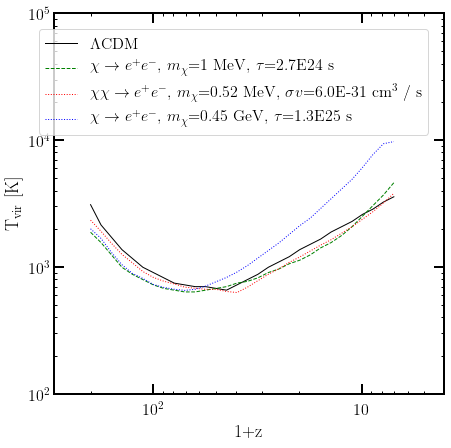

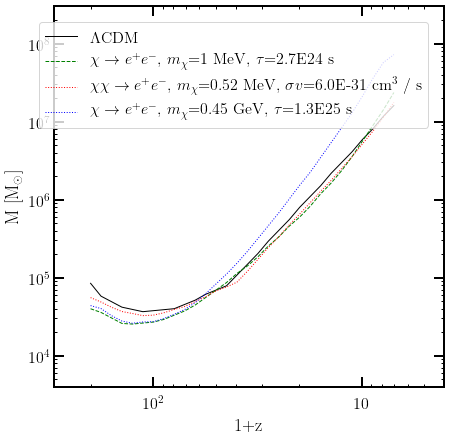

In [96]:
# Compare different dark matter models
plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(res_dist['rs'], res_dist['T_vir'] / phys.kB, 
         color='k', linewidth=1, label=r'$\Lambda$CDM')
plt.plot(res_DMfull['rs'], res_DMfull['T_vir'] / phys.kB, 
         color='g', linewidth=1, linestyle='--', label=r'$\chi \rightarrow e^+e^-$, $m_\chi$=1 MeV, $\tau$=2.7E24 s')
plt.plot(res_DMfull2['rs'], res_DMfull2['T_vir'] / phys.kB, 
         color='r', linewidth=1, linestyle=':', label=r'$\chi\chi \rightarrow e^+e^-$, $m_\chi$=0.52 MeV, $\sigma v$=6.0E-31 cm$^3$ / s')
plt.plot(res_DMfull3['rs'], res_DMfull3['T_vir'] / phys.kB, 
         color='b', linewidth=1, linestyle=':', label=r'$\chi \rightarrow e^+e^-$, $m_\chi$=0.45 GeV, $\tau$=1.3E25 s')

plt.axis([300,4,1e2,1e5])
plt.xlabel("1+z")
plt.ylabel("T$_{\mathrm{vir}}$ [K]")
plt.legend(loc='best')
plt.savefig(fig_dir+'crit_Tvir.pdf')
plt.show()

plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(res_dist['rs'], res_dist['M_halo'], 
         color='k', linewidth=1, label=r'$\Lambda$CDM')
plt.plot(res_DMfull['rs'], res_DMfull['M_halo'], 
         color='g', linewidth=1, linestyle='--', label=r'$\chi \rightarrow e^+e^-$, $m_\chi$=1 MeV, $\tau$=2.7E24 s')
plt.plot(res_DMfull2['rs'], res_DMfull2['M_halo'], 
         color='r', linewidth=1, linestyle=':', label=r'$\chi\chi \rightarrow e^+e^-$, $m_\chi$=0.52 MeV, $\sigma v$=6.0E-31 cm$^3$ / s')
plt.plot(res_DMfull3['rs'], res_DMfull3['M_halo'], 
         color='b', linewidth=1, linestyle=':', label=r'$\chi \rightarrow e^+e^-$, $m_\chi$=0.45 GeV, $\tau$=1.3E25 s')

plt.axis([300,4,4e3,3e8])
plt.xlabel("1+z")
plt.ylabel(r"M [M$_\odot$]")
plt.legend(loc='best')
plt.savefig(fig_dir+'crit_Mhalo.pdf')
plt.show()

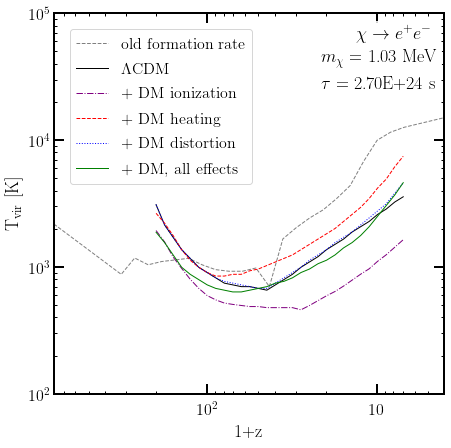

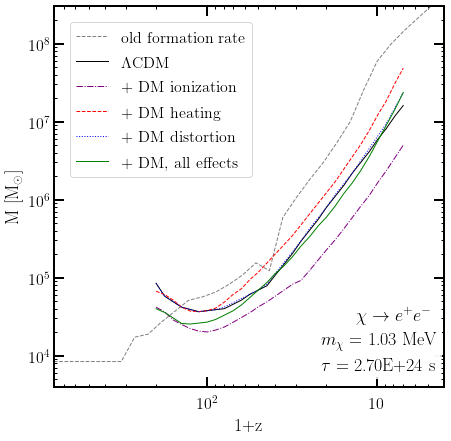

In [91]:
# Show effect of adding source terms one at a time
plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(res_Teg['rs'], res_Teg['T_vir'] / phys.kB, 
         color='gray', linestyle='--', linewidth=1, label='old formation rate')
plt.plot(res_dist['rs'], res_dist['T_vir'] / phys.kB, 
         color='k', linewidth=1, label=r'$\Lambda$CDM')
plt.plot(res_ion['rs'], res_ion['T_vir'] / phys.kB, 
         color='purple', linestyle='-.', linewidth=1, label='+ DM ionization')
plt.plot(res_heat['rs'], res_heat['T_vir'] / phys.kB, 
         color='r', linestyle='--', linewidth=1, label='+ DM heating')
plt.plot(res_DMdist['rs'], res_DMdist['T_vir'] / phys.kB, 
         color='b', linestyle=':', linewidth=1, label='+ DM distortion')
plt.plot(res_DMfull['rs'], res_DMfull['T_vir'] / phys.kB, 
         color='g', linewidth=1, label='+ DM, all effects')
# plt.plot(res_Teg['rs'], phys.TCMB(res_Teg['rs']) / phys.kB, 
#          color='gray', linewidth=1, linestyle=':')

plt.axis([800,4,1e2,1e5])
plt.text(0.75, 0.91, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.66, 0.84, fr"$m_\chi =$ {DM_data[DM_ind]['DM_params']['mDM']/1e6:.2f} MeV", fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.66, 0.78, fr"$\tau = $ {DM_data[DM_ind]['DM_params']['inj_param']:.2E} s", fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.xlabel("1+z")
plt.ylabel("T$_{\mathrm{vir}}$ [K]")
plt.legend(loc='best')

plt.savefig(fig_dir+'crit_Tvir_sourceterms1.pdf')
plt.show()

plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(res_Teg['rs'], res_Teg['M_halo'], 
         color='gray', linestyle='--', linewidth=1, label='old formation rate')
plt.plot(res_dist['rs'], res_dist['M_halo'], 
         color='k', linewidth=1, label=r'$\Lambda$CDM')
plt.plot(res_ion['rs'], res_ion['M_halo'],
         color='purple', linestyle='-.', linewidth=1, label='+ DM ionization')
plt.plot(res_heat['rs'], res_heat['M_halo'],
         color='r', linestyle='--', linewidth=1, label='+ DM heating')
plt.plot(res_DMdist['rs'], res_DMdist['M_halo'],
         color='b', linestyle=':', linewidth=1, label='+ DM distortion')
plt.plot(res_DMfull['rs'], res_DMfull['M_halo'], 
         color='g', linewidth=1, label='+ DM, all effects')

plt.axis([800,4,4e3,3e8])
plt.text(0.75, 0.15, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.66, 0.08, fr"$m_\chi =$ {DM_data[DM_ind]['DM_params']['mDM']/1e6:.2f} MeV", fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.66, 0.02, fr"$\tau = $ {DM_data[DM_ind]['DM_params']['inj_param']:.2E} s", fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.xlabel("1+z")
plt.ylabel(r"M [M$_\odot$]")
plt.legend(loc='best')

plt.savefig(fig_dir+'crit_Mhalo_sourceterms1.pdf')
plt.show()

# Try scaling ICS contribution and looking at structure boost

Turns out scaling ICS by density is bit involved because ICS is baked into transfer functions for high energy photons.

In [20]:
%autoreload

pri = 'elec'
DM_process = 'swave'
mDM=2e8
lifetime=2.69747957975171e+24
sigmav=9.67e-29

# Test no structure boost
res_nboost = main.evolve(
    DM_process=DM_process, primary=pri+'_delta',
    mDM=mDM, sigmav=sigmav,
    start_rs=3000., high_rs=1555., end_rs=4.,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    coarsen_factor=16, distort=True, fexc_switch=True, 
    reprocess_distortion=True, nmax=10, rtol=1e-6, iterations=1,
)
pickle.dump(res_nboost, open(
    output_dir+pri+'_'+DM_process+'_'
    +f"log10mDM_{np.log10(mDM):2.4f}_"+f"log10param_{np.log10(sigmav):2.4f}_"
    +"noboost"
    +'.p','wb'
))

# Test structure boost
res_boost = main.evolve(
    DM_process=DM_process, primary=pri+'_delta',
    mDM=mDM, sigmav=sigmav,
    start_rs=3000., high_rs=1555., end_rs=4.,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    coarsen_factor=16, distort=True, fexc_switch=True, 
    reprocess_distortion=True, nmax=10, rtol=1e-6, iterations=1,
    struct_boost=phys.struct_boost_func(model='NFW_no_subs')
)
pickle.dump(res_boost, open(
    output_dir+pri+'_'+DM_process+'_'
    +f"log10mDM_{np.log10(mDM):2.4f}_"+f"log10param_{np.log10(sigmav):2.4f}_"
    +"NFWnosubs"
    +'.p','wb'
))

# Do everything the same as in the IGM
# 'Conservative' in that it overestimates power going into ICS
# res_cons = main.evolve(
#     DM_process=DM_process, primary=pri+'_delta',
#     mDM=mDM, lifetime=lifetime,
#     start_rs=3000., high_rs=1555., end_rs=4.,
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     coarsen_factor=16, distort=True, fexc_switch=True, 
#     reprocess_distortion=True, nmax=10, rtol=1e-6, iterations=1,
# )
# pickle.dump(res_cons, open(
#     output_dir+pri+'_'+DM_process+'_'
#     +f"log10mDM_{np.log10(mDM):2.4f}_"+f"log10param_{np.log10(lifetime):2.4f}_"
#     +"ICScons"
#     +'.p','wb'
# ))

# # Scale ICS processes by n_IGM / n_halo as estimate
# # But this is tough, b/c n_halo depends on z and z_vir...
# res_est = main.evolve(
#     DM_process=DM_process, primary=pri+'_delta',
#     mDM=mDM, lifetime=lifetime,
#     start_rs=3000., high_rs=1555., end_rs=4.,
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     coarsen_factor=16, distort=True, fexc_switch=True, 
#     reprocess_distortion=True, nmax=10, rtol=1e-6, iterations=1,
#     density_factor=phys.baryon / 
# )
# pickle.dump(res_est, open(
#     output_dir+pri+'_'+DM_process+'_'
#     +f"log10mDM_{np.log10(mDM):2.4f}_"+f"log10param_{np.log10(lifetime):2.4f}_"
#     +"ICSest"
#     +'.p','wb'
# ))

# Set ICS processes to 0, so power into other processes is 'strong'
# res_strong = main.evolve(
#     DM_process=DM_process, primary=pri+'_delta',
#     mDM=mDM, lifetime=lifetime,
#     start_rs=3000., high_rs=1555., end_rs=4.,
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     coarsen_factor=16, distort=True, fexc_switch=True, 
#     reprocess_distortion=True, nmax=10, rtol=1e-6, iterations=1,
#     density_factor=0.
# )
# pickle.dump(res_strong, open(
#     output_dir+pri+'_'+DM_process+'_'
#     +f"log10mDM_{np.log10(mDM):2.4f}_"+f"log10param_{np.log10(lifetime):2.4f}_"
#     +"ICSstrong"
#     +'.p','wb'
# ))

In [8]:
%autoreload

rs_vir_list = np.logspace(np.log10(200.), np.log10(7.), num=30)

for key in ['noboost', 'NFWnosubs']: #['cons', 'est', 'strong']:
    print('Shooting scheme for '+key+'...')
    res = pickle.load(open(output_dir+'elec_swave_log10mDM_9.6021_log10param_-25.5228_'+key+'.p', 'rb'))

    # Make new Spectra object that gives TOTAL distortion at each redshift
    DM_specs = res['distortions'].copy()
    for ii, rs in enumerate(tqdm(res['rs'])):
        temp_dist = res['distortions'].copy()
        temp_dist.redshift(rs)
        weights = np.zeros_like(res['rs'])
        weights[:ii] = 1
        DM_specs[ii] = temp_dist.sum_specs(weight=weights)

    # Make interpolation functions for f's
    f_func_list = {}
    for fkey in res['f']:
        f_func_list[fkey] = interp1d(
            res['rs'], res['f'][fkey],
            bounds_error=False, fill_value=0
        )

    # Package DM information together
    test_DM = (
        mDM, # mDM in [eV]
        sigmav, # xsec
        DM_process, # injection type
        pri, # injected particle
        f_func_list, # energy deposition f's
    )

    collapse_res = shooting_scheme(rs_vir_list, dists=DM_specs, 
                          H2_cool_rate='new', DM_switch=True, DM_args=test_DM)
    pickle.dump(collapse_res, open(output_dir+'critical_collapse_'
                          +pri+'_'
                          +DM_process+'_'
                          +f"log10mDM_{np.log10(mDM):2.4f}_"
                          +f"log10param_{np.log10(sigmav):2.4f}_"
                          +key+'.p','wb'))

Shooting scheme for noboost...



Shooting scheme for NFWnosubs...


In [2]:
# res_cons = pickle.load(open(output_dir+'elec_decay_log10mDM_6.0137_log10param_24.4310_ICScons.p', 'rb'))
# res_strong = pickle.load(open(output_dir+'elec_decay_log10mDM_6.0137_log10param_24.4310_ICSstrong.p', 'rb'))

crit_dist = pickle.load(open(output_dir+f'critical_collapse_LCDM_dist.p', 'rb'))
crit_nboost = pickle.load(open(output_dir+'critical_collapse_elec_swave_log10mDM_9.6021_log10param_-25.5229_noboost.p', 'rb'))
crit_boost = pickle.load(open(output_dir+'critical_collapse_elec_swave_log10mDM_9.6021_log10param_-25.5229_NFWnosubs.p', 'rb'))

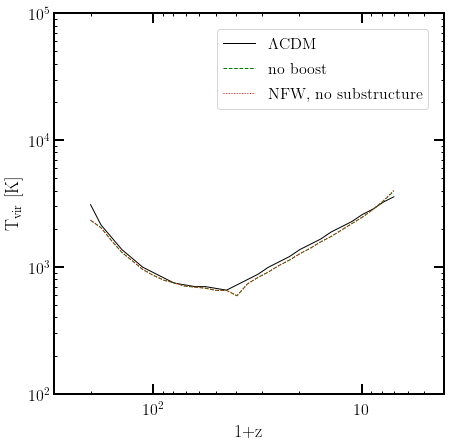

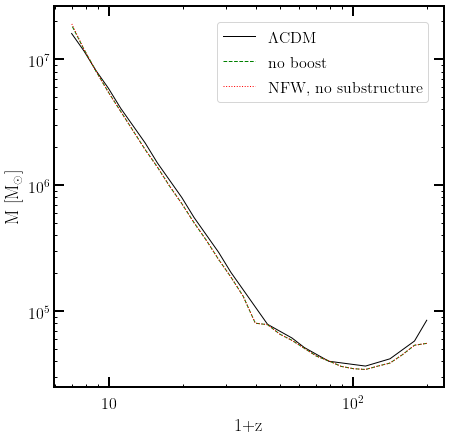

In [3]:
# Compare different dark matter models
plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(crit_dist['rs'], crit_dist['T_vir'] / phys.kB, 
         color='k', linewidth=1, label=r'$\Lambda$CDM')
plt.plot(crit_nboost['rs'], crit_nboost['T_vir'] / phys.kB, 
         color='g', linewidth=1, linestyle='--', label=r'no boost')
plt.plot(crit_boost['rs'], crit_boost['T_vir'] / phys.kB, 
         color='r', linewidth=1, linestyle=':', label=r'NFW, no substructure')
plt.axis([300,4,1e2,1e5])
plt.xlabel("1+z")
plt.ylabel("T$_{\mathrm{vir}}$ [K]")
plt.legend(loc='best')
# plt.savefig(fig_dir+'crit_Tvir.pdf')
plt.show()

plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(crit_dist['rs'], crit_dist['M_halo'], 
         color='k', linewidth=1, label=r'$\Lambda$CDM')
plt.plot(crit_nboost['rs'], crit_nboost['M_halo'], 
         color='g', linewidth=1, linestyle='--', label=r'no boost')
plt.plot(crit_boost['rs'], crit_boost['M_halo'], 
         color='r', linewidth=1, linestyle=':', label=r'NFW, no substructure')
plt.xlabel("1+z")
plt.ylabel(r"M [M$_\odot$]")
plt.legend(loc='best')
# plt.savefig(fig_dir+'crit_Mhalo.pdf')
plt.show()